# <span style='color:#0D2BA5'>Projet 6 - Classifiez automatiquement des biens de consommation : Traitement de Textes</span>

## <span style='background:#33B5FF'>Table des Matieres</span>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:#33B5FF'>1. Introduction</span>

**Mission**
*****
Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.
Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.
Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessus, avec un niveau de précision suffisant.

**Source**
*****
Le jeux de donnée est disponible à l'adresse : [Données]()
*****



**Axes d'orientations**
*****

Nous allons :
- Réaliser, dans une première itération, une étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.
- Analyser les descriptions textuelles et les images des produits, au travers : 
    - Un prétraitement des données texte ou image suivant le cas ;
    - Une extraction de features ;
    - Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;
    - Analyse du graphique afin d’en déduire ou pas, à l’aide des descriptions ou des images, la faisabilité de regrouper automatiquement des produits de même catégorie ;
    - Réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.
- Suivant cette approche, démontrer la faisabilité de regrouper automatiquement des produits de même catégorie 
- Extraire les features texte : 
     - Type “bag-of-words”, comptage simple de mots et Tf-idf ;
     - Une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
     - Une approche de type word/sentence embedding avec BERT ;
     - Une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 
     
     
- Extraire les features image, il sera nécessaire de mettre en œuvre :
     - Un algorithme de type SIFT / ORB / SURF ;
     - Un algorithme de type CNN Transfer Learning.

- **Conclusions**

## <span style='background:#33B5FF'>2. Bibliothèques d'analyse Python</span>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Chargement des librairies
import datetime
import time
import sys
import os
import string
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# Feature extraction
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, \
    HashingVectorizer
# Traitement de text
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from stop_words import get_stop_words
from nltk. stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
import multiprocessing
# Réduction dimension
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

# USE
import tensorflow as tf
import tensorflow_hub as hub

# Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## <span style='background:#33B5FF'>3. Analyse du jeux de données </span>

In [3]:
data = pd.read_csv('/kaggle/input/place-du-marche/flipkart_com-ecommerce_sample_1050.csv')

In [4]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 15 variables.


In [5]:
# Les 3 premieres lignes
data.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [6]:
# Les valeurs manquantes
data.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [7]:
# Descriptions des données 
data.describe(include = 'all').T

count unique  \
uniq_id                    1050   1050   
crawl_timestamp            1050    149   
product_url                1050   1050   
product_name               1050   1050   
product_category_tree      1050    642   
pid                        1050   1050   
retail_price             1049.0    NaN   
discounted_price         1049.0    NaN   
image                      1050   1050   
is_FK_Advantage_product    1050      2   
description                1050   1050   
product_rating             1050     27   
overall_rating             1050     27   
brand                       712    490   
product_specifications     1049    984   

                                                                       top  \
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                  2015-12-01 12:40:44 +0000   
product_url              http://www.flipkart.com/elegance-polyester-mul...   
product_name             Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree    ["Home Furnishing >> Bed Linen >> Blankets, Qu...   
pid                                                       CRNEG7BKMFFYHQ8Z   
retail_price                                                           NaN   
discounted_price                                                       NaN   
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg   
is_FK_Advantage_product                                              False   
description              Key Features of Elegance Polyester Multicolor ...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                         PRINT SHAPES   
product_specifications   {"product_specification"=>[{"key"=>"Type", "va...   

                        freq         mean          std   min    25%    50%  \
uniq_id                    1          NaN          NaN   NaN    NaN    NaN   
crawl_timestamp          150          NaN          NaN   NaN    NaN    NaN   
product_url                1          NaN          NaN   NaN    NaN    NaN   
product_name               1          NaN          NaN   NaN    NaN    NaN   
product_category_tree     56          NaN          NaN   NaN    NaN    NaN   
pid                        1          NaN          NaN   NaN    NaN    NaN   
retail_price             NaN  2186.197331  7639.229411  35.0  555.0  999.0   
discounted_price         NaN  1584.527169   7475.09968  35.0  340.0  600.0   
image                      1          NaN          NaN   NaN    NaN    NaN   
is_FK_Advantage_product  993          NaN          NaN   NaN    NaN    NaN   
description                1          NaN          NaN   NaN    NaN    NaN   
product_rating           889          NaN          NaN   NaN    NaN    NaN   
overall_rating           889          NaN          NaN   NaN    NaN    NaN   
brand                     11          NaN          NaN   NaN    NaN    NaN   
product_specifications    22          NaN          NaN   NaN    NaN    NaN   

                            75%       max  
uniq_id                     NaN       NaN  
crawl_timestamp             NaN       NaN  
product_url                 NaN       NaN  
product_name                NaN       NaN  
product_category_tree       NaN       NaN  
pid                         NaN       NaN  
retail_price             1999.0  201000.0  
discounted_price         1199.0  201000.0  
image                       NaN       NaN  
is_FK_Advantage_product     NaN       NaN  
description                 NaN       NaN  
product_rating              NaN       NaN  
overall_rating              NaN       NaN  
brand                       NaN       NaN  
product_specifications      NaN       NaN

- Clés uniques : uniq_id, product_url, product_name, pid, image, description.
- Variables avec des valeurs manquantes : retail_price, discounted_price, brand, product_specifications    

In [8]:
# Types des variables 
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

**Compréhension des variables**
***
| Variable | Description | Note |
| --- | --- | --- |
| uniq_id | Identifiant unique | <span style='background:PeachPuff'>Clé unique</span> - ex : 59af3731b809a25f2bf99e99f645d8dd |
| crawl_timestamp | Horodatage | Format YYYY-MM-DD HH24:MI:SS +0000|
| product_url | URL d'accès au produit sur le site e-commerce Flickart | <span style='background:PeachPuff'>Clé unique</span> |
| **product_name** | Nom du produit | <span style='background:PeachPuff'>Clé unique</span> - <span style='background:Aqua'>Texte</span> |
| **product_category_tree** | Arbre des catégories des produits | Notre cible - sous-catégories séparées par '>>' - <span style='background:Aqua'>Texte</span> - <span style='background:Salmon'>Données multiples</span>|
| pid | Identifiant unique | <span style='background:PeachPuff'>Clé unique</span> - ex : CAGEBTJBTNGGDZQZ |
| retail_price | Prix de consommation |  |
| discounted_price | Prix réduit |  |
| **image** | Image | <span style='background:PeachPuff'>Clé unique</span> - Format : uniq_id.jpg ==> référence aux <span style='background:Plum'>images</span> du jeu de données |
| is_FK_Advantage_product | Produit avantageux FlipKart? | Booléen |
| **description** | Description du produit | <span style='background:PeachPuff'>Clé unique</span> - <span style='background:Aqua'>Texte</span> |
| product_rating | Évaluation du produit | Entre 1 et 5 avec 1 chiffre après la virgule ou 'No rating available' |
| overall_rating | Note moyenne globale d'évaluation | Entre 1 et 5 avec 1 chiffre après la virgule ou 'No rating available' |
| **brand** | Marque du produit | Valeurs manquantes - <span style='background:Aqua'>Texte</span> |
| **product_specifications** | Spécification du produit | Propriétés techniques avec clé/valeur  <span style='background:Salmon'>Données multiples</span> |

In [9]:
# Copie du jeux de données 
data_ana = data.copy()


- **uniq_id** et **pid** sont des clés uniques compliquées, peu explicites et ne nous permettent pas de trouver la catégorie du produit.
- **product_url** est une clé unique qui contient des informations sur le produit  redondantes avec **'description'**.
- La variable **product_name** est unique et explicite, on la conservera comme clé primaire du produit.

**Conclusion** :
- Variables non conservées : **uniq_id**, **pid** et **product_url**.
- Variable conservée comme clé unique : **product_name**.

In [10]:
# Transforme de Object en Datetime
data_ana['crawl_timestamp'] = pd.to_datetime(data_ana['crawl_timestamp'])
# Période de notre sous-jeu de données
min = data_ana['crawl_timestamp'].min().strftime('%d/%m/%Y')
max = data_ana['crawl_timestamp'].max().strftime('%d/%m/%Y')
print(f'Période d\'ajout des produits : du {min} au {max}')

Période d'ajout des produits : du 01/12/2015 au 26/06/2016


**Remarque**: ce varible ne nous donne aucune information sur les catrgories de produits 

**Conclusion**: Varibae non conservée : **crawl_timestamp**

In [11]:
print(data['product_category_tree'].head(1))

0    ["Home Furnishing >> Curtains & Accessories >>...
Name: product_category_tree, dtype: object


- La variable **product_category_tree** est constituée de plusieurs sous-catégories de produits séparées par des chevrons.
- Exemple : Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...

In [12]:
def distribution_variables_plages_pourc_donnees(
        dataframe, variable, liste_bins):
    """
    Retourne les plages des pourcentages des valeurs pour le découpage transmis
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                variable : variable à découper obligatoire
                liste_bins: liste des découpages facultatif int ou pintervallindex
    @param OUT : dataframe des plages de nan
    """
    nb_lignes = len(dataframe[variable])
    s_gpe_cut = pd.cut(
        dataframe[variable],
        bins=liste_bins).value_counts().sort_index()
    df_cut = pd.DataFrame({'Plage': s_gpe_cut.index,
                           'nb_données': s_gpe_cut.values})
    df_cut['%_données'] = [
        (row * 100) / nb_lignes for row in df_cut['nb_données']]

    return df_cut.style.hide()

In [13]:
def decoupe_texte_selon_separateur(dataframe, variable, separateur):

    # Parcours des textes de la variable et on compte le nombre de niveau
    liste_profondeur = []
    for row_index in dataframe.index:
        liste_profondeur.append(len(dataframe.loc[row_index, variable]
                                    .split(separateur)))
    nbr_niveaux = len(liste_profondeur) + 1
    liste_niveaux = np.unique(liste_profondeur)
    #s_niveaux_min = min(liste_profondeur)
    #s_niveaux_max = max(liste_profondeur)
    display('Nombre de sous-niveaux : ' + str(nbr_niveaux))
    display('Sous-niveaux existants : ' + str(liste_niveaux))
    #display('Sous-niveaux minimum : ' + str(min(liste_profondeur)))
    #display('Sous-niveaux maximum : ' + str(max(liste_profondeur)))

    # Répartition des sous-niveaux?
    nbr_par_niveau = [liste_profondeur.count(i) for i in liste_niveaux]
    data_par_niveau = pd.DataFrame(nbr_par_niveau, index=liste_niveaux,
                                   columns=['Nbre_par_niveau'])

    # Affiche le nombre d'éléments par niveaux
    display('Nombre de produits n\'ayant que x sous-niveaux')
    display('---------------------------------------------------------------')
    display(data_par_niveau)

    sns.barplot(x=data_par_niveau.index, y=data_par_niveau.Nbre_par_niveau,
                data=data_par_niveau, color='SteelBlue')
    plt.title('Répartitions du nombre de produits n\'ayant que x sous-niveaux')
    plt.xlabel('Sous-niveaux')
    plt.ylabel('Nombre de produits')
    plt.show()

    # Découpe les sous-catégories dans des nouvelles variables du dataframe
    work = dataframe['product_category_tree'].str.split(' >> ', expand=True)

    for i in range(0, 7):
        dataframe['Categorie_' + str(i + 1)] = work[i]
    # Nettoye les [" et "]
    dataframe.replace('\\["', '', regex=True, inplace=True)
    dataframe.replace('"\\]', '', regex=True, inplace=True)
    for i in range(1, 7):
        display(
            'Nombre de catégories contenant x% d\'images pour la plage pour le niveau ' +
            str(i))
        df_cat = dataframe.groupby(
            'Categorie_' + str(i)). agg({'image': 'count'})
        df_cat = df_cat.reset_index().sort_values(by='image', ascending=False)
        display(
            distribution_variables_plages_pourc_donnees(
                df_cat, 'image', [
                    0, 10, 50, 100, 150]))

    # Répartition du nombre d'mages pour les sous-niveaux e et 2
    for i in range(1, 3):
        df_cat = dataframe.groupby('Categorie_' + str(i))[['product_name']] \
            .count().sort_values(by='product_name', ascending=False)
        plt.figure(figsize=(15, 22))
        sns.barplot(y=df_cat.index, x=df_cat.product_name, data=df_cat,
                    color='SteelBlue')
        plt.title(
            'Répartitions du nombre de produits pour le niveau ' +
            str(i),
            fontsize=25)
        plt.xlabel('Nombre de produits(=images)', fontsize=25)
        plt.ylabel('Catégorie du niveau ' + str(i), fontsize=25)
        plt.yticks(fontsize=25)
        plt.grid(False)
        plt.show()

    return dataframe

'Nombre de sous-niveaux : 1051'

'Sous-niveaux existants : [2 3 4 5 6 7]'

"Nombre de produits n'ayant que x sous-niveaux"

'---------------------------------------------------------------'

Nbre_par_niveau
2                3
3              368
4              274
5              278
6               70
7               57

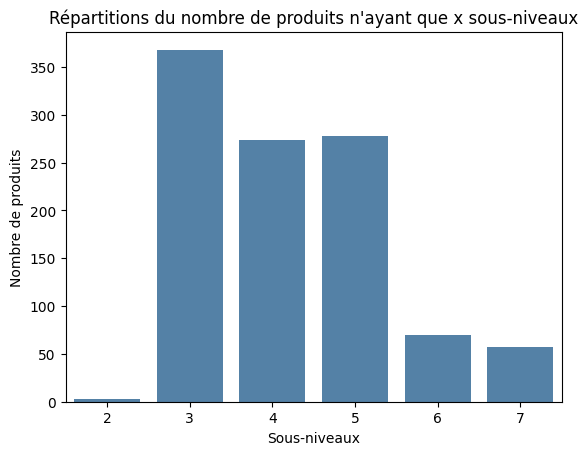

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 1"

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 2"

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 3"

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 4"

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 5"

"Nombre de catégories contenant x% d'images pour la plage pour le niveau 6"

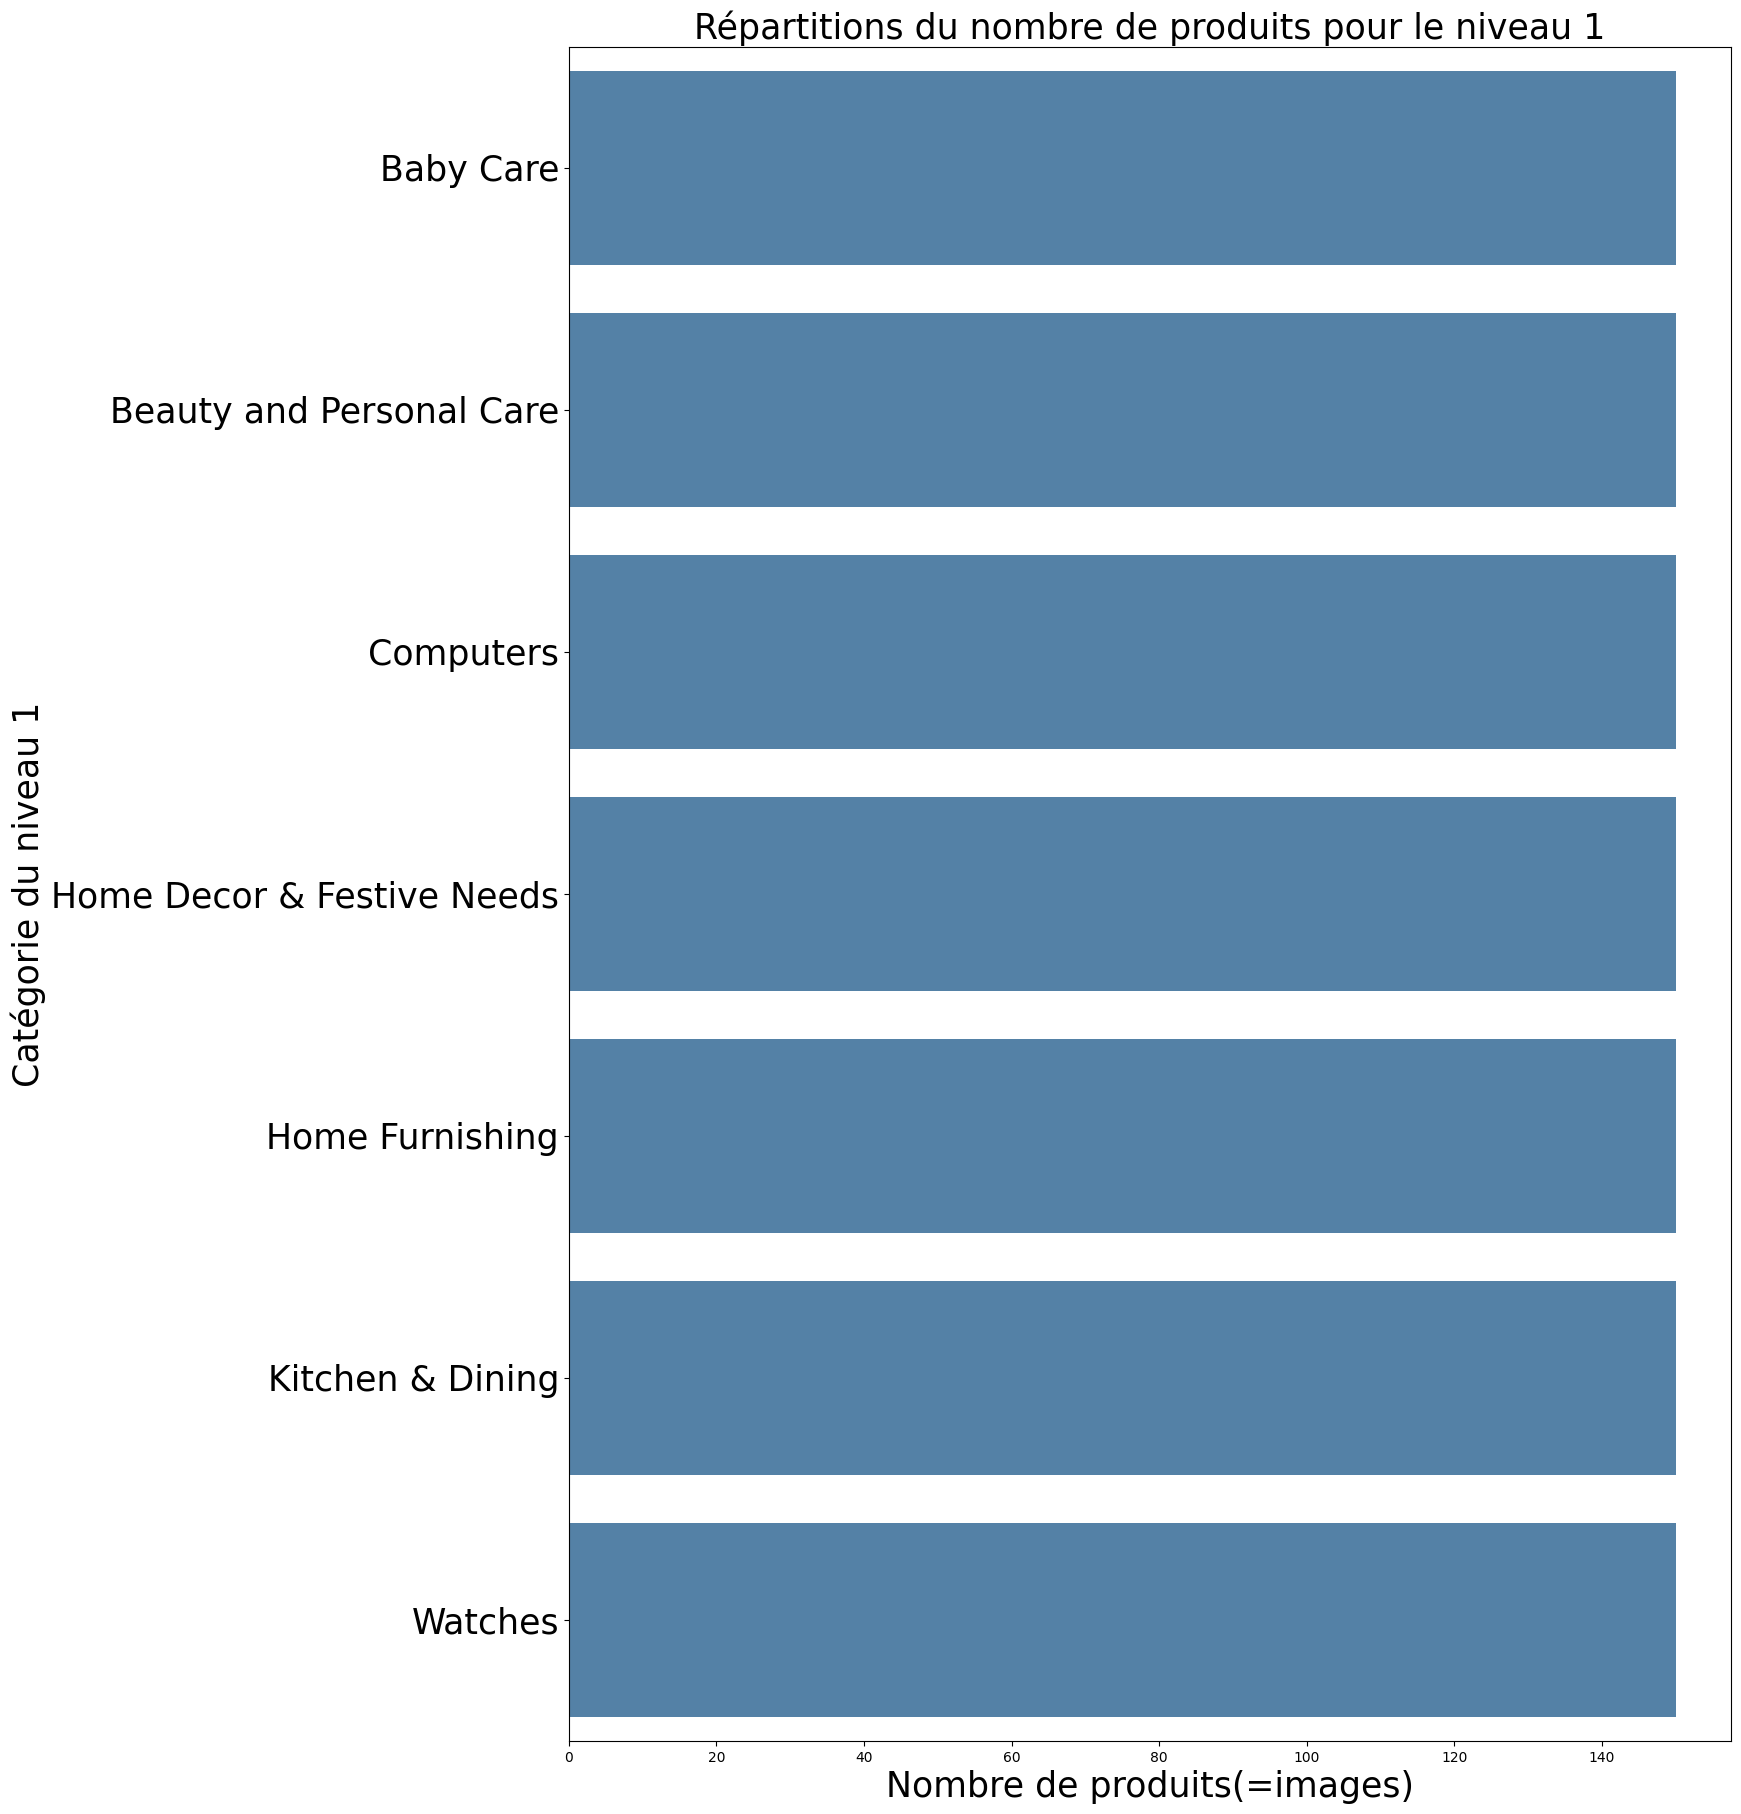

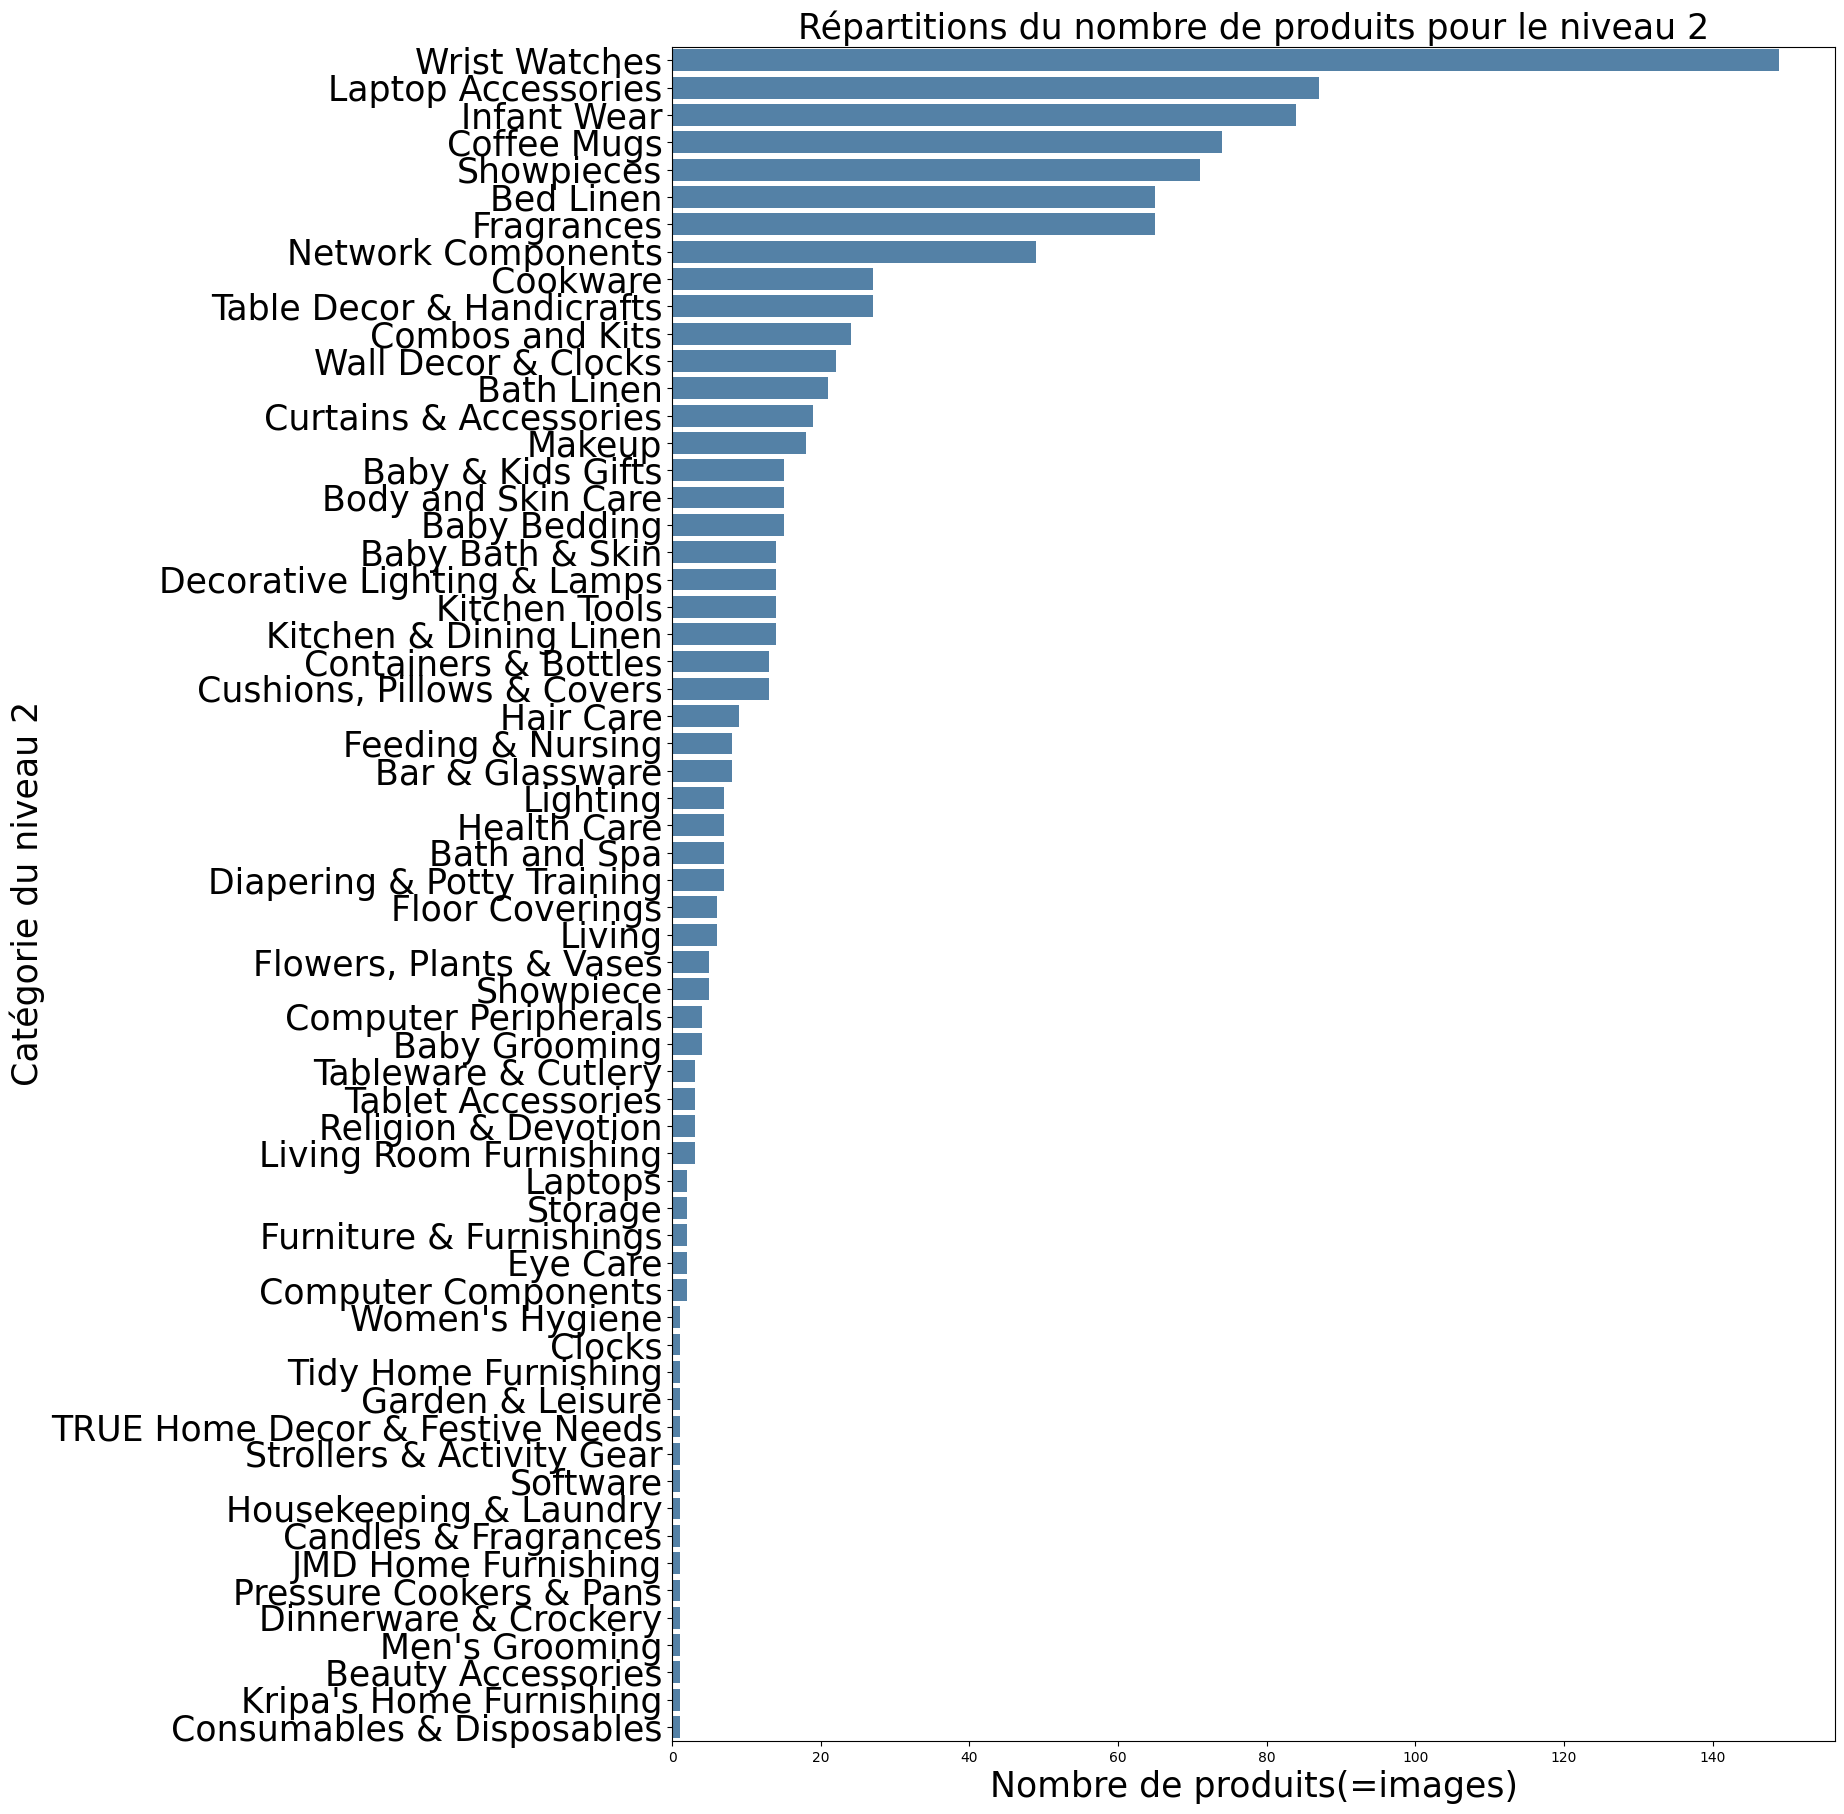

In [14]:
data = decoupe_texte_selon_separateur(data,'product_category_tree',' >> ')

In [15]:
# Nombre de catégories par niveau?
niveaux = ['Categorie_1', 'Categorie_2', 'Categorie_3', 'Categorie_4',
           'Categorie_5', 'Categorie_6', 'Categorie_7']
for niveau in niveaux:
    print(niveau + ' : ' + str(data[niveau].nunique()) + ' catégories')

Categorie_1 : 7 catégories
Categorie_2 : 62 catégories
Categorie_3 : 241 catégories
Categorie_4 : 349 catégories
Categorie_5 : 297 catégories
Categorie_6 : 117 catégories
Categorie_7 : 57 catégories


**Bilan** :
***
- Les sous-catégories sont comprises entre 2 au minimum et 7 au maximum.
- La plupart des produits ont entre 3 et 5 sous-niveaux.
- Le premier niveau comporte 7 catégories ayant chacune 150 images.
- Les autres niveaux comportent de nombreuses catégories ayant moins de 10 images, ce qui est bien insuffisant pour pouvoir correctement catégoriser ces niveaux en automatique. 

**Le niveau 1 des catégories sera utilisé pour la suite de l'analyse.**

In [16]:
# Est-ce que chaque produit à bien une photographie associée dans le
# répertoire 'Images'?
photo_image = []
for photo in os.listdir('/kaggle/input/images-place-du-marche/Images'):
    photo_image.append(photo)
verif_exist = data[~data['image'].isin(photo_image)]
verif_exist

Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, Categorie_1, Categorie_2, Categorie_3, Categorie_4, Categorie_5, Categorie_6, Categorie_7]
Index: []

[0 rows x 22 columns]

- Toutes les images ont bien un fichier de photographie dans le répertoire 'Images'.

**Variables unitules pour la suite**
- **retail_price** : le prix de consommation peut indiquer si le produit est onéreux ou pas donc une idée de la catégorie mais aucune exploitation associée au texte ou à l'image.
- **discounted_price** : le prix réduit peut indiquer si le produit est onéreux ou pas donc une idée de la catégorie mais aucune exploitation associée au texte ou à l'image.
- **is_FK_Advantage_product** : booléen dont on ne peut tirer aucune information de texte ou d'image.
- **product_rating** : note du produit dont on ne peut tirer aucune information de texte ou d'image.
- **overall_rating** : note moyenne globale du produit dont on ne peut tirer aucune information de texte ou d'image

Ces variables ne seront pas conservées.

**Bilan de l'analyse exploratoire** :
***
- Notre mission est d'automatiser la classification des catégories des produits ajoutés par le vendeur à partir des descriptions textuelles et des images mis à disposition dans le jeu de données.
- Parmi les 6 clés uniques disponibles, le nom du produit sera conservé comme clé unique :
    - [x] **product_name**.
- Les variables utiles, conservées, contenant des données textuelles ou des images, sont :
    - [x] **image**,
    - [x] **product_category_tree**,
    - [x] **description**,
    - [x] **product_specifications**,
    - [x] **brand**,
    - [x] **Categorie_1**.

In [17]:
 # Constitution du dataframe de travail
data_work = data[['product_name', 'brand', 'image', 'product_category_tree',
                  'description', 'product_specifications', 'Categorie_1']]

In [18]:
data_work.describe(include="all").T

count unique  \
product_name            1050   1050   
brand                    712    490   
image                   1050   1050   
product_category_tree   1050    642   
description             1050   1050   
product_specifications  1049    984   
Categorie_1             1050      7   

                                                                      top freq  
product_name            Elegance Polyester Multicolor Abstract Eyelet ...    1  
brand                                                        PRINT SHAPES   11  
image                                55b85ea15a1536d46b7190ad6fff8ce7.jpg    1  
product_category_tree   Home Furnishing >> Bed Linen >> Blankets, Quil...   56  
description             Key Features of Elegance Polyester Multicolor ...    1  
product_specifications  {"product_specification"=>[{"key"=>"Type", "va...   22  
Categorie_1                                               Home Furnishing  150

## <span style='background:#33B5FF'>4. Pré-traitement des données </span>

Préparation des données, les rendant exploitables pour l'automatisation des catégorisation.

Pré-traitement pas à pas pour observer le résultat de chaque étape pour les transformations effectuées sur la variable 'description'.

### <span style='background:#33B5FF'>4.1 Pré-traitement pas a pas : Description </span>

#### <span style='background:#33B5FF'>4.1.1 Tokenisation </span>

Pemière phase de définition de l'objet de l'analyse : 
- la tokenisation des textes qui consiste à identifier les unités de textes élémentaires (tokens) qui peuvent être des mots, mais aussi des lettres, des syllabes, des phrases, ou des séquences de ces éléments.
- Si les mots sont des unités de sens évidentes, les paires, les triplets de mots le sont aussi (n-grammes).
- à partir de ces tokens, l'analyse de la fréquence des mots peut être effectuée pour construire un dictionnaire permettant de filtrer les tokens selon leurs fréquences.
- les tokens les plus fréquents qui n'apportent donc aucune information sont supprimés.
- les tokens très peu fréquents qui apportent une information singulière sont également supprimés.

In [19]:
def suivre_modif_texte(dataframe, action, valeur):
    '''
    Ajoute l'action et la valeur dans un dataframe de suivi des modifications
    du texte pour les différentes action effectuée.
    Parameters
    ----------
    dataframe : dataframe de suivi des modifications, obligaotire.
    action : string, obligatoire (ex : tokenisation, lemmatisation...).
    valeur : texte après avoir subi la modification de l'action, obligatoire.
    Returns
    -------
    dataframe : le dataframe de suivi des modifications avec l'action ajoutée.
    '''
    dataframe = dataframe._append(pd.DataFrame({'Action': [action],
                                               'Contenu': [valeur]}),
                                 ignore_index=True)

    return dataframe


In [20]:
# Dataframe témoin des modifications
df_temoin = pd.DataFrame({})
df_temoin = suivre_modif_texte(df_temoin, 'Texte original',
                                  data_work['description'][1046])

In [21]:
df_temoin.style.hide()

In [22]:
def mettre_minuscule(text):
    return ''.join([i.lower() for i in text])
# C'est mieux que "word_tokenize" parce qu'il enlève également les nombres
def tokenisation(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    return tokenizer.tokenize(text) 
def supprimer_mots(text):
    return [x for x in text if len(x) > 2 ]


In [23]:
# Mettre en minuscule
data_work['description_clean'] = data_work['description'].apply(lambda x: mettre_minuscule(x))

df_temoin = suivre_modif_texte(df_temoin, 'Mettre en minuscule',
                                  data_work['description_clean'][1046])

In [24]:
df_temoin.style.hide()

In [25]:
# Tokenisation
data_work['description_clean'] = data_work['description_clean'].apply(lambda x: tokenisation(x))

df_temoin = suivre_modif_texte(df_temoin, 'Tokenisation',
                                  data_work['description_clean'][1046])

In [26]:
df_temoin.style.hide()

In [27]:
# Supprimer tokens courts
data_work['description_clean'] = data_work['description_clean'].apply(lambda x: supprimer_mots(x))

df_temoin = suivre_modif_texte(df_temoin, 'Supprimer tokens courts',
                                  data_work['description_clean'][1046])

In [28]:
df_temoin.style.hide()

In [29]:
# Nombre de tokens total dans toutes les descriptions
list_all_token = []
for row in data_work['description_clean']:
    list_all_token.extend(row)
nb_tok = len(list_all_token)
nb_tok_unique = len(set(list_all_token))
display(f'Nombre de tokens total dans les descriptions : {nb_tok}')
display(f'Nombre de tokens uniques dans les descriptions : {nb_tok_unique}')

'Nombre de tokens total dans les descriptions : 64192'

'Nombre de tokens uniques dans les descriptions : 4995'

#### <span style='background:#33B5FF'>4.1.2 Normalisation </span>

Deuxième phase de lissage, correction et nettoyage des données textuelles :
- Mettre le texte en minuscule, mais au risque de perdre les capitales initiales qui indicent les noms communs,  
- supprimer la ponctuation, mais du même coup peut déstructurer les phrases, 
- éliminer les nombres et dates, 
- repérer (et éliminer) les liens URL et les mentions de personnes
- éliminer aussi les mots sans signification que l’anglais dénomme par “stopwords” avec des dictionnaires, 
- repérer et traiter les émoticônes...

In [30]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [31]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

**On construit notre fonction de preprocessing qui va successivement :**

- enlever les chiffres
- enlever les stopwords (mots n’apportant pas de sens)
- lemmatizer
- reformer les phrases avec les mots restants

In [32]:
# Supprimer les stopwords

data_work['description_clean'] = data_work['description_clean'].apply(lambda x: [word for word in x if word not in stop and word.isalnum()])
# Ajoute dans le dataframe témoin
df_temoin = suivre_modif_texte(df_temoin, 'supp_stopwords',
                                  data_work['description_clean'][1046])

In [33]:
df_temoin.style.hide()

In [34]:
# Création d'un corpus 
temp = list(data_work['description_clean'])
flat_list = [item for sublist in temp for item in sublist]
corpus_stem = sorted(set(flat_list))

In [35]:
freq_totale = nltk.Counter(flat_list)
most_common = freq_totale.most_common(100)

In [36]:
# most_common n'est pas une liste

list_of_most_common = []
for a_tuple in most_common:
    list_of_most_common.append(a_tuple[0])
    
# list_of_most_common donne la liste des mots top 100

list_of_most_common

['products',
 'free',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'day',
 'flipkart',
 'com',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price',
 'watch',
 'color',
 'mug',
 'baby',
 'pack',
 'material',
 'set',
 'type',
 'cotton',
 'box',
 'general',
 'package',
 'analog',
 'sales',
 'number',
 'warranty',
 'quality',
 'details',
 'product',
 'brand',
 'best',
 'model',
 'design',
 'key',
 'ceramic',
 'laptop',
 'fabric',
 'prices',
 'showpiece',
 'made',
 'great',
 'perfect',
 'inch',
 'india',
 'men',
 'size',
 'usb',
 'dimensions',
 'ideal',
 'girl',
 'home',
 'skin',
 'coffee',
 'multicolor',
 'contents',
 'combo',
 'water',
 'gift',
 'women',
 'printed',
 'discounts',
 'black',
 'width',
 'mugs',
 'wash',
 'also',
 'print',
 'care',
 'blue',
 'cover',
 'power',
 'battery',
 'light',
 'use',
 'adapter',
 'height',
 'yes',
 'pattern',
 'high',
 'style',
 'length',
 'one',
 'easy',
 'dress',
 'name',
 'weight',
 'round',
 'designed',
 'bod

In [37]:
data_work['description_clean'] = data_work['description_clean'].apply(lambda x:[word for word in x if word not in list_of_most_common])
df_temoin = suivre_modif_texte(df_temoin, 'Suppressiosn 1er corpus communs',
                                  data_work['description_clean'][1046])

In [38]:
df_temoin.style.hide()

In [39]:
type(data_work['description_clean'][0])


list

In [40]:
# Transformer liste en string
data_work['description_clean'] = data_work['description_clean'].apply(lambda x: ' '.join(x))
# Suivi des modifications
df_temoin = suivre_modif_texte(df_temoin, 'Tokens en 1 phrase',
                                  data_work['description_clean'][1046])

In [41]:
df_temoin.style.hide()

In [42]:
# Fréquence de tous les mots de tous les produits dans la description?
texte = ''
sentence = ' '.join([texte + row for row in data_work['description_clean']])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)
# Constitution du dataframe de travail
df_frequence_mot = pd.DataFrame({'Mot': fdist.keys(),
                                 'Frequence': fdist.values()}) \
                    .sort_values(['Frequence'], ascending=False)
nb_tot = df_frequence_mot['Frequence'].count()
df_frequence_mot['%_frequence'] = \
    round((df_frequence_mot['Frequence'])*100/nb_tot, 2)

In [43]:
# Mots très fréquents?
df_frequence_mot[df_frequence_mot['%_frequence'] > 5]

Empty DataFrame
Columns: [Mot, Frequence, %_frequence]
Index: []

In [44]:
# Mots très rares?
df_frequence_mot[df_frequence_mot['Frequence'] < 3]

Mot  Frequence  %_frequence
152             waranty          2         0.04
1168             bangle          2         0.04
1171             earing          2         0.04
3587         occassions          2         0.04
1176  goldencollections          2         0.04
...                 ...        ...          ...
3594     multifunctions          1         0.02
110         susceptible          1         0.02
3591            dhrohar          1         0.02
3589                hoa          1         0.02
3259              twill          1         0.02

[2586 rows x 3 columns]

In [45]:
# Ajout des mots très fréquents
custom_words_manuel = set(df_frequence_mot['Mot'].head().to_list())
# Ajout des mots rares
custom_words_manuel = \
    custom_words_manuel.union(df_frequence_mot[df_frequence_mot['Frequence']
                                               < 3]['Mot'].to_list())
# Supprimer les stop_words anglais définis dans les 2 librairies

stop.update(custom_words_manuel)

In [46]:
type(data_work['description_clean'][0])

str

In [47]:
# Tokenisation
data_work['description_clean'] = data_work['description_clean'].apply(lambda x: tokenisation(x))

df_temoin = suivre_modif_texte(df_temoin, 'Tokenisation',
                                  data_work['description_clean'][1046])

In [48]:
df_temoin.style.hide()

In [49]:
data_work['description_clean'] = data_work['description_clean'].apply(lambda x:[word for word in x if word not in stop])
# Ajoute dans le dataframe témoin
df_temoin = suivre_modif_texte(df_temoin, 'Supprimer 2 em corpus les mots frequents-rares',
                                  data_work['description_clean'][1046])

In [50]:
df_temoin.style.hide()

In [51]:
def affiche_wordcloud_hue(dataframe, variable, var_hue, nb_mots):
    liste_hue = dataframe[var_hue].unique().tolist()
    for cat in liste_hue:
        print('Mots les plus fréquents de la catégorie : ' + cat)
        wordcloud = WordCloud(max_words=nb_mots, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate( ' '.join(dataframe[dataframe[var_hue] == cat][variable]))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [52]:
def pre_stemm(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        words_stemm = (porter_stemmer.stem(w) for w in sentence)
        sentence_clean = ' '.join(w for w in words_stemm if w.lower() in words or not w.isalpha())
        preprocess_list.append(sentence_clean)
    return preprocess_list  

In [53]:
#Stemm 
data_work['description_clean'] = pre_stemm(data_work['description_clean'])
# Ajoute dans le dataframe témoin
df_temoin = suivre_modif_texte(df_temoin, 'Stemmatisation',
                                  data_work['description_clean'][1046])

In [54]:
df_temoin.style.hide()

In [55]:
# Tokenisation
data_work['description_clean'] = data_work['description_clean'].apply(lambda x: tokenisation(x))

df_temoin = suivre_modif_texte(df_temoin, 'Tokenisation',
                                  data_work['description_clean'][1046])

In [56]:
df_temoin.style.hide()

In [57]:
def pre_lemm(listofSentence ):
    preprocess_list = []
    for sentence in listofSentence :
        words_lemmatize = (lemmatizer.lemmatize(w) for w in sentence)
        sentence_clean = ' '.join(w for w in  words_lemmatize if w.lower() in words or not w.isalpha())
        preprocess_list.append(sentence_clean)
    return preprocess_list 

In [58]:
#Lemm 
data_work['description_clean'] = pre_lemm(data_work['description_clean'])
# Ajoute dans le dataframe témoin
df_temoin = suivre_modif_texte(df_temoin, 'Lemmatisation',
                                  data_work['description_clean'][1046])

In [59]:
df_temoin.style.hide()

Mots les plus fréquents de la catégorie : Home Furnishing


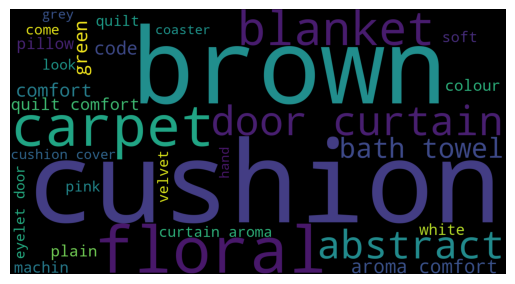

Mots les plus fréquents de la catégorie : Baby Care


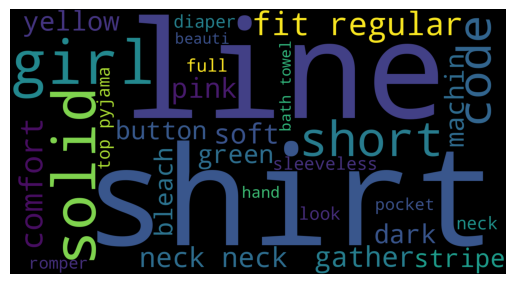

Mots les plus fréquents de la catégorie : Watches


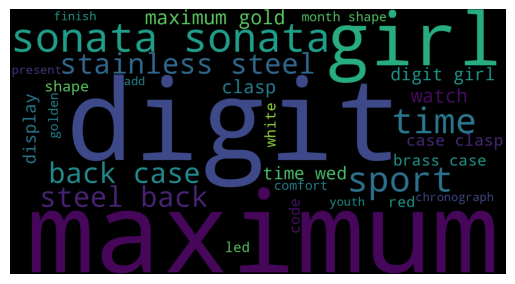

Mots les plus fréquents de la catégorie : Home Decor & Festive Needs


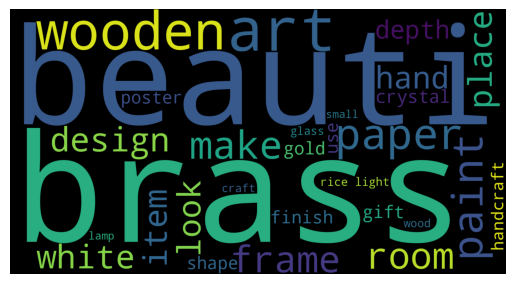

Mots les plus fréquents de la catégorie : Kitchen & Dining


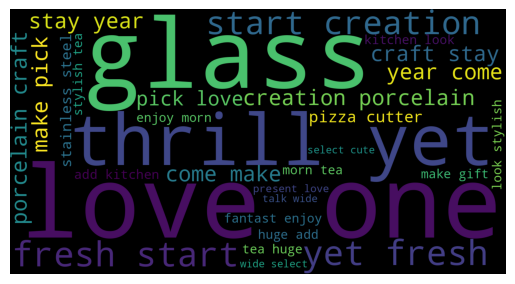

Mots les plus fréquents de la catégorie : Beauty and Personal Care


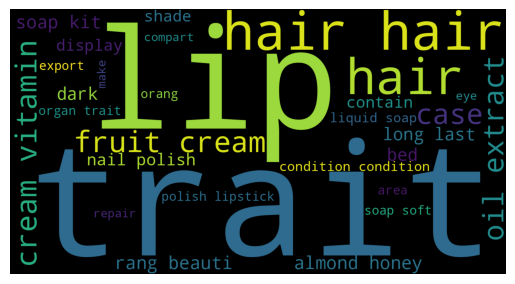

Mots les plus fréquents de la catégorie : Computers


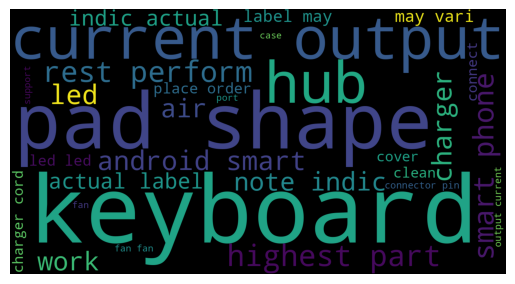

In [60]:
from wordcloud import WordCloud
affiche_wordcloud_hue(data_work,'description_clean','Categorie_1',30)

In [61]:
# Préparation du dataframe de travail
# ---------------------------------------------------------------------
# Fréquence de tous les mots de tous les produits dans la description
# nettoyée ?
texte = ''
sentence = ' '.join([texte + row for row in data_work['description_clean']])
tokens = nltk.word_tokenize(sentence)
fdist = FreqDist(tokens)
# Constitution du dataframe de travail
df_freq_clean = pd.DataFrame({'Mot': fdist.keys(),
                              'Frequence': fdist.values()}) \
                .sort_values(['Frequence'], ascending=False)
nb_tot = df_freq_clean['Frequence'].count()
df_freq_clean['%_frequence'] = \
    round((df_freq_clean['Frequence'])*100/nb_tot, 2)

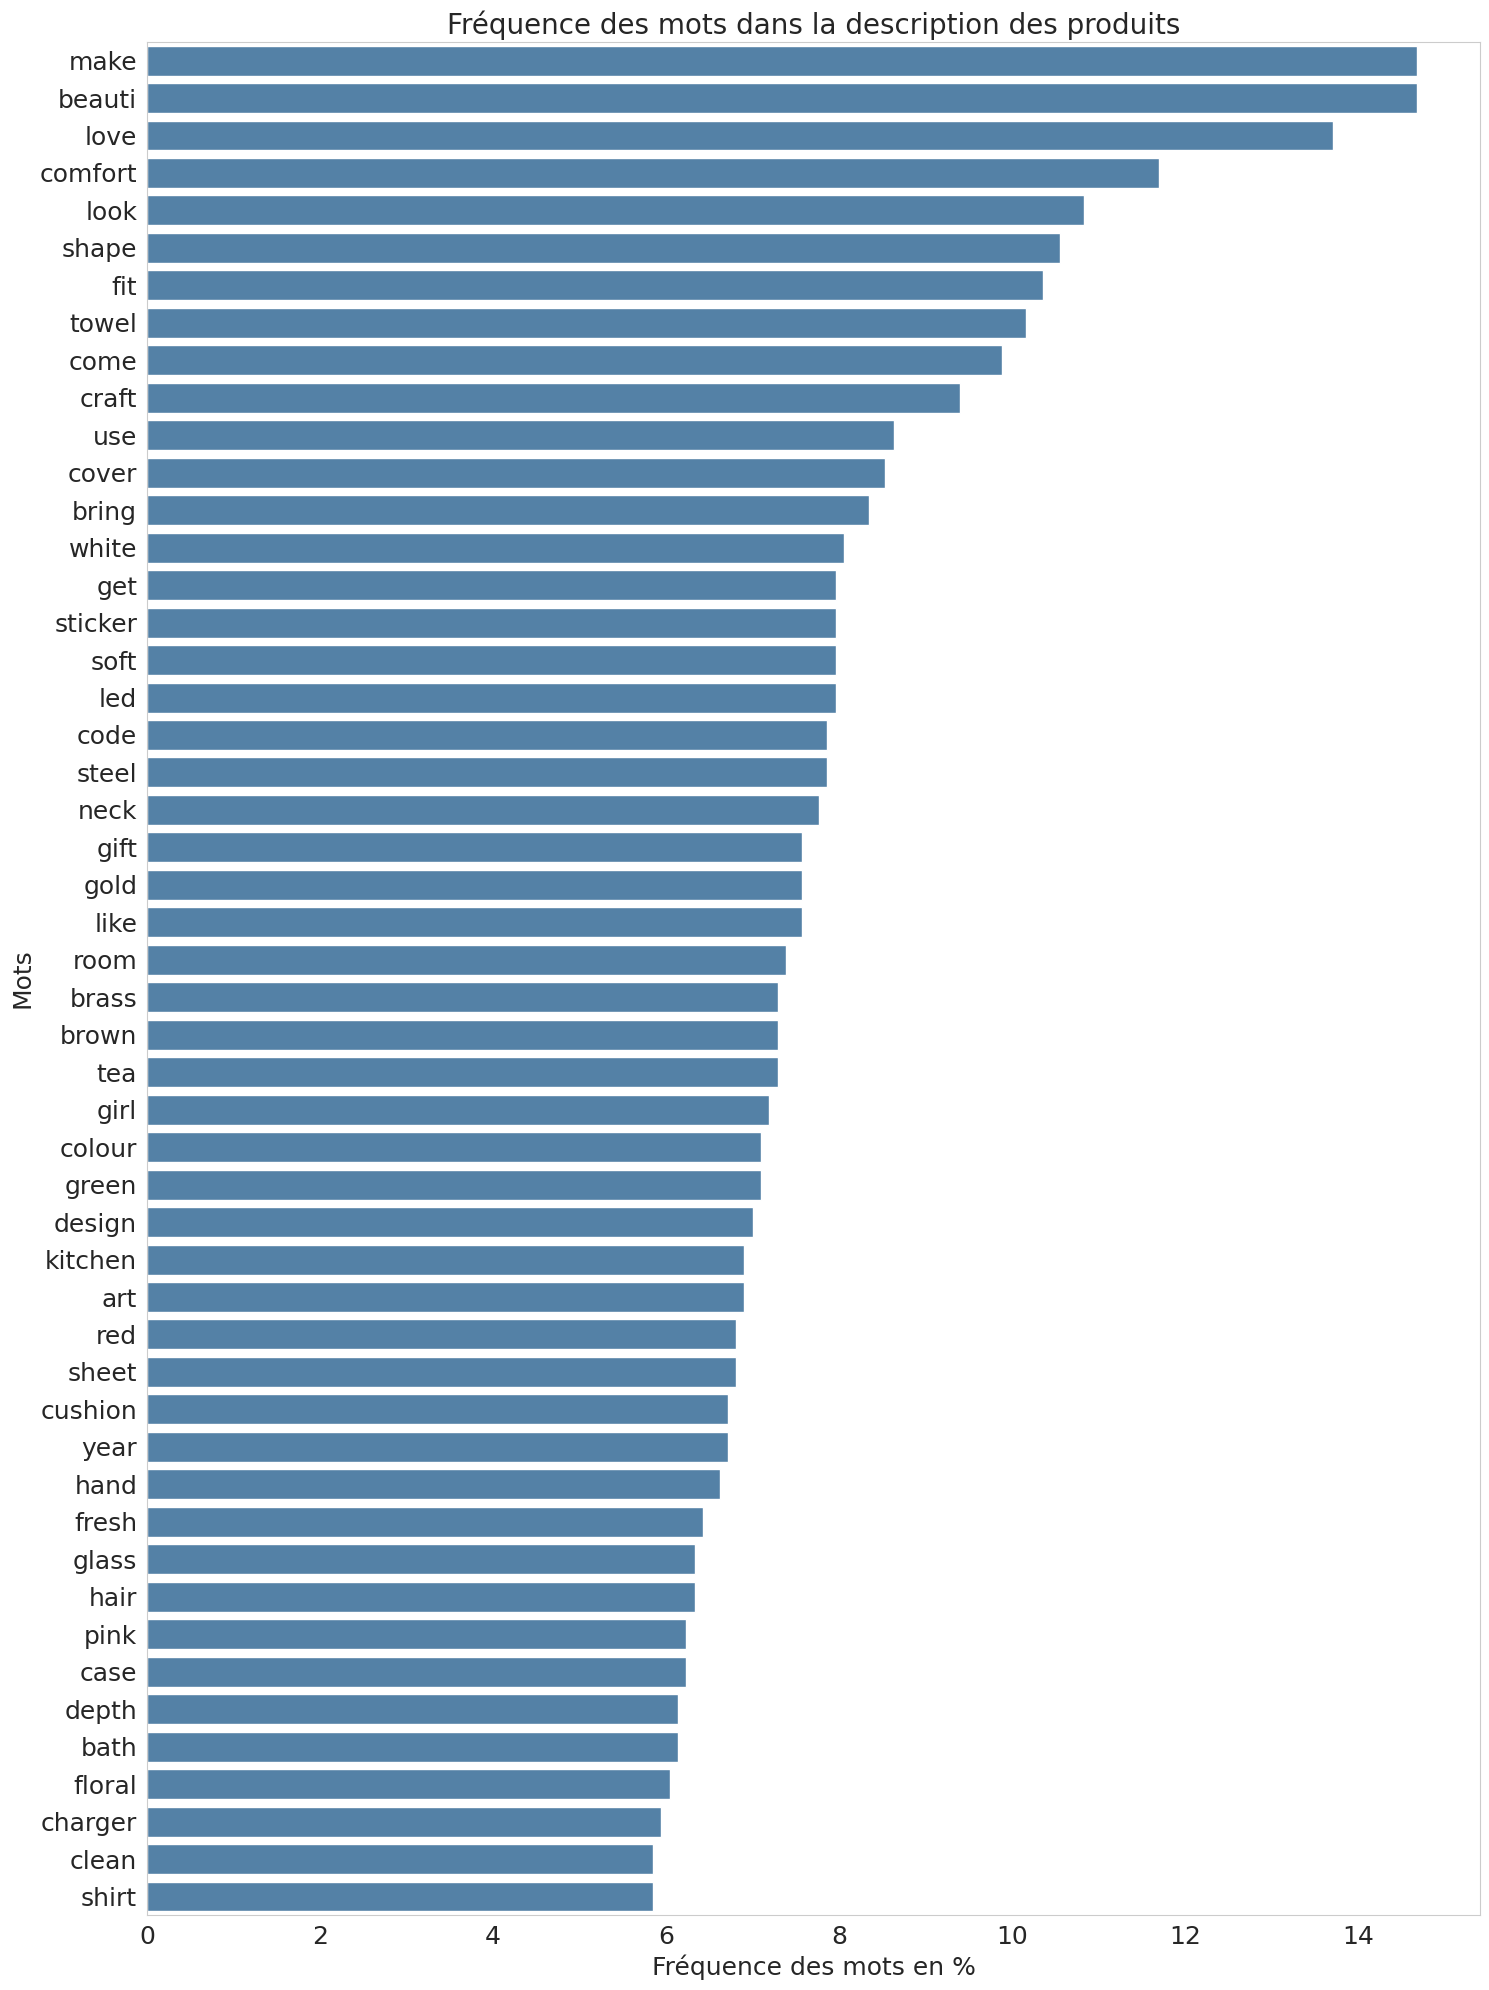

In [62]:
# Visualisation des 50 mots les plus fréquents dans description
# ---------------------------------------------------------------------
# Barplot de répartition
data_visu = df_freq_clean.head(50)
# Préparation de la liste des 50 mots les plus fréquents
liste_50_mots_desc = data_visu['Mot'].to_list()
sns.set_style("whitegrid")
plt.figure(figsize=(15, 20))
sns.barplot(x=data_visu['%_frequence'],
            y=data_visu['Mot'],
            data=data_visu,
            color='SteelBlue')
plt.title('Fréquence des mots dans la description des produits',
          fontsize=20)
plt.xlabel('Fréquence des mots en %', fontsize=18)
plt.ylabel('Mots', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.show()

## <span style='background:#33B5FF'>5 Feature extraction - Words embeddings </span>

- L’hypothèse de distribution en linguistique est dérivée de la théorie sémantique de l'usage de la langue, c'est-à-dire que les mots utilisés et utilisés dans les mêmes contextes ont tendance à avoir des significations similaires.
- Le word embedding repose sur une découverte : la régularité de certains rapports qui permettent de jouer le sens par un calcul vectoriel.
- Le monde du machine learning apporte une innovation remarquable : la **vectorisation**. 
- Le principe est simple. À partir de la matrice termes-document, on peut aisément construire des tables de corrélations entre les termes. L’idée est de représenter ces corrélations le plus précisément possible pour garder toute l'information dans un espace de dimension arbitrairement grande. L’idée est moins de réduire que de conserver l’information et le choix est de représenter chaque terme dans un espace de 100 à 1000 dimensions.
- L'astuce est le sac de mot (bag of words). Un petit ou un grand ? Considère-t-on que deux termes sont similaires s’ils font partie d’un paquet de 5 mots ou de 40 mots ? C’est bien plus qu’une astuce, cela devient le paramètre de l’analyse, favoriser de petits sacs, c’est chercher les termes qui sont directement associés, de plus grands sacs permettent de mieux prendre en compte le contexte des termes. Le paramètre de la taille du sac traduit la stratégie de recherche : les compléments ou les contextes.
- Le words embeddings constitue les techniques traditionnelles et anciennes du NLP.

### <span style='background:#33B5FF'>5.1 BOW - Bags of words - CountVectorizer </span>

***Note*** :
***
- CountVectorizer convertit une collection de documents texte en une matrice de comptage de tokens : les occurrences des tokens dans chaque document. 
- Cette implémentation produit une représentation éparse, creuse du nombre de tokens.
- La fonction "count vectorizer" de la librairie scikit-learn de Python, fournit un index à chaque mot et génère un vecteur qui contient le nombre d'apparitions de chaque mot dans un morceau de texte.
- fit permet d'apprendre le vocabulaire d'un ensemble de textes.
- transform permet la transformation en un cadre de données pouvant être utilisé pour construire des modèles de machine learning.

**Hyperparamètres** :
- **stop_words** : Étant donné que CountVectorizer ne compte que les occurrences de chaque mot de son vocabulaire, des mots extrêmement courants comme " le ", " et ", etc. deviendront des caractéristiques très importantes alors qu'ils ajoutent peu de sens au texte. Votre modèle peut souvent être amélioré si vous ne tenez pas compte de ces mots. Les mots d'arrêt sont simplement une liste de mots que vous ne voulez pas utiliser comme caractéristiques. Vous pouvez définir le paramètre stop_words='english' pour utiliser une liste intégrée. Vous pouvez également définir stop_words comme une liste personnalisée. Ce paramètre a la valeur par défaut None.
- **ngram_range** : Un n-gram est juste une chaîne de n mots à la suite. Par exemple, la phrase 'I am Groot' contient les 2-grammes 'I am' et 'am Groot'. La phrase est elle-même un 3-gramme. Définissez le paramètre ngram_range=(a,b) où a est la taille minimale et b est la taille maximale des ngrams que vous voulez inclure dans vos caractéristiques. La plage ngram_range par défaut est (1,1).
- **min_df**, **max_df** : Ce sont les fréquences minimales et maximales des documents que les mots/n-grammes doivent avoir pour être utilisés comme caractéristiques. Si l'un ou l'autre de ces paramètres est défini comme un nombre entier, il sera utilisé comme limite au nombre de documents dans lesquels chaque caractéristique doit se trouver pour être considérée comme une caractéristique. Si l'un ou l'autre est défini comme un flottant, ce nombre sera interprété comme une fréquence plutôt qu'une limite numérique. min_df a la valeur 1 (int) par défaut et max_df a la valeur 1.0 (flottant) par défaut.
- **max_features** : Ce paramètre est assez explicite. Le CountVectorizer choisira les mots/caractéristiques qui apparaissent le plus fréquemment dans son vocabulaire et laissera tomber tout le reste.

Comme nous avons normalisé, nettoyé, supprimé les stopwords, les mots les plus fréquents et les mots les plus rares et préparer les variables lemmatisées et racinisées, nous utiliserons le constructeur par défaut sur les variables 'description' et 'produit_specification' lemmatisées ou racinisées.

In [63]:
# Variable dont on veut extraire les features
desc_data = data_work['description_clean']

In [64]:
# Instanciation
countvectorizer_desc = CountVectorizer()
# Tokenisation et création du vocabulaire
countvectorizer_desc.fit(desc_data)
# Résumé du vocabulaire
# print(desc_lem_vectorizer.get_feature_names()[0:10])
# print(desc_lem_vectorizer.vocabulary_)
# Encodage/Vectorisation
vector_countvectorizer_desc = \
    countvectorizer_desc.transform(desc_data)
# Résumé de la vectorisation
print(vector_countvectorizer_desc.shape)
# print(type(vector_desc_lem_vectorizer))
# Dataframe pour réduction de dimension
X_vector_cv_desc = vector_countvectorizer_desc.toarray()
df_countvectorizer_desc = pd.DataFrame(X_vector_cv_desc)

(1050, 1043)


In [65]:
# Matrice BOW de CountVectorizer description lemmatisée
df_bow_count_vect_desc = pd.DataFrame(X_vector_cv_desc,
                                            columns=countvectorizer_desc
                                            .get_feature_names_out())
df_bow_count_vect_desc['Categorie'] = data_work['Categorie_1']
print(df_bow_count_vect_desc.shape)
# df_bow_count_vect_desc_lemma

(1050, 1044)


### <span style='background:#33B5FF'>5.2 BOW - Bags of words - TfisfVectorizer </span>

- Une transformation tf-idf (term frequency-inverse document frequency), permet de pondérer les fréquences d’apparition des termes par leur nombre d’occurrences dans l’ensemble des documents.
- La pondération tf-idf permet de contrebalancer l’importance d’un mot utilisé très fréquemment dans tous les documents du corpus par rapport aux termes plus spécifiques à certains documents. 
- TF-IDF est un produit de deux parties :
    - TF (Term Frequency) - Elle est définie comme le nombre de fois qu'un mot apparaît dans une phrase donnée.
    - IDF (Inverse Document Frequency) - Il est défini comme le logarithme à la base e du nombre total de documents divisé par les documents dans lesquels le mot apparaît.
    - Une mesure possible est la suivante (Jones 1973) :

- Cette transformation permet de produire des premiers éléments d’analyses, au premier titre duquel apparaissent les nuages de mots (wordcloud) qui représentent la fréquence relative des termes et qui donnent une première idée des significations contenues dans le corpus.

[Source](https://hal.archives-ouvertes.fr/hal-02400308/document)

In [66]:
# Instanciation
tfidfvectorizer_desc = TfidfVectorizer()
# Tokenisation et création du vocabulaire
tfidfvectorizer_desc.fit(desc_data)
# Encodage/Vectorisation
vector_tfidfvectorizer_desc = \
    tfidfvectorizer_desc.transform(desc_data)
# Résumé de la vectorisation
print(vector_tfidfvectorizer_desc.shape)
# Dataframe pour réduction de dimension
X_vector_tfidf_desc = vector_tfidfvectorizer_desc.toarray()
df_tfidfvectorizer_desc = pd.DataFrame(X_vector_tfidf_desc)

(1050, 1043)


In [67]:
# Matrice BOW de tfIdfVectorizer description 
df_bow_tfidf_vect_desc = pd.DataFrame(vector_tfidfvectorizer_desc
                                            .todense(),
                                            columns=tfidfvectorizer_desc
                                            .get_feature_names_out())
df_bow_tfidf_vect_desc['Categorie'] = data_work['Categorie_1']
print(df_bow_tfidf_vect_desc.shape)
# df_bow_tfidf_vect_desc

(1050, 1044)


### <span style='background:#33B5FF'>5.3 Word2vec </span>

- Il s'agit d'un ensemble de modèles de réseaux de neurones développés par google qui ont pour but de représenter les mots dans l'espace vectoriel. 
- Ces modèles sont très efficaces et performants pour comprendre le contexte et la relation entre les mots. Les mots similaires sont placés près les uns des autres dans l'espace vectoriel, tandis que les mots dissemblables sont placés loin les uns des autres.
- Il existe deux modèles dans cette classe (un réseau de neurones à 3 couches : 1 couche d’entrée, 1 couche cachée, 1 couche de sortie) :
    - CBOW (Continuous Bag of Words) : Le réseau neuronal examine les mots environnants (disons 2 à gauche et 2 à droite) et prédit le mot qui se trouve entre les deux.
        - 1. La couche Embedding va transformer chaque mot du contexte en vecteur d’embedding. La matrice W de l’embedding sera apprise au fur et à mesure que le modèle s’entraîne. Les dimensions résultantes sont : (lot, context_size, embedding).
        - 2. Ensuite, la couche GlobalAveragePooling1D permet de sommer les différents embedding pour avoir une dimension en sortie (batch_size, embedding).
        - 3.Enfin, La couche Dense de taille « voc_size » permet de prédire le mot cible.
    - Skip-grams : Le réseau neuronal prend un mot et essaie ensuite de prédire les mots environnants.   
- Le réseau neuronal possède une couche d'entrée, une couche cachée et une couche de sortie pour s'entraîner sur les données et construire les vecteurs. 

[Source](https://towardsdatascience.com/different-techniques-to-represent-words-as-vectors-word-embeddings-3e4b9ab7ceb4)

**Hyperparametres**
- **min_count** = int - Ignore tous les mots dont la fréquence absolue totale est inférieure à cette valeur - (2, 100)
- **window** = int - La distance maximale entre le mot actuel et le mot prédit dans une phrase. Par exemple, les mots fenêtre à gauche et les mots fenêtre à gauche de notre cible - (2, 10)
- **size** = int - Dimensionnalité des vecteurs de caractéristiques. - (50, 300)
- **sample** = float - Le seuil pour configurer quels mots à haute fréquence sont aléatoirement sous-échantillonnés. Très influent. - (0, 1e-5)
- **alpha** = float - Le taux d'apprentissage initial - (0.01, 0.05)
- **min_alpha** = float - Le taux d'apprentissage diminuera linéairement jusqu'à min_alpha au fur et à mesure de l'apprentissage. Pour le définir : alpha - (min_alpha * epochs) ~ 0.00
- **negative** = int - Si > 0, un échantillonnage négatif sera utilisé, l'int pour negative spécifie combien de "mots de bruit" doivent être noyés. Si la valeur est 0, aucun échantillonnage négatif n'est utilisé. - (5, 20)
- **workers** = int - Utilisez ce nombre de threads pour entraîner le modèle (=entraînement plus rapide avec des machines multicœurs).
- **sg** : L'algorithme de formation, soit CBOW(0) ou skip gram(1). L'algorithme d'apprentissage par défaut est CBOW.

In [68]:
# Compte le nombre de coeur du processeur
cores = multiprocessing.cpu_count()
text_dim=300

In [69]:
# Description  word2vec a besoin d'une liste de liste
data_vec = data_work['description_clean']
data_work['description_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data_work['description_token'].copy()

In [70]:
def creer_vecteur_moyen_par_mot(data, text_dim, w2v_model):

    vect_moy = np.zeros((text_dim,), dtype='float32')
    num_words = 0.

    for word in data.split():
        if word in w2v_model.wv.key_to_index.keys():
            vect_moy = np.add(vect_moy, w2v_model.wv.get_index(word))
            num_words += 1.

    if num_words != 0.:
        vect_moy = np.divide(vect_moy, num_words)

    return vect_moy

In [71]:
def word2vec_vectorisation(data, text_dim, w2v_model):
    '''
    Vectorisation.
    Parameters
    ----------
    data : variable à vectoriser, obligatoire.
    text_dim : taille du vecteur, obligatoire.
    w2v_model : modèle Word2Vec entraîné, obligatoire.
    Returns
    -------
    w2v_vector : les words vectorisés.
    '''
    w2v_vector = np.zeros((data.shape[0], text_dim), dtype='float32')

    for i in range(len(data)):
        w2v_vector[i] = creer_vecteur_moyen_par_mot(
            data[i], text_dim, w2v_model)

    return w2v_vector

In [72]:
from gensim.models import Word2Vec
# Instanciation du modèle
w2v_model_desc = Word2Vec(min_count=20, window=3, vector_size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_desc.build_vocab(data_token,
                               progress_per=10000)
# Entraînement du modèle
w2v_model_desc.train(data_token,
                         total_examples=w2v_model_desc.corpus_count,
                         epochs=30, report_delay=1)
# Vectorisation
vector_w2v_desc = word2vec_vectorisation(data_vec, text_dim,
                                                        w2v_model_desc)
# Dataframe pour réduction de dimension
df_w2v_desc = pd.DataFrame(vector_w2v_desc)

**CBOW**

In [73]:
# Instanciation du modèle
w2v_model_prod = Word2Vec(min_count=20, window=3, vector_size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_prod.build_vocab(data_token,
                               progress_per=10000)
# Entraînement du modèle
w2v_model_prod.train(data_token,
                         total_examples=w2v_model_prod.corpus_count,
                         epochs=30, report_delay=1)
# Vectorisation
vector_w2v_prod = word2vec_vectorisation(data_vec,
                                                        text_dim,
                                                        w2v_model_prod)
# Dataframe pour réduction de dimension
df_w2v_prod = pd.DataFrame(vector_w2v_prod)

**Skip-gramm**

In [74]:
# Instanciation du modèle
w2v_model_prod_sg = Word2Vec(min_count=20, window=3, vector_size=text_dim,
                                 sample=6e-5, alpha=0.03, min_alpha=0.0007,
                                 negative=20, workers=cores-1, sg=1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_prod_sg.build_vocab(data_token,
                                  progress_per=10000)
# Entraînement du modèle
w2v_model_prod_sg.train(data_token,
                            total_examples=w2v_model_prod_sg.corpus_count,
                            epochs=30, report_delay=1)
# Vectorisation
vector_w2v_prod_sg = word2vec_vectorisation(data_vec, text_dim,
                                      w2v_model_prod_sg)
# Dataframe pour réduction de dimension
df_w2v_prod_sg = pd.DataFrame(vector_w2v_prod_sg)

## <span style='background:#33B5FF'>6 Réduction de dimension </span>

Les matrices issues de l'extraction des features pour les words embeddings sont des matrices denses et creuses avec une grande dimension. La réduction de dimension permettera de trouver de nouvelles features qui représenteront les features initiales améliorant les temps de calcul.

### <span style=''>6.1 ACP </span>

In [75]:
from sklearn import decomposition

#### <span style='background:#33B5FF'>6.1.1 BOW - CountVectorizer</span>

In [76]:
def display_scree_plot_red(pca):
    '''
    Affiche l'éboulis des valeurs propres.
    Parameters
    ----------
    pca : pca decompostion, obligatoire.
    Returns
    -------
    None.
    '''
    taux_var_exp = pca.explained_variance_ratio_
    scree = taux_var_exp * 100
    sns.set_style('white')

    plt.bar(np.arange(len(scree)) + 1, scree, color='SteelBlue')
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(scree)) + 1, scree.cumsum(), c='red', marker='o')
    ax2.set_ylabel('Taux cumulatif de l\'inertie')
    ax1.set_xlabel('Rang de l\'axe d\'inertie')
    ax1.set_ylabel('Pourcentage d\'inertie')
    plt.title('Eboulis des valeurs propres')
    plt.gcf().set_size_inches(8, 6)
    plt.grid(False)
    plt.show(block=False)


In [77]:
def reduire_dimension_acp(matrice, n_components=0):
    '''
    Analyse en composante principale
    Parameters
    ----------
    matrice : Variable à analyser, obligatoire
    n_components : nombre de composants pour la réduction de dimension
    exemple :  PC1/PC2 et PC3/PC4 ==> [(0, 1), (2, 3)], obligatoire
    affiche_graph : affiche les autres graphiques ; éboulis, distribution...
    Returns
    -------
    None.
    '''
    # Sélection des colonnes pour l'ACP
    cols_acp = matrice.columns.to_list()
    # Nombre de composantes
    if n_components == 0:
        n_comp = len(cols_acp)
    else:
        n_comp = n_components

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(matrice)

    # quel est le pourcentage de variance préservé par chacune de
    # nos composantes?
    variances = pca.explained_variance_ratio_

    # quelle est la somme cumulée de chacune de ces variances?
    meilleur_dims = np.cumsum(variances)

    plt.figure(figsize=(8, 4))

    # on va trouver le moment où on atteint 95% ou 99% entre réduire au maxi
    # où garder au maxi
    plt.plot(meilleur_dims)

    # argmax pour > 90 %
    best90 = np.argmax(meilleur_dims > 0.9)
    plt.axhline(y=0.9, color='Orange')
    plt.text(2, 0.91, '>90%', color='Orange', fontsize=10)
    plt.axvline(x=best90, color='Orange')

    # argmax pour > 95 %
    best = np.argmax(meilleur_dims > 0.95)
    plt.axhline(y=0.95, color='r')
    plt.text(2, 0.96, '>95%', color='r', fontsize=10)
    plt.axvline(x=best, color='r')

    plt.title('Taux cumulé de variances expliquées pour les composantes')
    plt.xlabel('Nombre de composantes')
    plt.ylabel('Taux cumulé des variances')
    plt.grid(False)
    plt.show()

    display(f'Nombre de composantes expliquant 90% de la variance : {best90}')
    display(f'Nombre de composantes expliquant 95% de la variance : {best}')

    # Affichage du graphique des éboulis des valeurs propres
    display_scree_plot_red(pca)


In [78]:
seed = 21

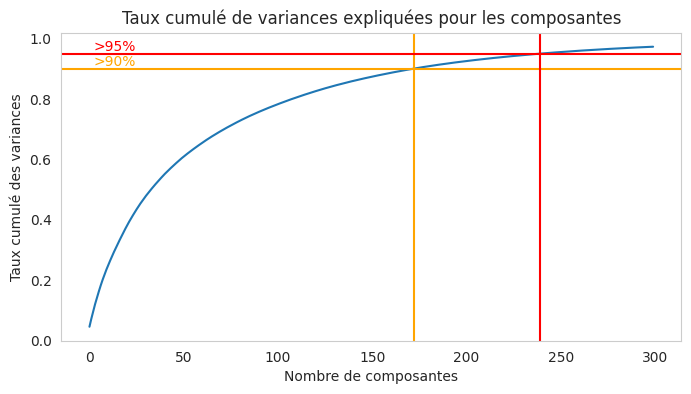

'Nombre de composantes expliquant 90% de la variance : 172'

'Nombre de composantes expliquant 95% de la variance : 239'

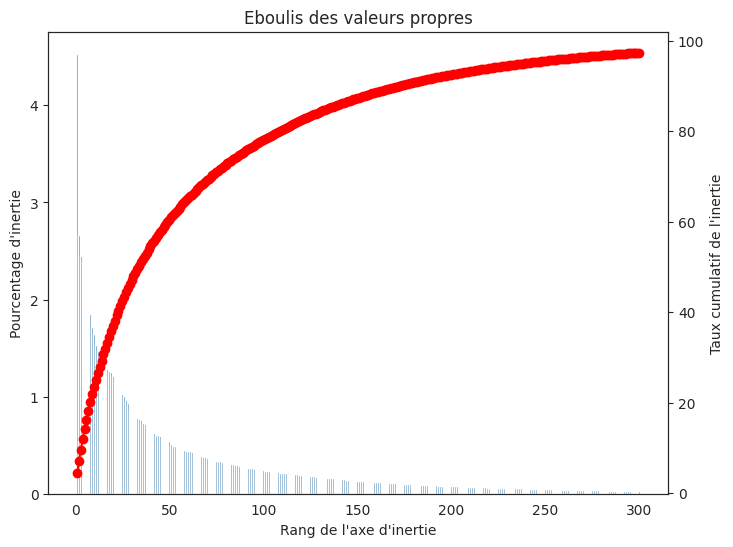

In [79]:
# Analyse en composante principale
liste_tuples_comp = [(0, 1)]
reduire_dimension_acp(df_countvectorizer_desc, 300)

In [80]:

# ACP avec 172 composantes expliquants 90% de la variance
n_comp = 172
pca_cv_desc = PCA(n_components=n_comp, random_state=seed)
pca_cv_desc.fit(df_countvectorizer_desc)
X_proj_acp_cv_desc = pca_cv_desc.transform(df_countvectorizer_desc)
# Dataframe pour clustering
df_acp_cv_desc = pd.DataFrame({'VAR1' : X_proj_acp_cv_desc[:, 0],
                                   'VAR2': X_proj_acp_cv_desc[:, 1],
                                   'CATEGORIE' : data_work['Categorie_1']})

In [81]:
def affiche_correlation_circle(pcs, pca, labels, axis_ranks=[(0, 1)],
                               long=6, larg=6):
    ''' Affiche les graphiques de cercle de corrélation de l'ACP pour les
        différents plans factoriels.
        Parameters
        ----------------
        pcs : PCA composants, obligatoire.
        labels : nom des différentes composantes, obligatoire.
        axis_ranks : liste de tuple de plan factoriel (0, 1) par défaut.
        long : longueur de la figure, facultatif (8 par défaut).
        larg : largeur de la figure, facultatif (8 par défaut).
        Returns
        ---------------
        None
    '''
    for i, (d1, d2) in enumerate(axis_ranks):

        fig, axes = plt.subplots(figsize=(long, larg))

        for i, (x_value, y_value) in enumerate(zip(pcs[d1, :], pcs[d2, :])):
            if(x_value > 0.2 or y_value > 0.2):
                plt.plot([0, x_value], [0, y_value], color='k')
                plt.text(x_value, y_value, labels[i], fontsize='14')

        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='k')
        axes.set_aspect(1)
        axes.add_artist(circle)

        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        plt.xlim([-1, 1])
        plt.ylim([-1, 1])

        # nom des axes, avec le pourcentage d'inertie expliqué
        axes.set_xlabel(
            'PC{} ({}%)'.format(
                d1 +
                1,
                round(
                    100 *
                    pca.explained_variance_ratio_[d1],
                    1)),
            fontsize=16)
        axes.set_ylabel(
            'PC{} ({}%)'.format(
                d2 +
                1,
                round(
                    100 *
                    pca.explained_variance_ratio_[d2],
                    1)),
            fontsize=16)
        axes.set_title('PCA correlation circle (PC{} and PC{})'.format(
            d1 + 1, d2 + 1), fontsize=18)

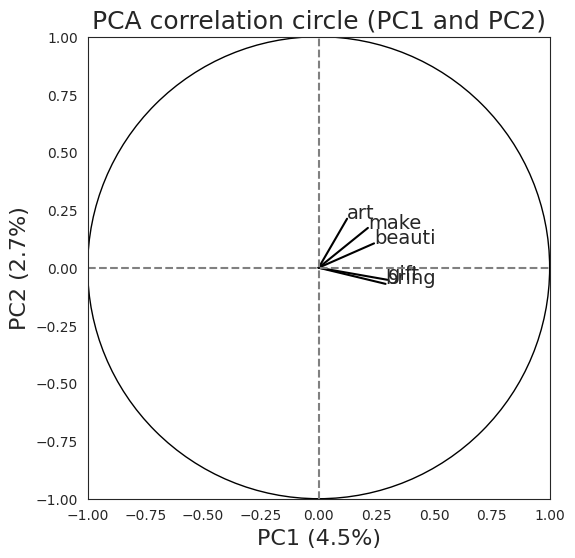

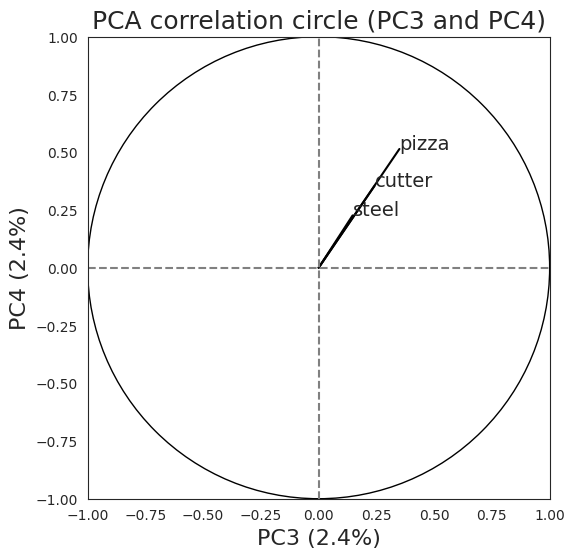

In [82]:
affiche_correlation_circle(pca_cv_desc.components_,
                                      pca_cv_desc,
                                      countvectorizer_desc
                                      .get_feature_names_out(),
                                      [(0, 1), (2, 3)])

In [83]:
def affiche_projections_reducdim(
        dataframe,
        X_projection,
        x_label,
        y_label,
        titre):

    # Constitution du dataframe de travail
    dataframe_work = pd.DataFrame()
    dataframe_work['VAR1'] = X_projection[:, 0]
    dataframe_work['VAR2'] = X_projection[:, 1]
    dataframe_work['CATEGORIE'] = dataframe['Categorie_1']

    # VIsualisation des 2 premières composantes
    plt.figure(figsize=[25, 15])

    sns.set_palette('Paired')
    sns.scatterplot(x='VAR1', y='VAR2', data=dataframe_work, hue='CATEGORIE',
                    s=100, alpha=1)
    plt.title(titre, fontsize=40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=34)
    plt.xlabel(x_label, fontsize=34)
    plt.ylabel(y_label, fontsize=34)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.show()

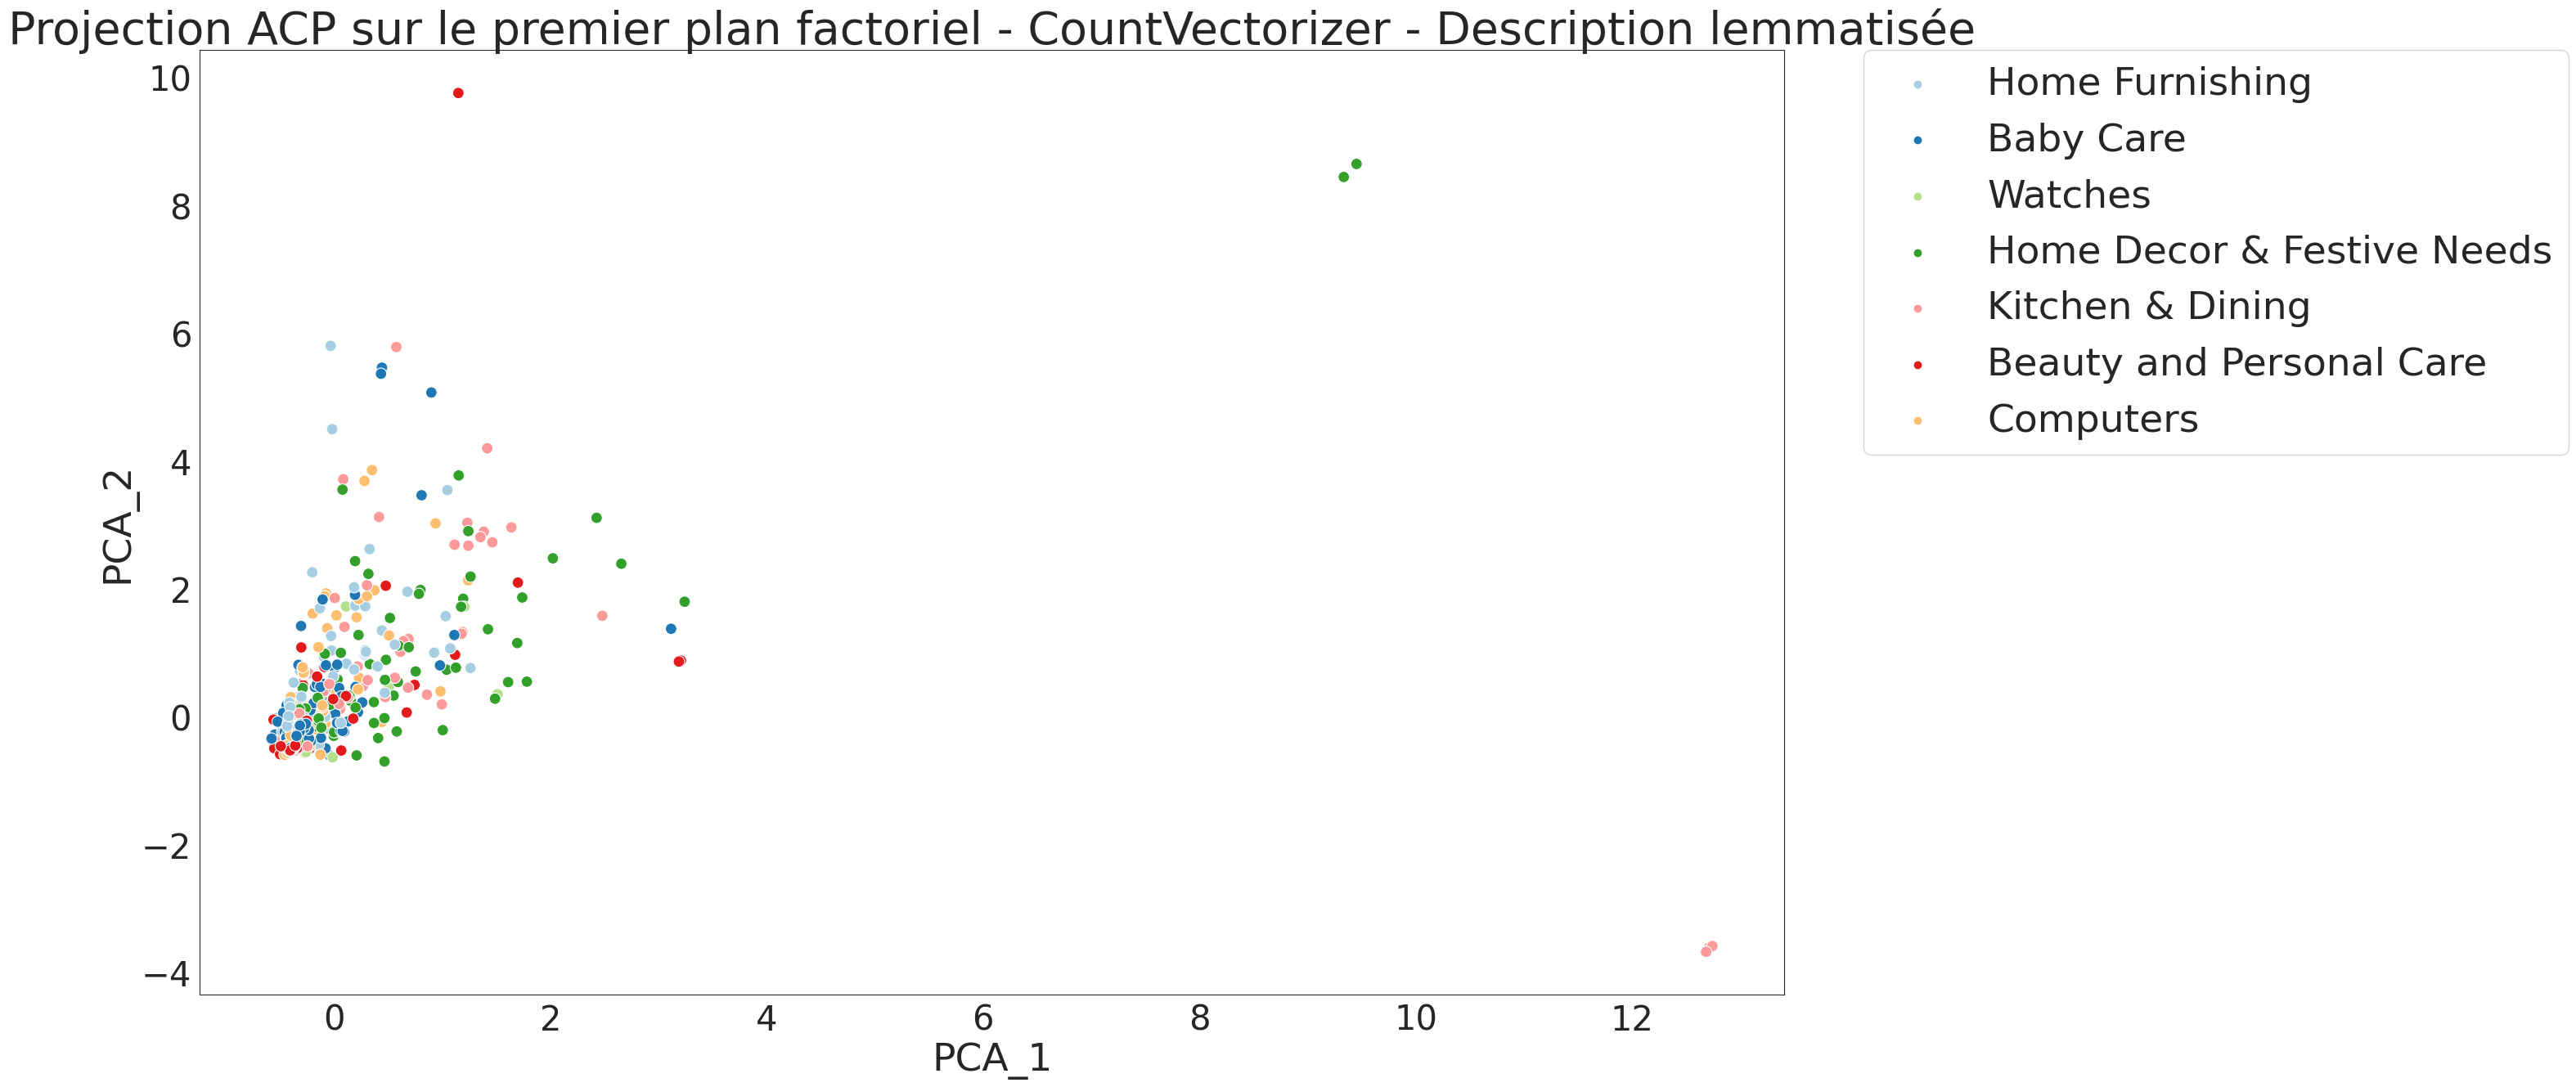

In [84]:
# Visulisation de la projection des 2 premiers plans factoriels
titre = 'Projection ACP sur le premier plan factoriel - CountVectorizer'
titre_1 = titre + ' - Description lemmatisée'
affiche_projections_reducdim(data_work, X_proj_acp_cv_desc,
                                        'PCA_1', 'PCA_2', titre_1)

#### <span style='background:#33B5FF'>6.1.2 BOW - TfidfVectorizer</span>

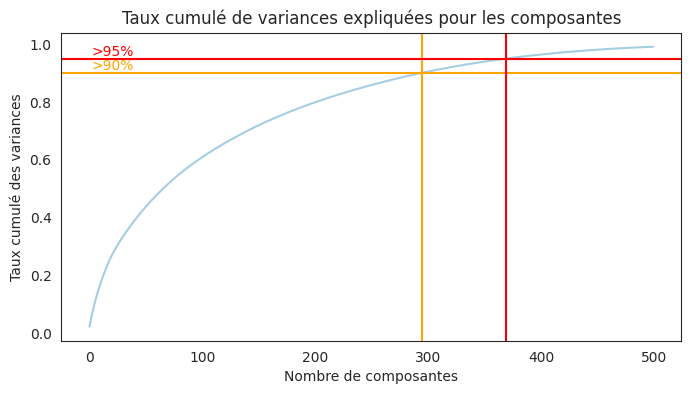

'Nombre de composantes expliquant 90% de la variance : 294'

'Nombre de composantes expliquant 95% de la variance : 369'

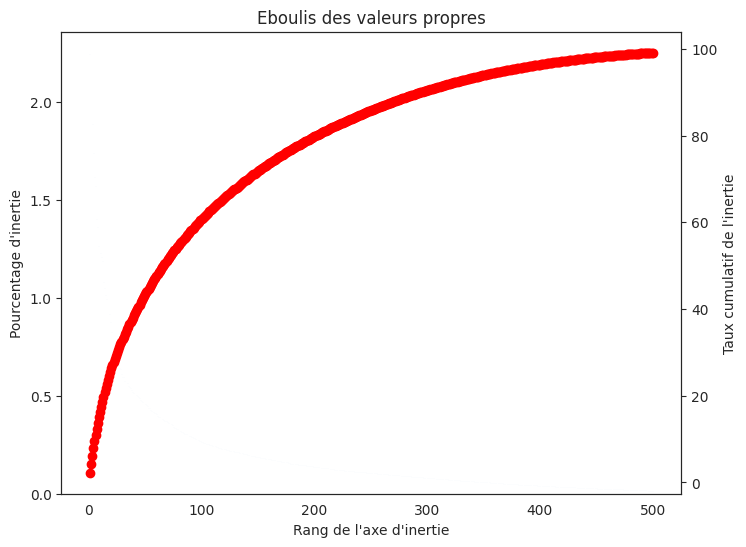

In [85]:
# Analyse en composante principale
liste_tuples_comp = [(0, 1)]
reduire_dimension_acp(df_tfidfvectorizer_desc, 500)

In [86]:
# ACP avec 294 composantes expliquants 90% de la variance
n_comp_5 = 369
pca_tfidf_desc = PCA(n_components=n_comp_5, random_state=seed)
pca_tfidf_desc.fit(df_tfidfvectorizer_desc)
X_proj_acp_tfidf_desc = \
    pca_tfidf_desc.transform(df_tfidfvectorizer_desc)
# Dataframe pour clustering
df_acp_tfidf_desc = pd.DataFrame({'VAR1' : X_proj_acp_tfidf_desc[:, 0],
                                      'VAR2': X_proj_acp_tfidf_desc[:, 1],
                                      'CATEGORIE' : data_work['Categorie_1']})

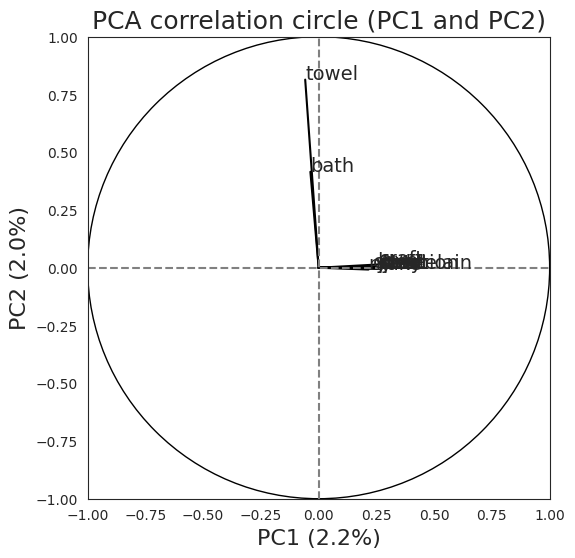

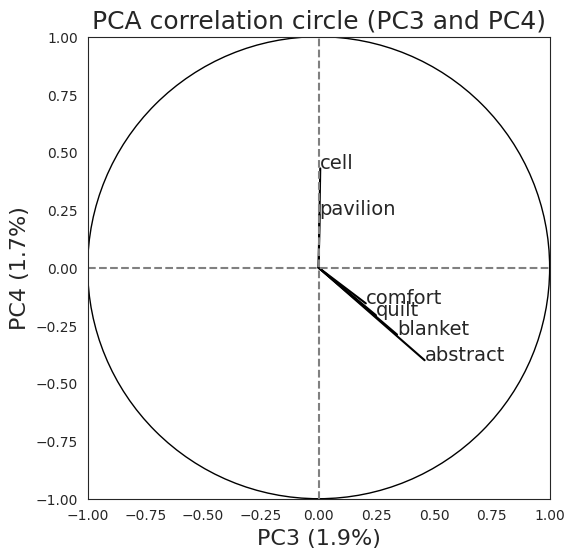

In [87]:
affiche_correlation_circle(pca_tfidf_desc.components_,
                                      pca_tfidf_desc,
                                      tfidfvectorizer_desc
                                      .get_feature_names_out(),
                                      [(0, 1), (2, 3)])

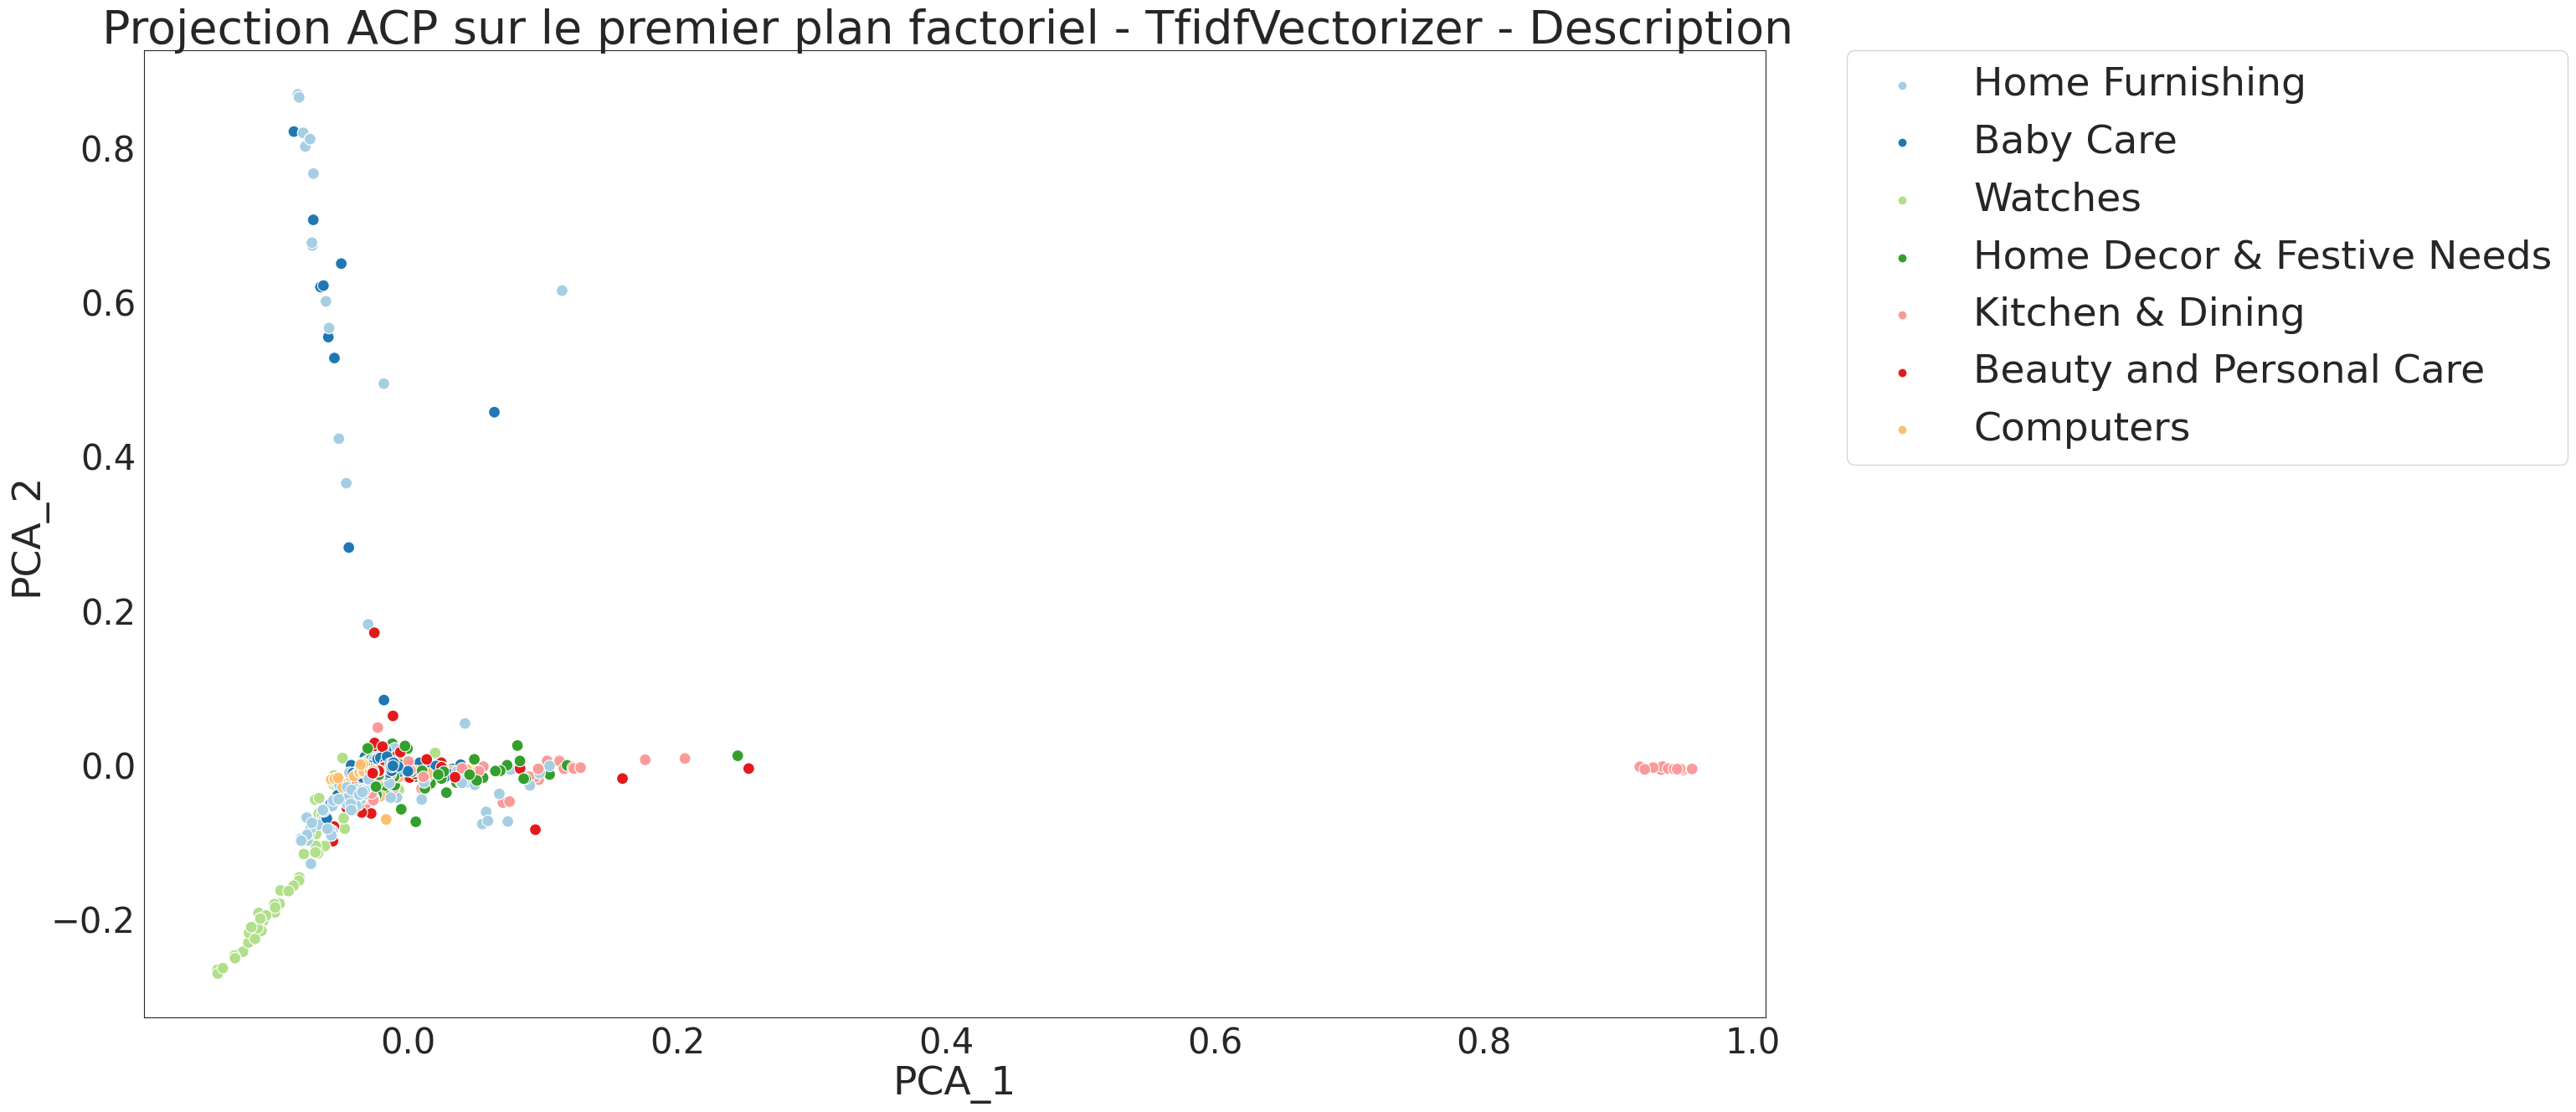

In [88]:
# Visulisation de la projection des 2 premiers plans factoriels
titre_tf = 'Projection ACP sur le premier plan factoriel - TfidfVectorizer'
titre_5 = titre_tf + ' - Description '
affiche_projections_reducdim(data_work, X_proj_acp_tfidf_desc,
                                        'PCA_1', 'PCA_2', titre_5)

### <span style=''>6.2 TSNE </span>

#### <span style=''>6.2.1 BOW - CountVectorizer </span>

In [89]:
def affiche_tsne(results_list, liste_param, alpha=0.1):
    '''
    Affiche les résultats de la transformation Lt-SNE
    Parameters
    ----------
    results_list : iste des résultats de la transformation t-SNE, obligatoire.
    liste_param : liste des valeurs de l'hyper paramètre perplexity testées,
                  obligatoire.
    Returns
    -------
    None.
    '''
    i = 0

    # Visualisation en 2D des différents résultats selon la perplexité
    plt.subplots(3, 2, figsize=[15, 20])

    for resultat_tsne in results_list:

        # Perplexité=5
        plt.subplot(3, 2, i + 1)
        tsne_results_i = results_list[i]
        sns.scatterplot(x=tsne_results_i[:, 0], y=tsne_results_i[:, 1],
                        alpha=alpha)
        plt.title('t-SNE avec perplexité=' + str(liste_param[i]))
        plt.grid(False)
        plt.plot()

        i += 1

    plt.show()


In [90]:
import time
# t-SNE tuning du paramètre perplexity sans initialisation PCA
top_depart = time.time()
liste_param = [5, 10, 20, 30, 40, 50]
results_cv_desc = list()
tsne_results_cv_desc = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=seed)
    tsne_results_cv_desc = tsne.fit_transform(df_countvectorizer_desc)
    results_cv_desc.append(tsne_results_cv_desc)
print('t-SNE terminée! en : {} seconds'.format(time.time()-top_depart))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.710350
[t-SNE] KL divergence after 500 iterations: 0.801100
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.414024
[t-SNE] KL divergence after 500 iterations: 0.900181
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.0

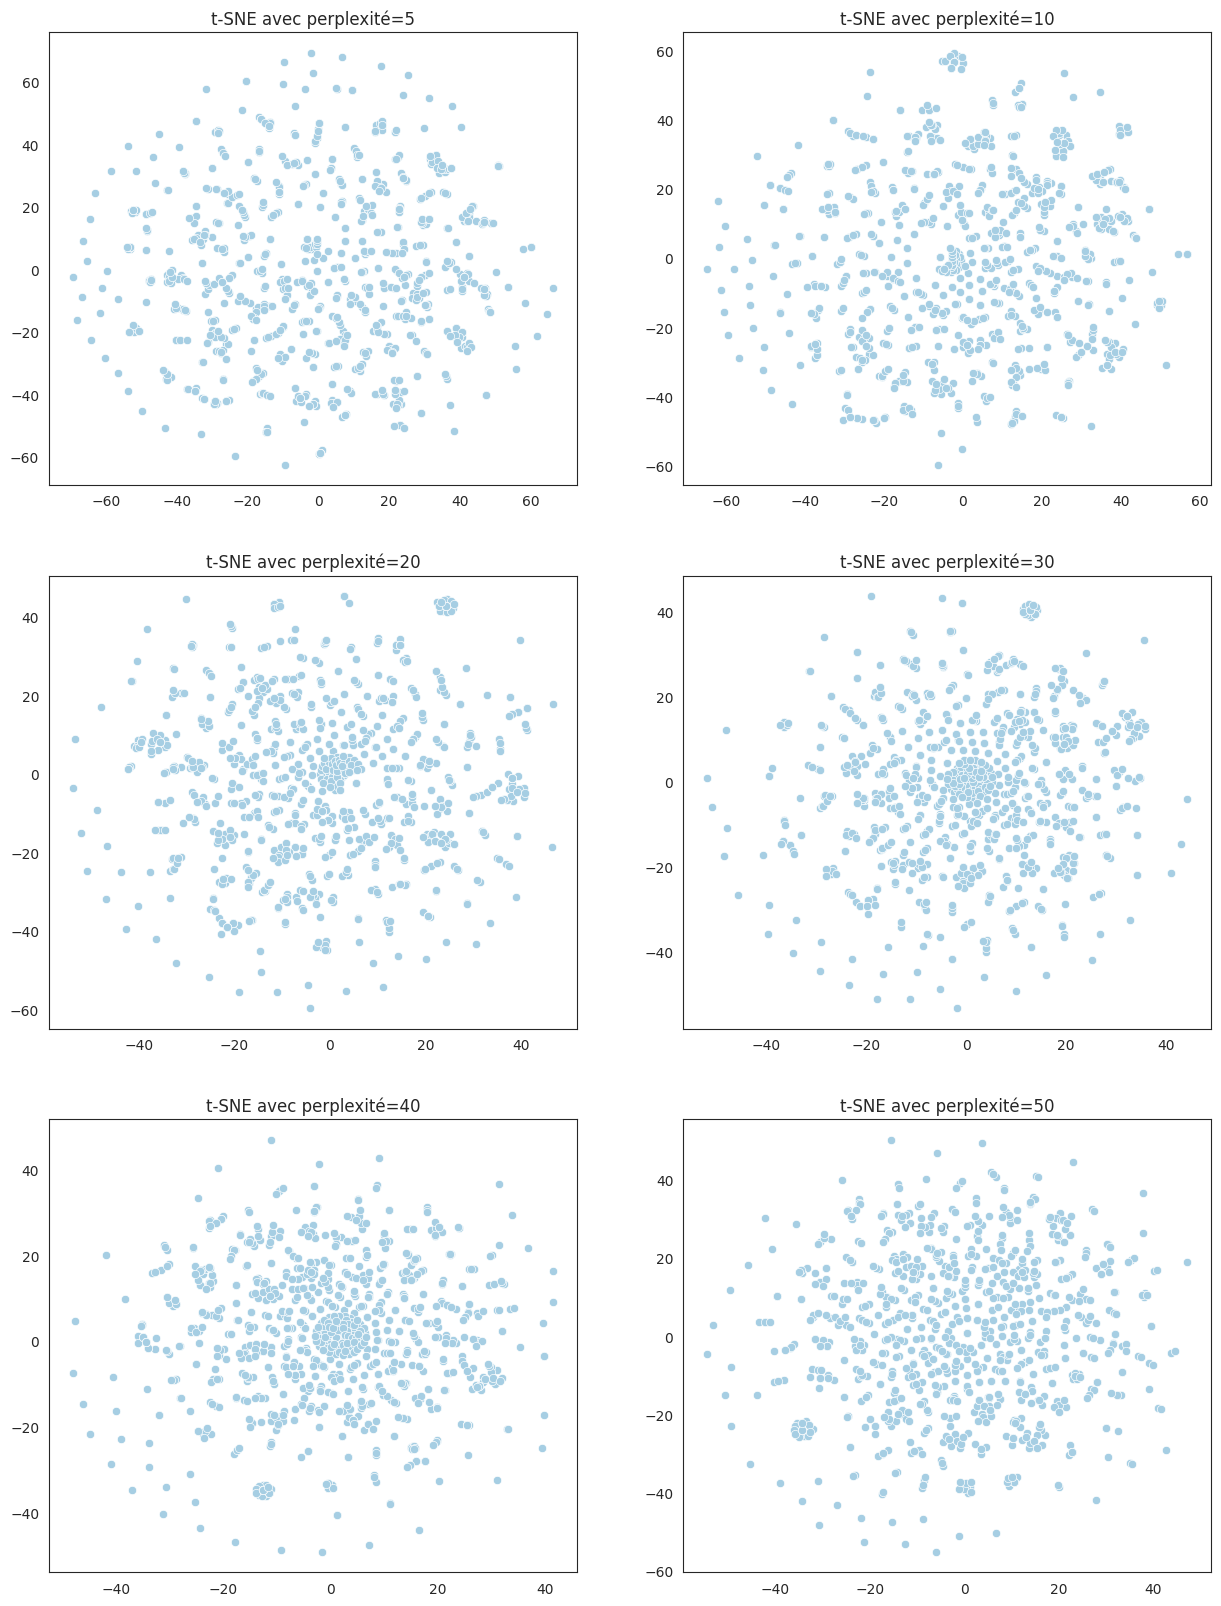

In [91]:
# Visualisation en 2D des différents résultats selon la perplexité
affiche_tsne(results_cv_desc, liste_param, 1)

In [92]:
# Réduction de dimension tsne
tsne_cv_desc = TSNE(verbose=1, perplexity=10 , init='random')
X_proj_tsne_cv_desc = tsne_cv_desc.fit_transform(vector_countvectorizer_desc)
# Dataframe pour clustering
df_tsne_cv_desc = pd.DataFrame({'VAR1' : X_proj_tsne_cv_desc[:, 0],
                                    'VAR2': X_proj_tsne_cv_desc[:, 1],
                                    'CATEGORIE' : data_work['Categorie_1']})

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.471031
[t-SNE] KL divergence after 1000 iterations: 0.874554


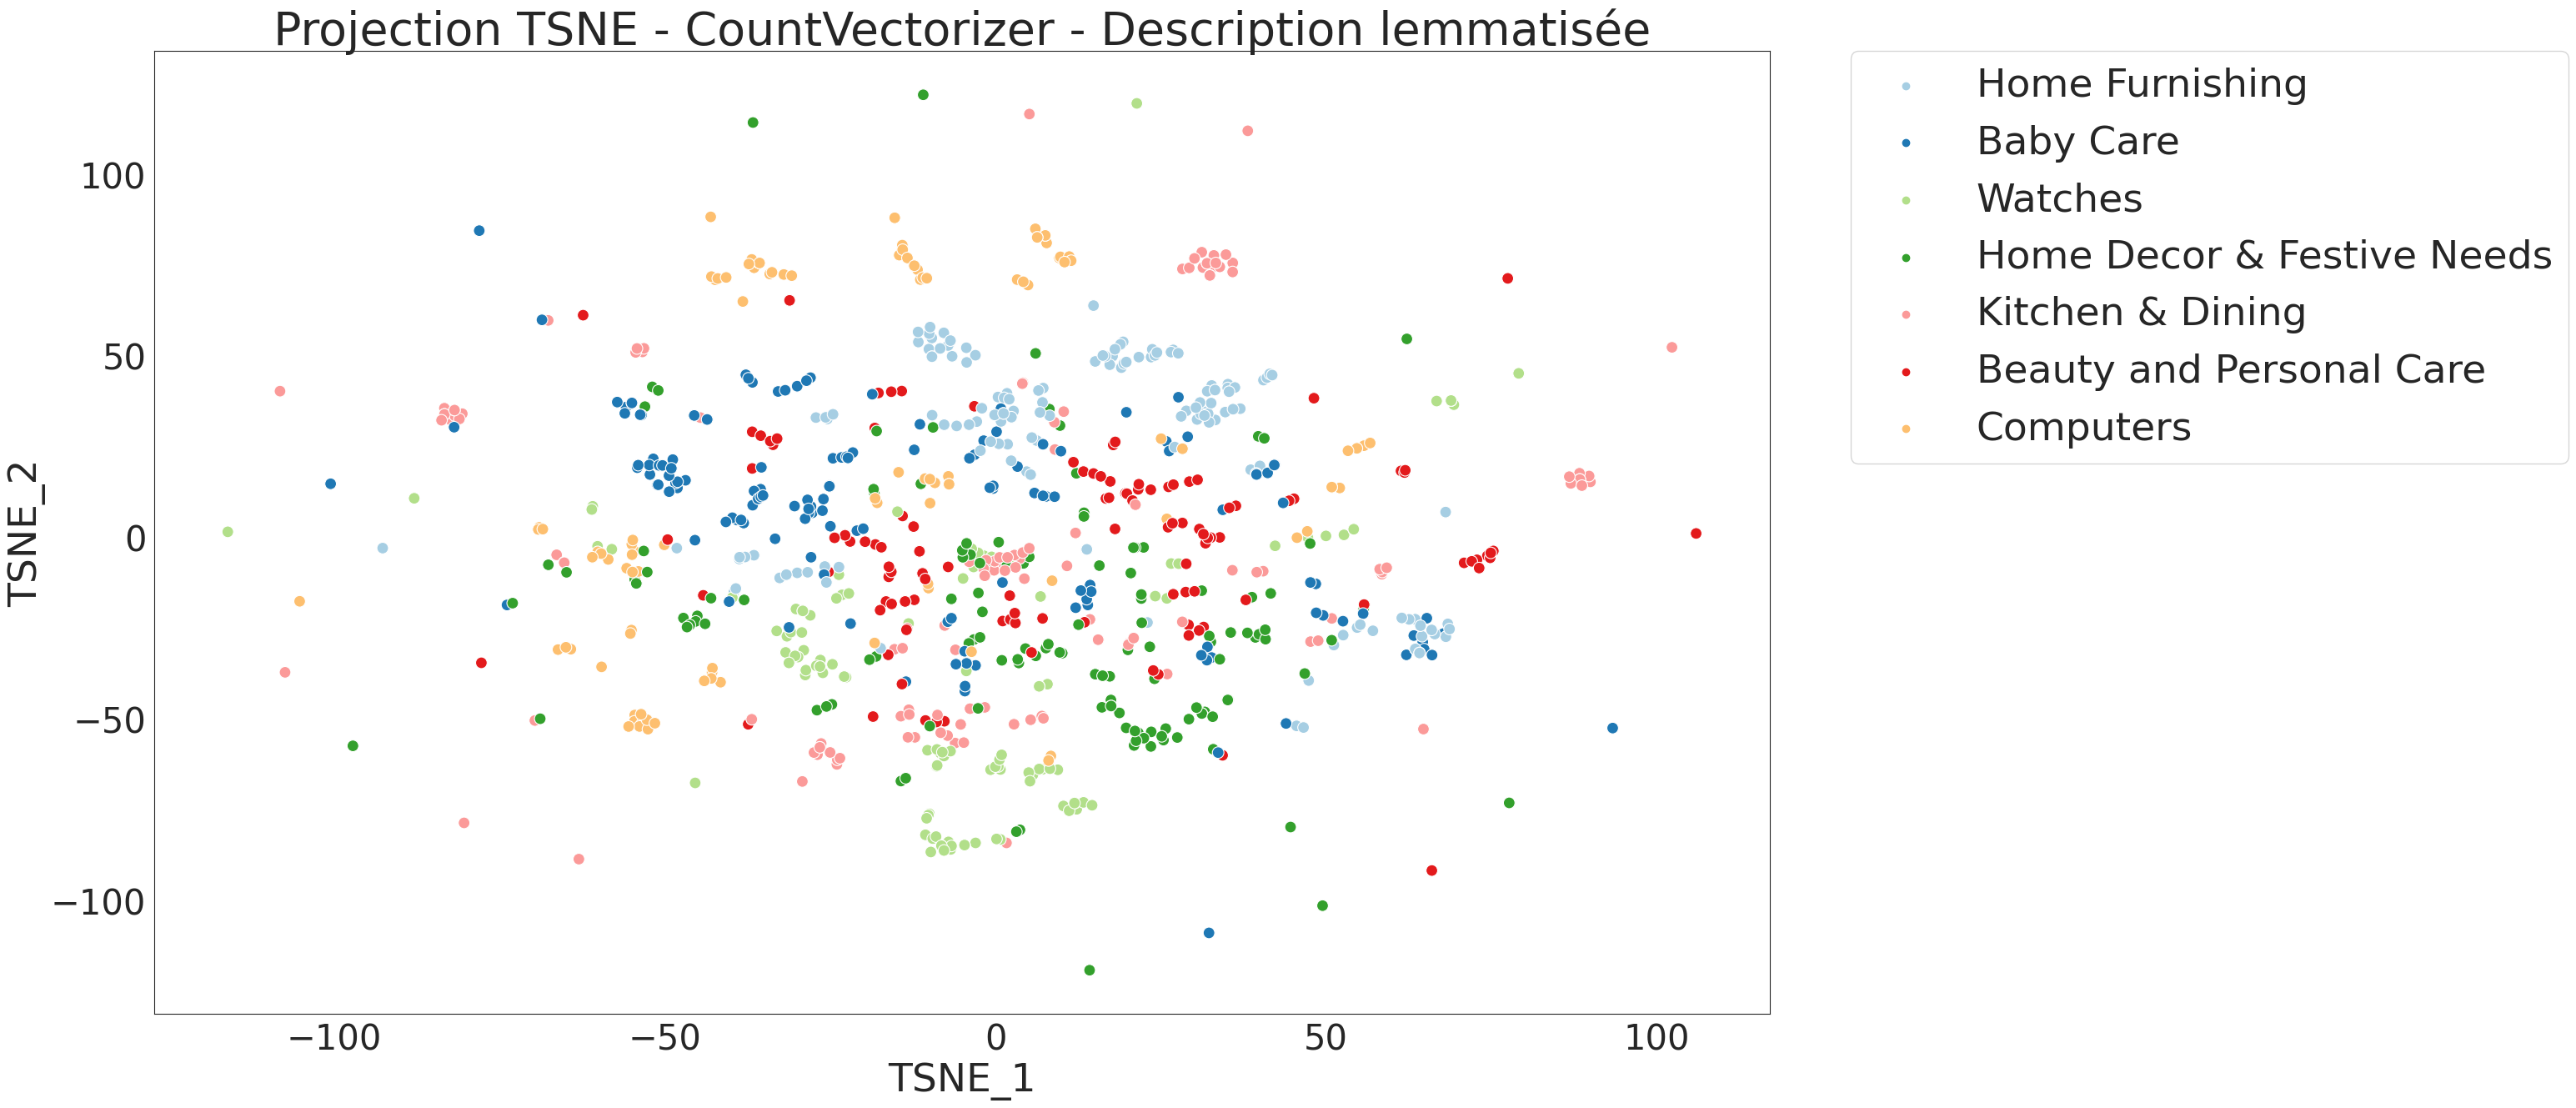

In [93]:
# Visulisation de la projection des 2 premiers variables TSNE
titre_tf = 'Projection TSNE - CountVectorizer'
titre_tf_1 = titre_tf + ' - Description lemmatisée'
affiche_projections_reducdim(data_work, X_proj_tsne_cv_desc,
                                        'TSNE_1', 'TSNE_2', titre_tf_1)

#### <span style=''>6.2.2 BOW - TfidfVectorizer </span>

In [94]:
# t-SNE tuning du paramètre perplexity sans initialisation PCA
top_depart = time.time()
liste_param = [5, 10, 20, 30, 40, 50]
results_tfidf_desc = list()
tsne_results_tfidf_desc = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=seed,init="random")
    tsne_results_tfidf_desc = tsne.fit_transform(vector_tfidfvectorizer_desc)
    results_tfidf_desc.append(tsne_results_tfidf_desc)
print('t-SNE terminée! en : {} seconds'.format(time.time()-top_depart))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.683693
[t-SNE] KL divergence after 500 iterations: 0.840400
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.765846
[t-SNE] KL divergence after 500 iterations: 0.881013
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.1

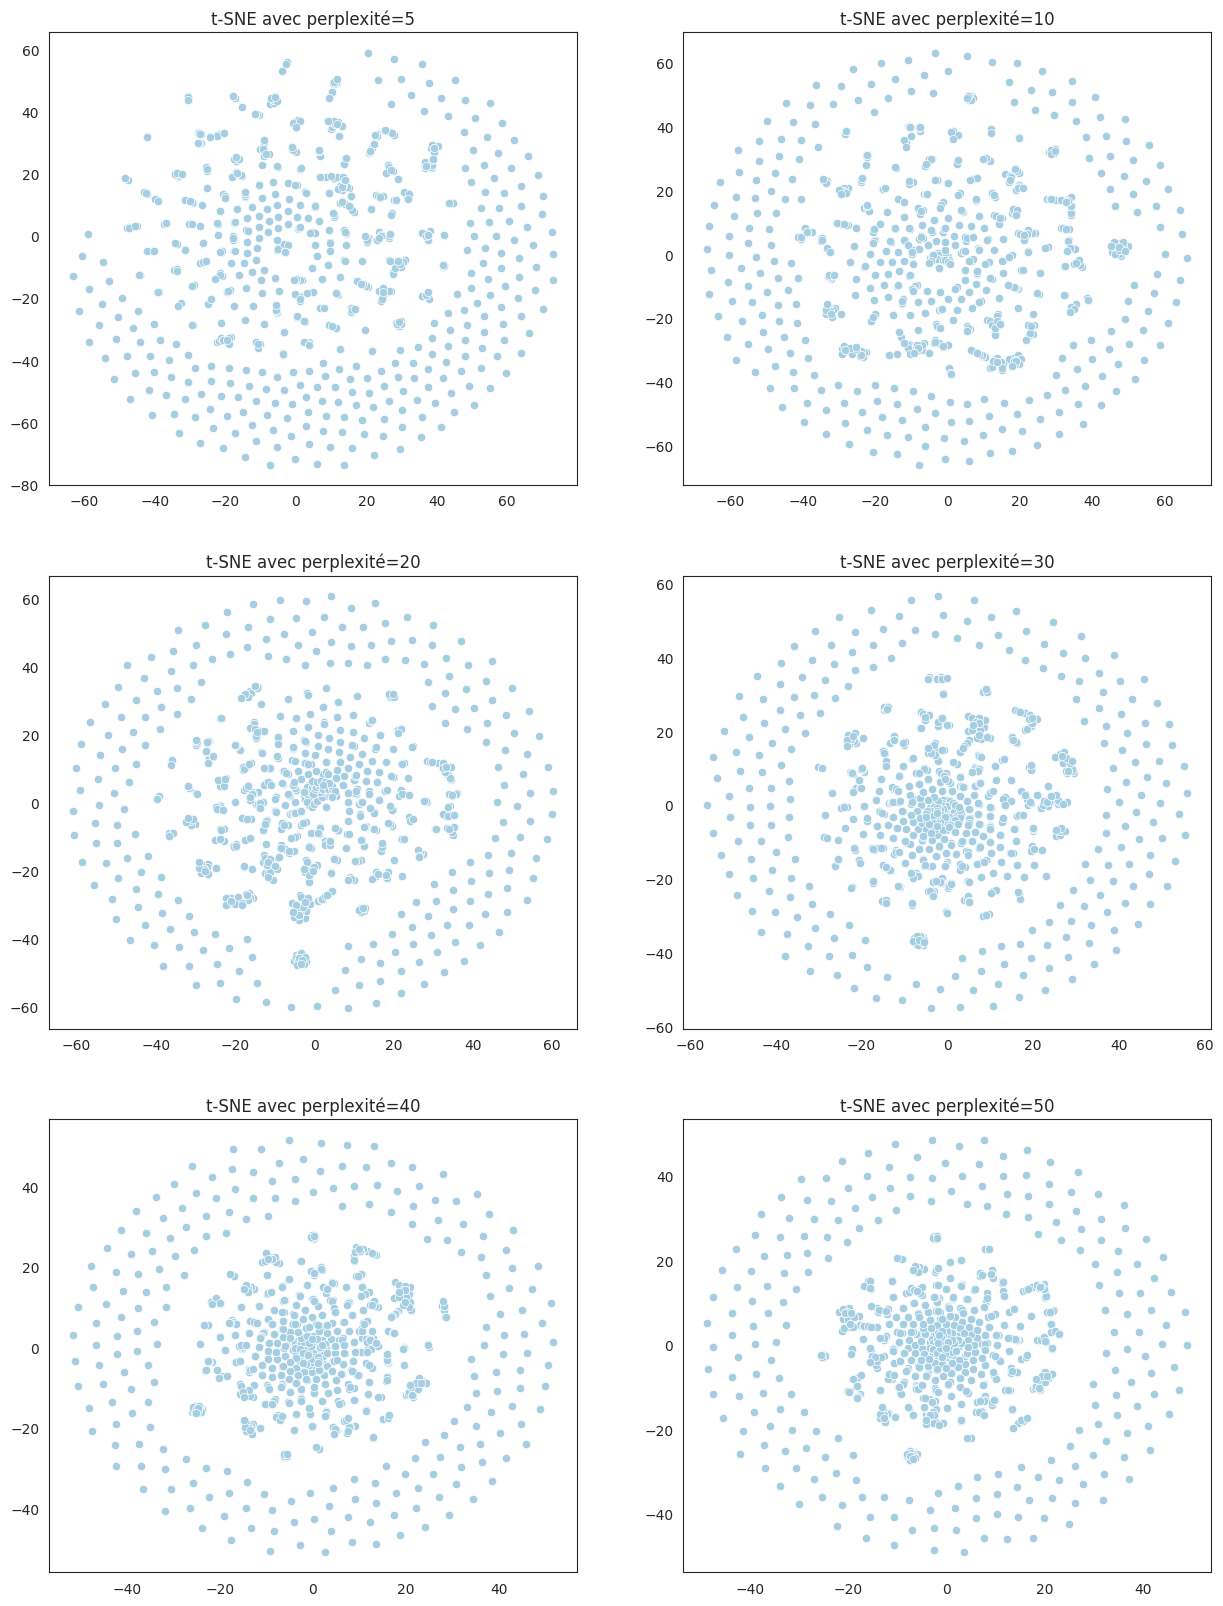

In [95]:
# Visualisation en 2D des différents résultats selon la perplexité
affiche_tsne(results_tfidf_desc, liste_param, 1)

In [96]:
# Réduction de dimension tsne
tsne_tfidf_desc = TSNE(verbose=1, perplexity=10,init = 'random')
X_proj_tsne_tfidf_desc = \
    tsne_tfidf_desc.fit_transform(vector_tfidfvectorizer_desc)
# Dataframe pour clustering
df_tsne_tfidf_desc = pd.DataFrame({'VAR1' : X_proj_tsne_tfidf_desc[:, 0],
                                       'VAR2': X_proj_tsne_tfidf_desc[:, 1],
                                      'CATEGORIE' : data_work['Categorie_1']})

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.655418
[t-SNE] KL divergence after 1000 iterations: 0.735802


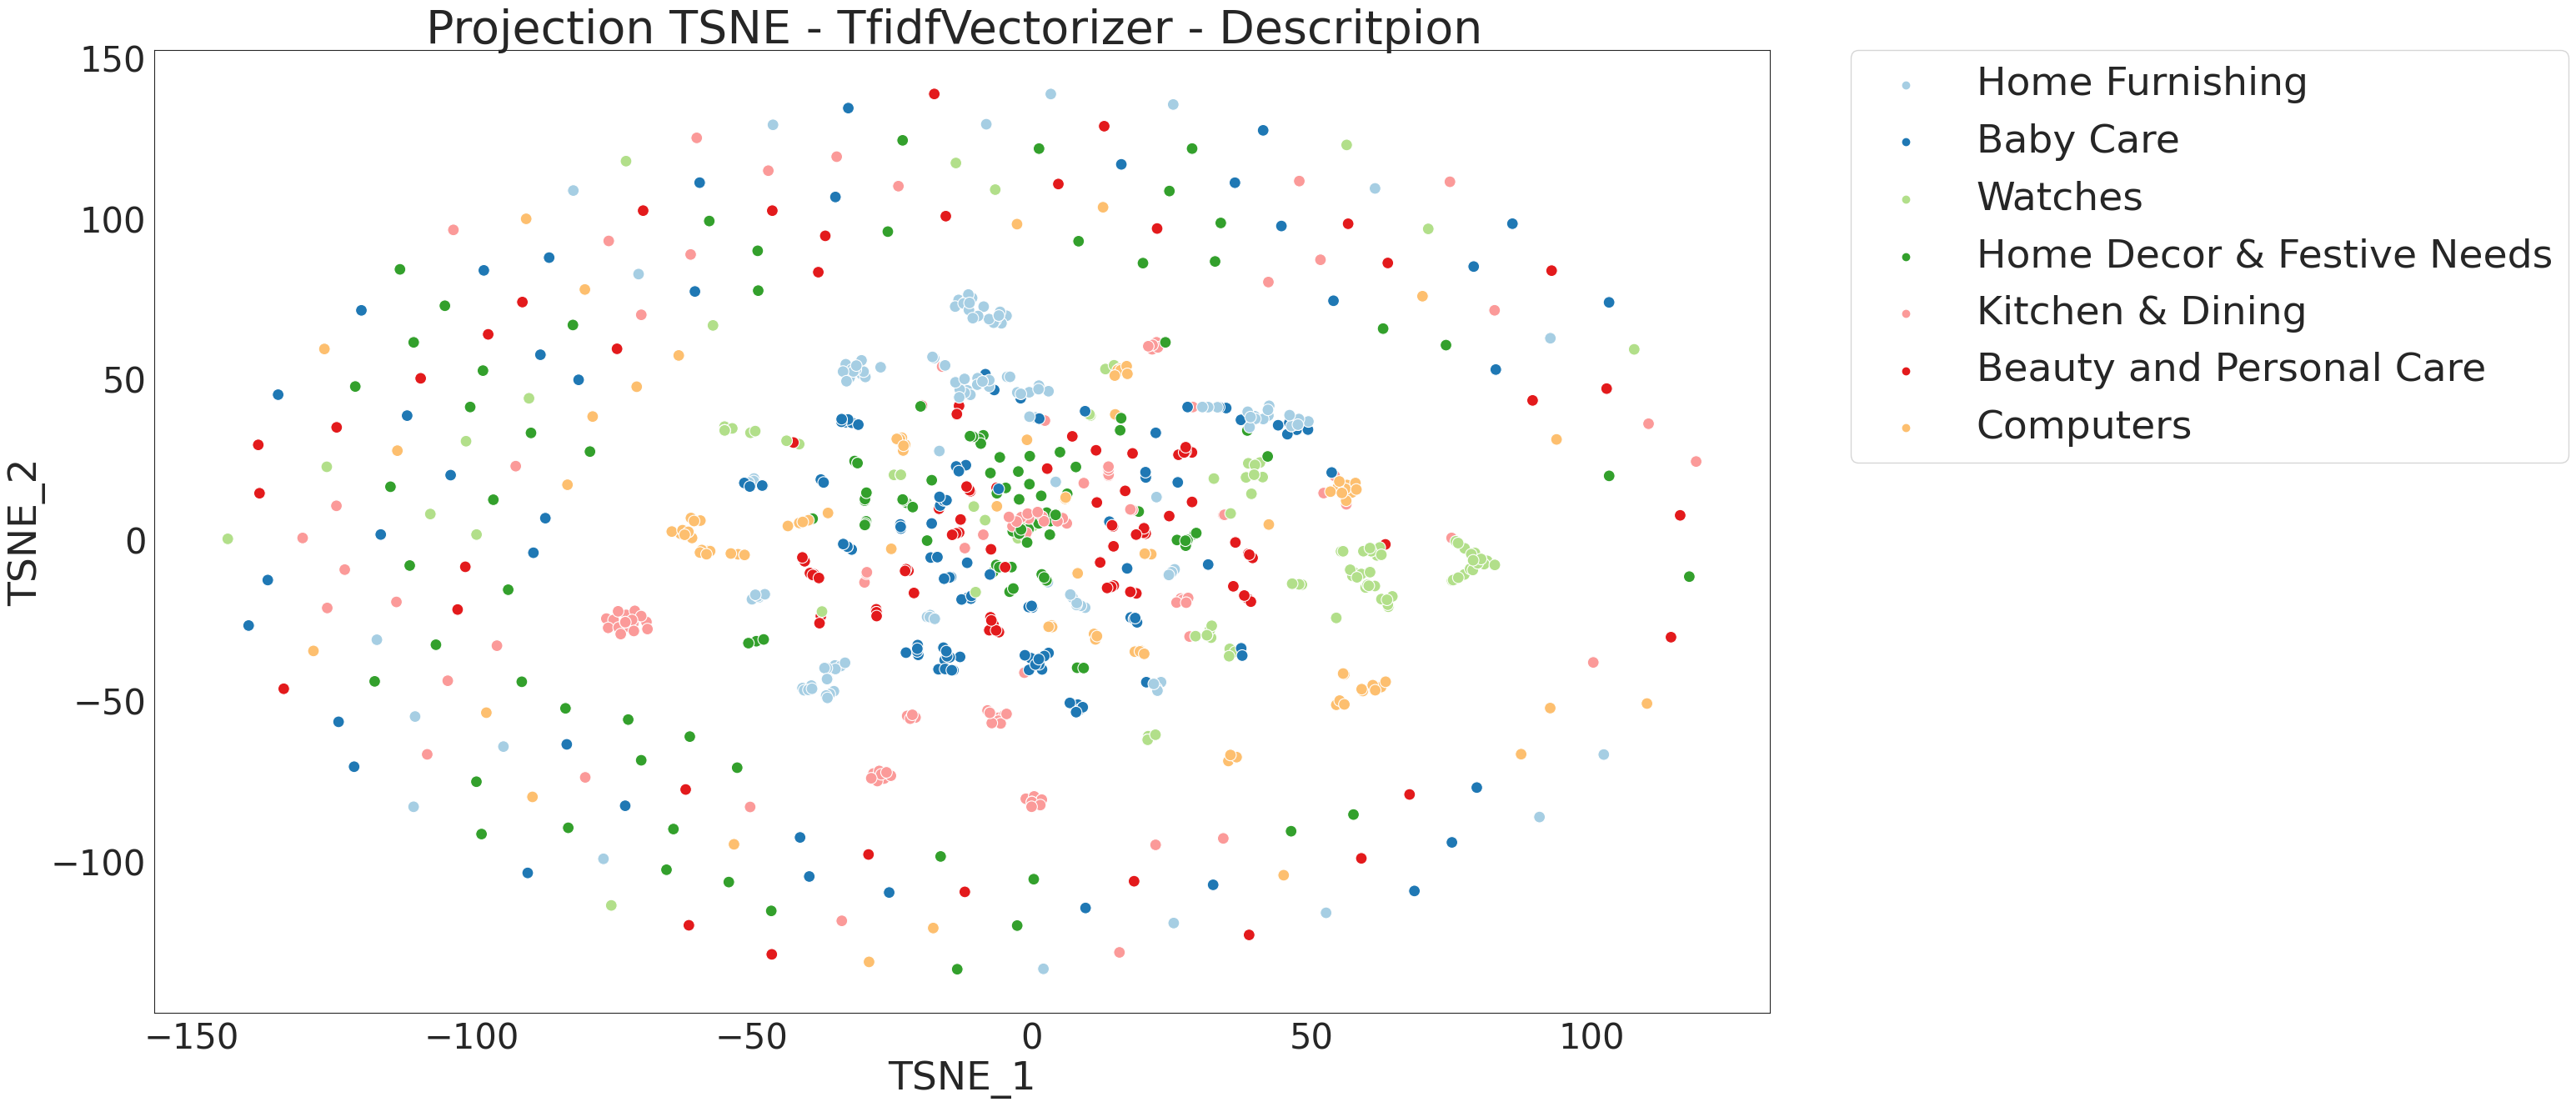

In [97]:
# Visulisation de la projection des 2 premiers variables TSNE
titre_tf = 'Projection TSNE - TfidfVectorizer'
titre_tf_5 = titre_tf + ' - Descritpion '
affiche_projections_reducdim(data_work, X_proj_tsne_tfidf_desc,
                                        'TSNE_1', 'TSNE_2', titre_tf_5)

#### <span style=''>6.2.3 Word2vec </span>

In [98]:
# t-SNE tuning du paramètre perplexity sans initialisation PCA
top_depart = time.time()
liste_param = [5, 10, 20, 30, 40, 50]
results_w2v_desc = list()
tsne_results_w2v_desc = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=seed,init='random')
    tsne_results_w2v_desc = tsne.fit_transform(vector_w2v_desc)
    results_w2v_desc.append(tsne_results_w2v_desc)
print('t-SNE terminée! en : {} seconds'.format(time.time()-top_depart))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.993572
[t-SNE] KL divergence after 500 iterations: 0.316652
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.613937
[t-SNE] KL divergence after 500 iterations: 0.228150
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.0

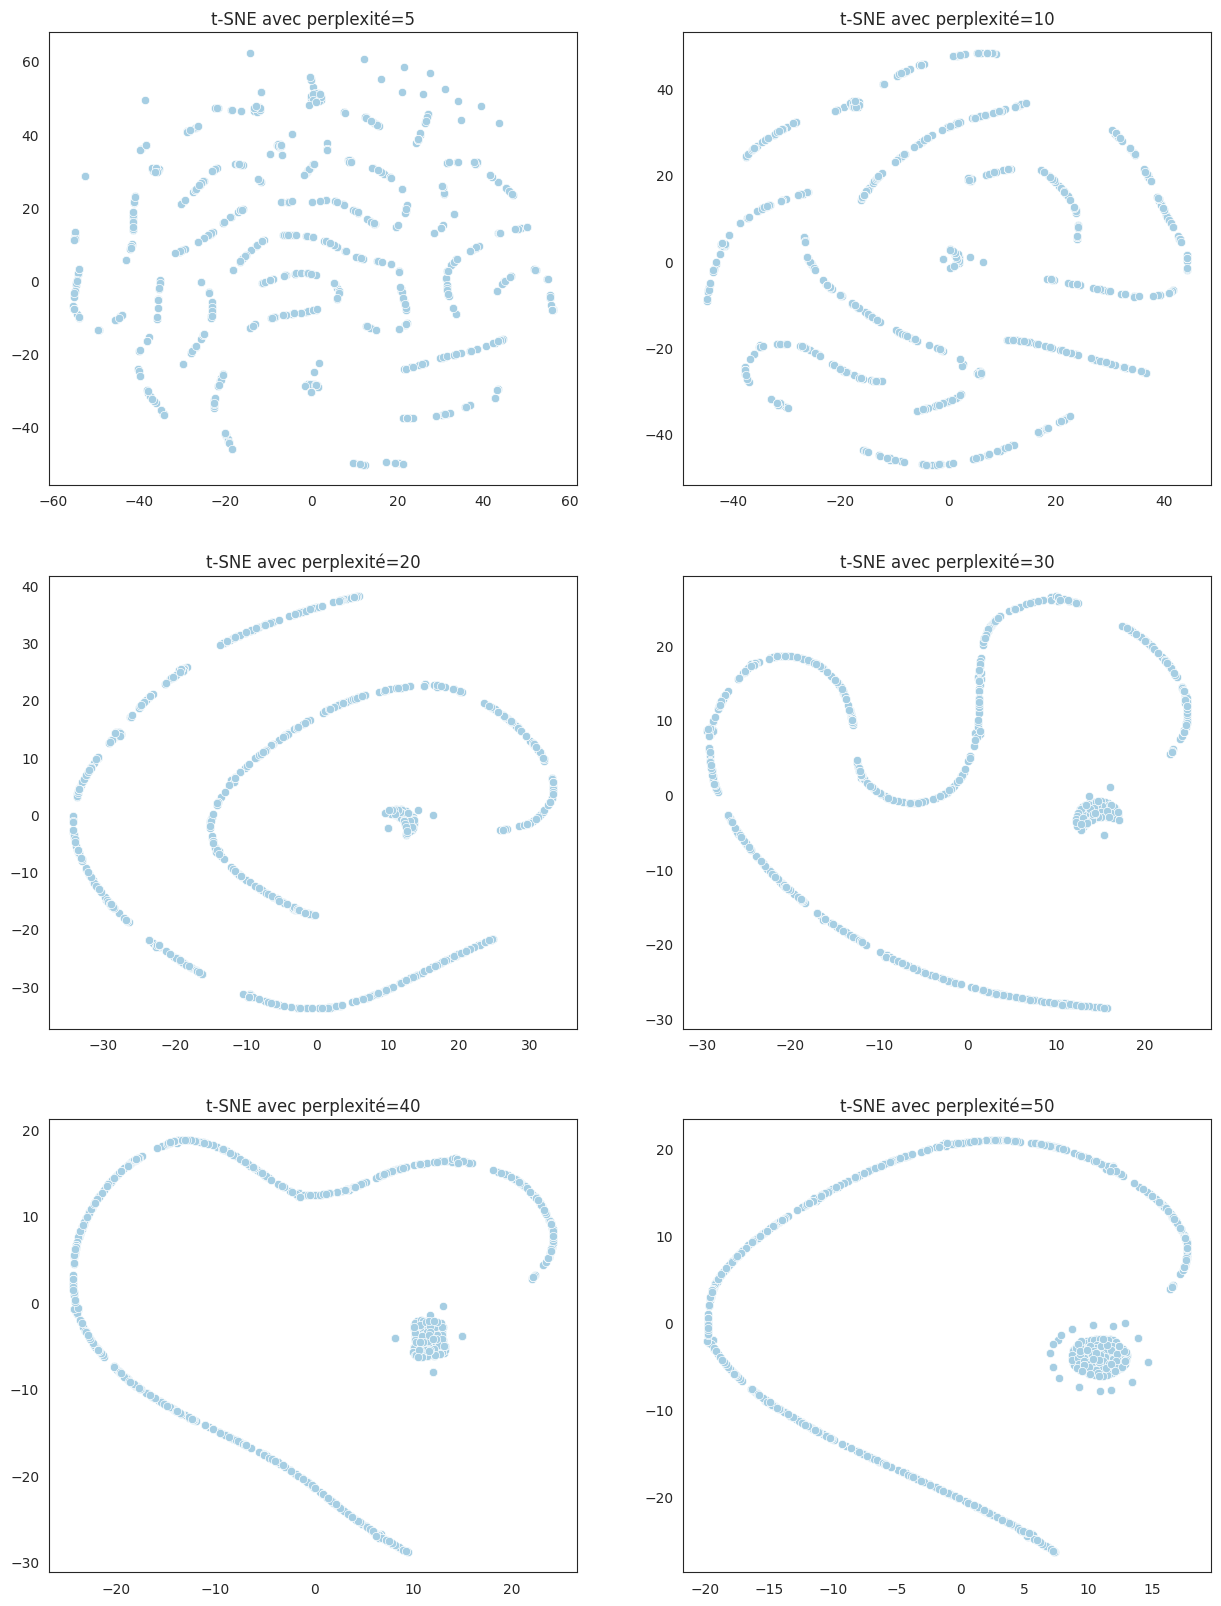

In [99]:
# Visualisation en 2D des différents résultats selon la perplexité
affiche_tsne(results_w2v_desc, liste_param, 1)

In [100]:
# Réduction de dimension tsne
tsne_w2v_desc = TSNE(verbose=1, perplexity=5, init='random')
X_proj_tsne_w2v_desc = \
    tsne_w2v_desc.fit_transform(vector_w2v_desc)
# Dataframe pour clustering
df_tsne_w2v_desc = pd.DataFrame({'VAR1' : X_proj_tsne_w2v_desc[:, 0],
                                     'VAR2' : X_proj_tsne_w2v_desc[:, 1],
                                     'CATEGORIE' : data_work['Categorie_1']})

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.048508
[t-SNE] KL divergence after 1000 iterations: 0.188006


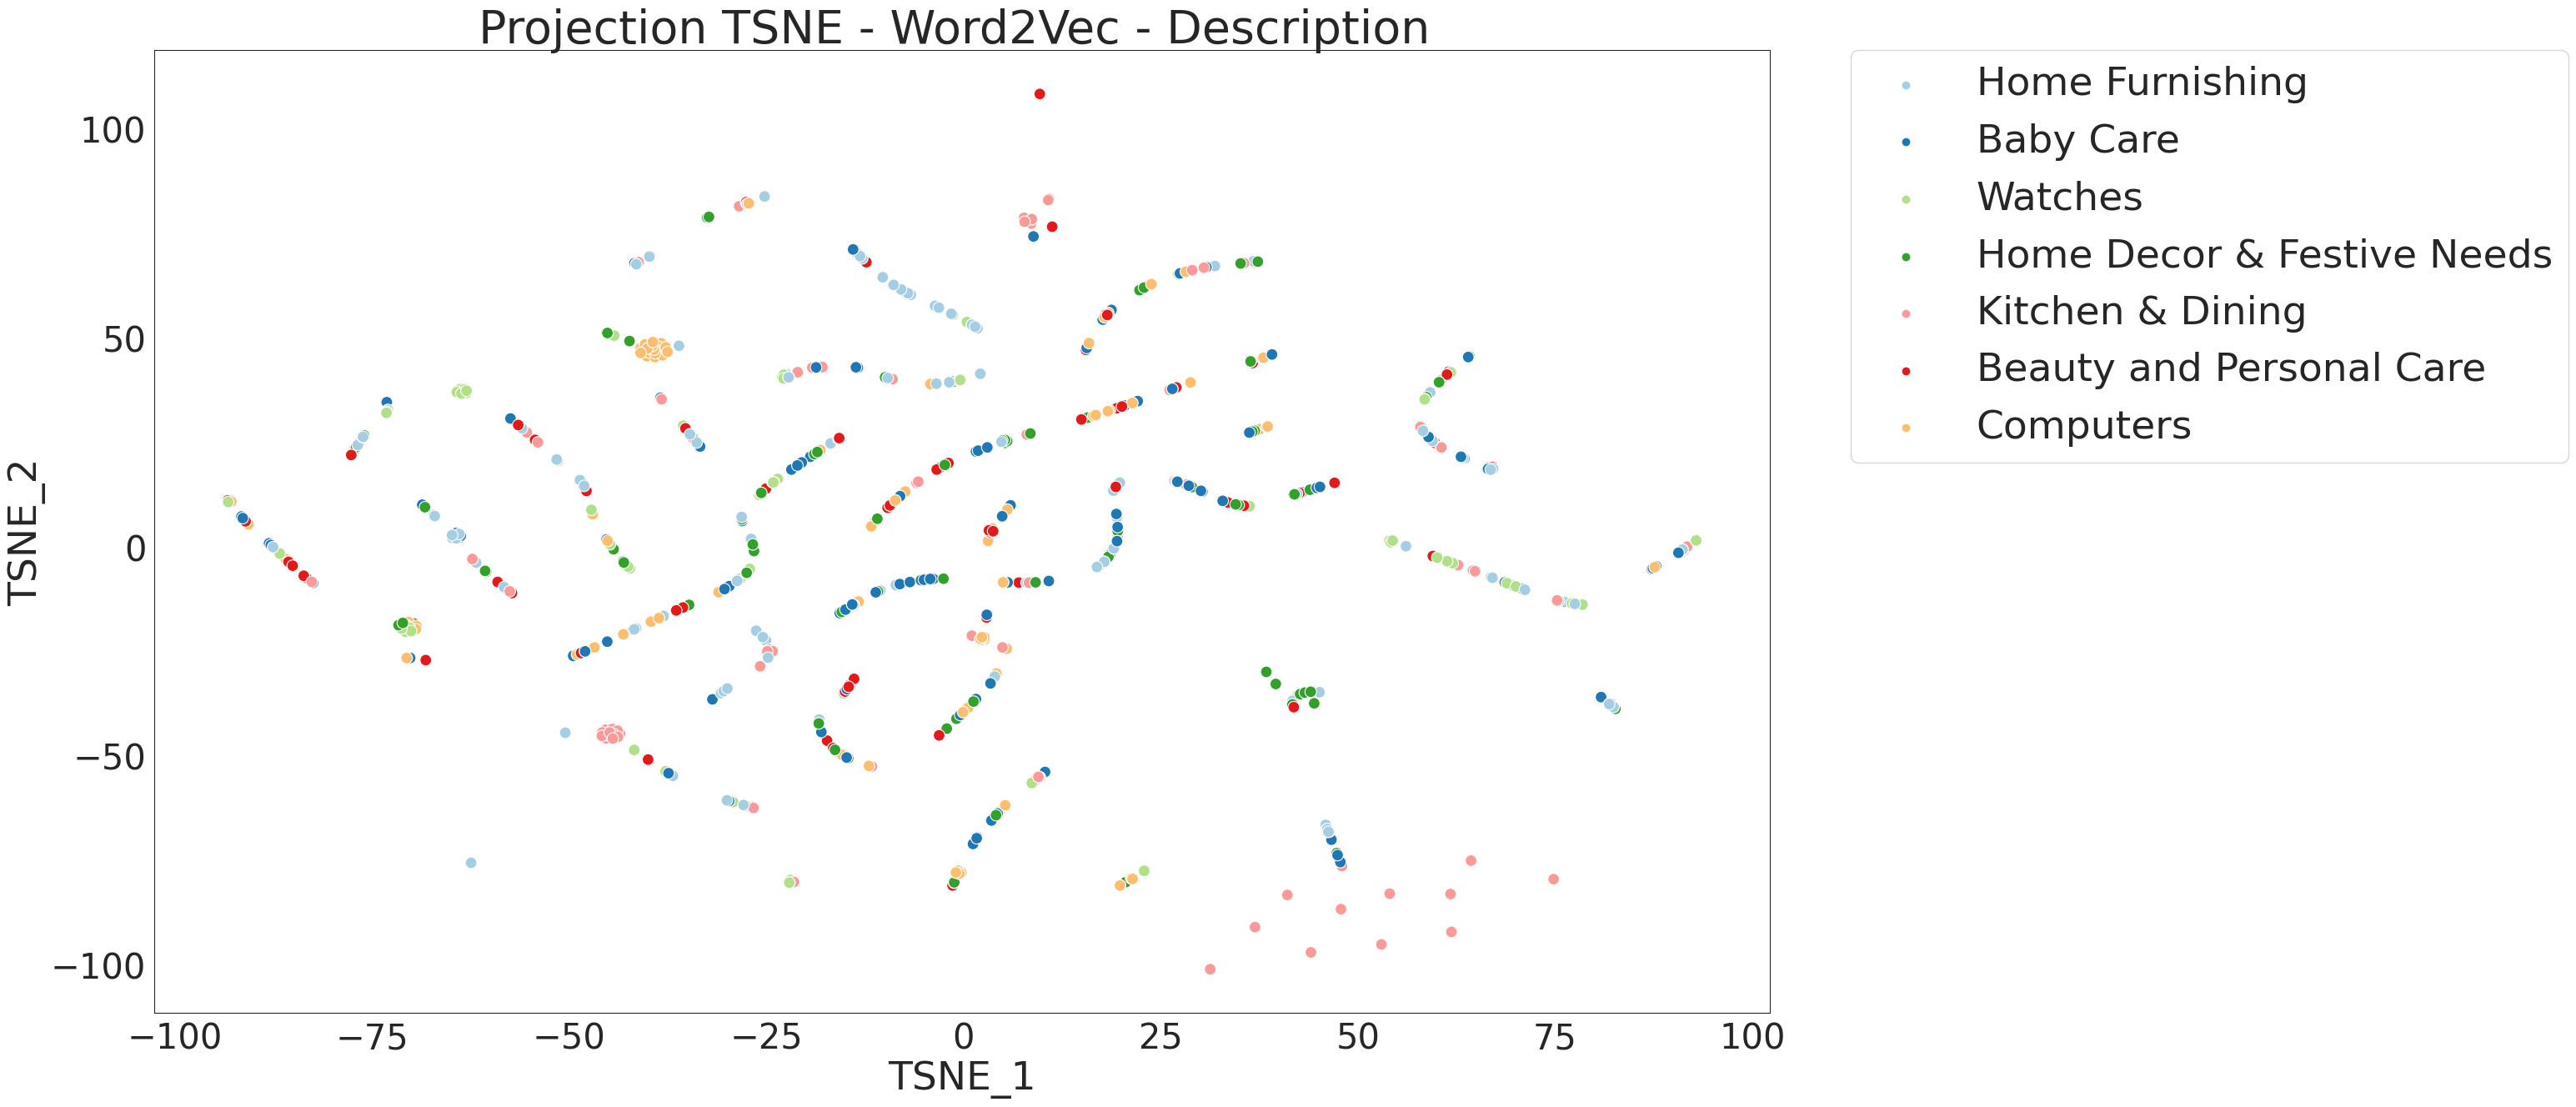

In [101]:
# Visulisation de la projection des 2 premiers variables TSNE
titre_w2v = 'Projection TSNE - Word2Vec'
titre_w2v_1 = titre_w2v + ' - Description '
affiche_projections_reducdim(data_work, X_proj_tsne_w2v_desc,
                                        'TSNE_1', 'TSNE_2', titre_w2v_1)

### <span style=''>6.3 ACP puis TSNE </span>

#### <span style=''>6.3.1 BOW - CountVectorizer </span>

In [102]:
# t-SNE tuning du paramètre perplexity sans initialisation PCA
top_depart = time.time()
liste_param = [5, 10, 20, 30, 40, 50]
results_cv_desc = list()
acptsne_results_cv_desc = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=seed,init='random')
    acptsne_results_cv_desc = tsne.fit_transform(X_proj_acp_cv_desc)
    results_cv_desc.append(acptsne_results_cv_desc)
print('t-SNE terminée! en : {} seconds'.format(time.time()-top_depart))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.726028
[t-SNE] KL divergence after 500 iterations: 0.888644
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.255089
[t-SNE] KL divergence after 500 iterations: 0.933458
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.0

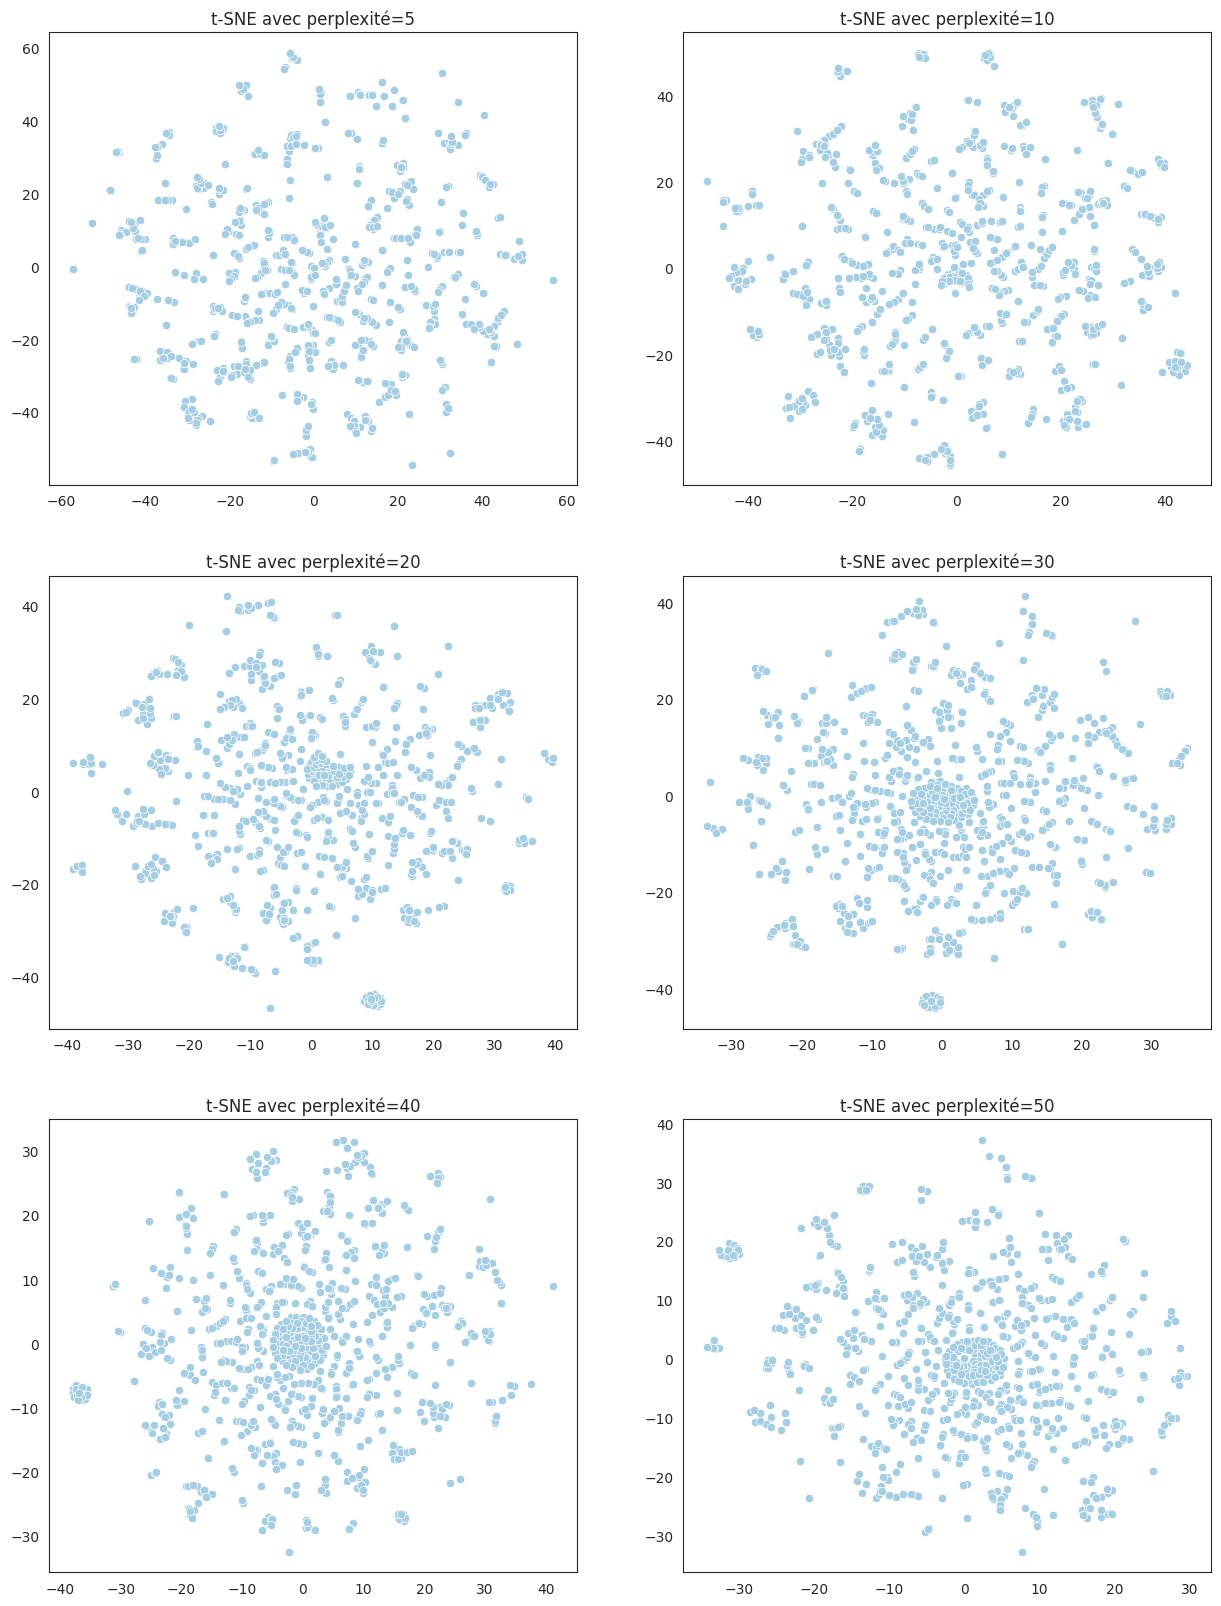

In [103]:
# Visualisation en 2D des différents résultats selon la perplexité
affiche_tsne(results_cv_desc, liste_param, 1)

In [104]:
# Réduction de dimension tsne
acptsne_cv_desc = TSNE(verbose=1, perplexity=40, init='random')
X_proj_acptsne_cv_desc = \
    acptsne_cv_desc.fit_transform(X_proj_acp_cv_desc)
# Dataframe pour clustering
df_acptsne_cv_desc = pd.DataFrame({'VAR1' : X_proj_acptsne_cv_desc[:, 0],
                                     'VAR2' : X_proj_acptsne_cv_desc[:, 1],
                                     'CATEGORIE' : data_work['Categorie_1']})

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.654045
[t-SNE] KL divergence after 1000 iterations: 0.931860


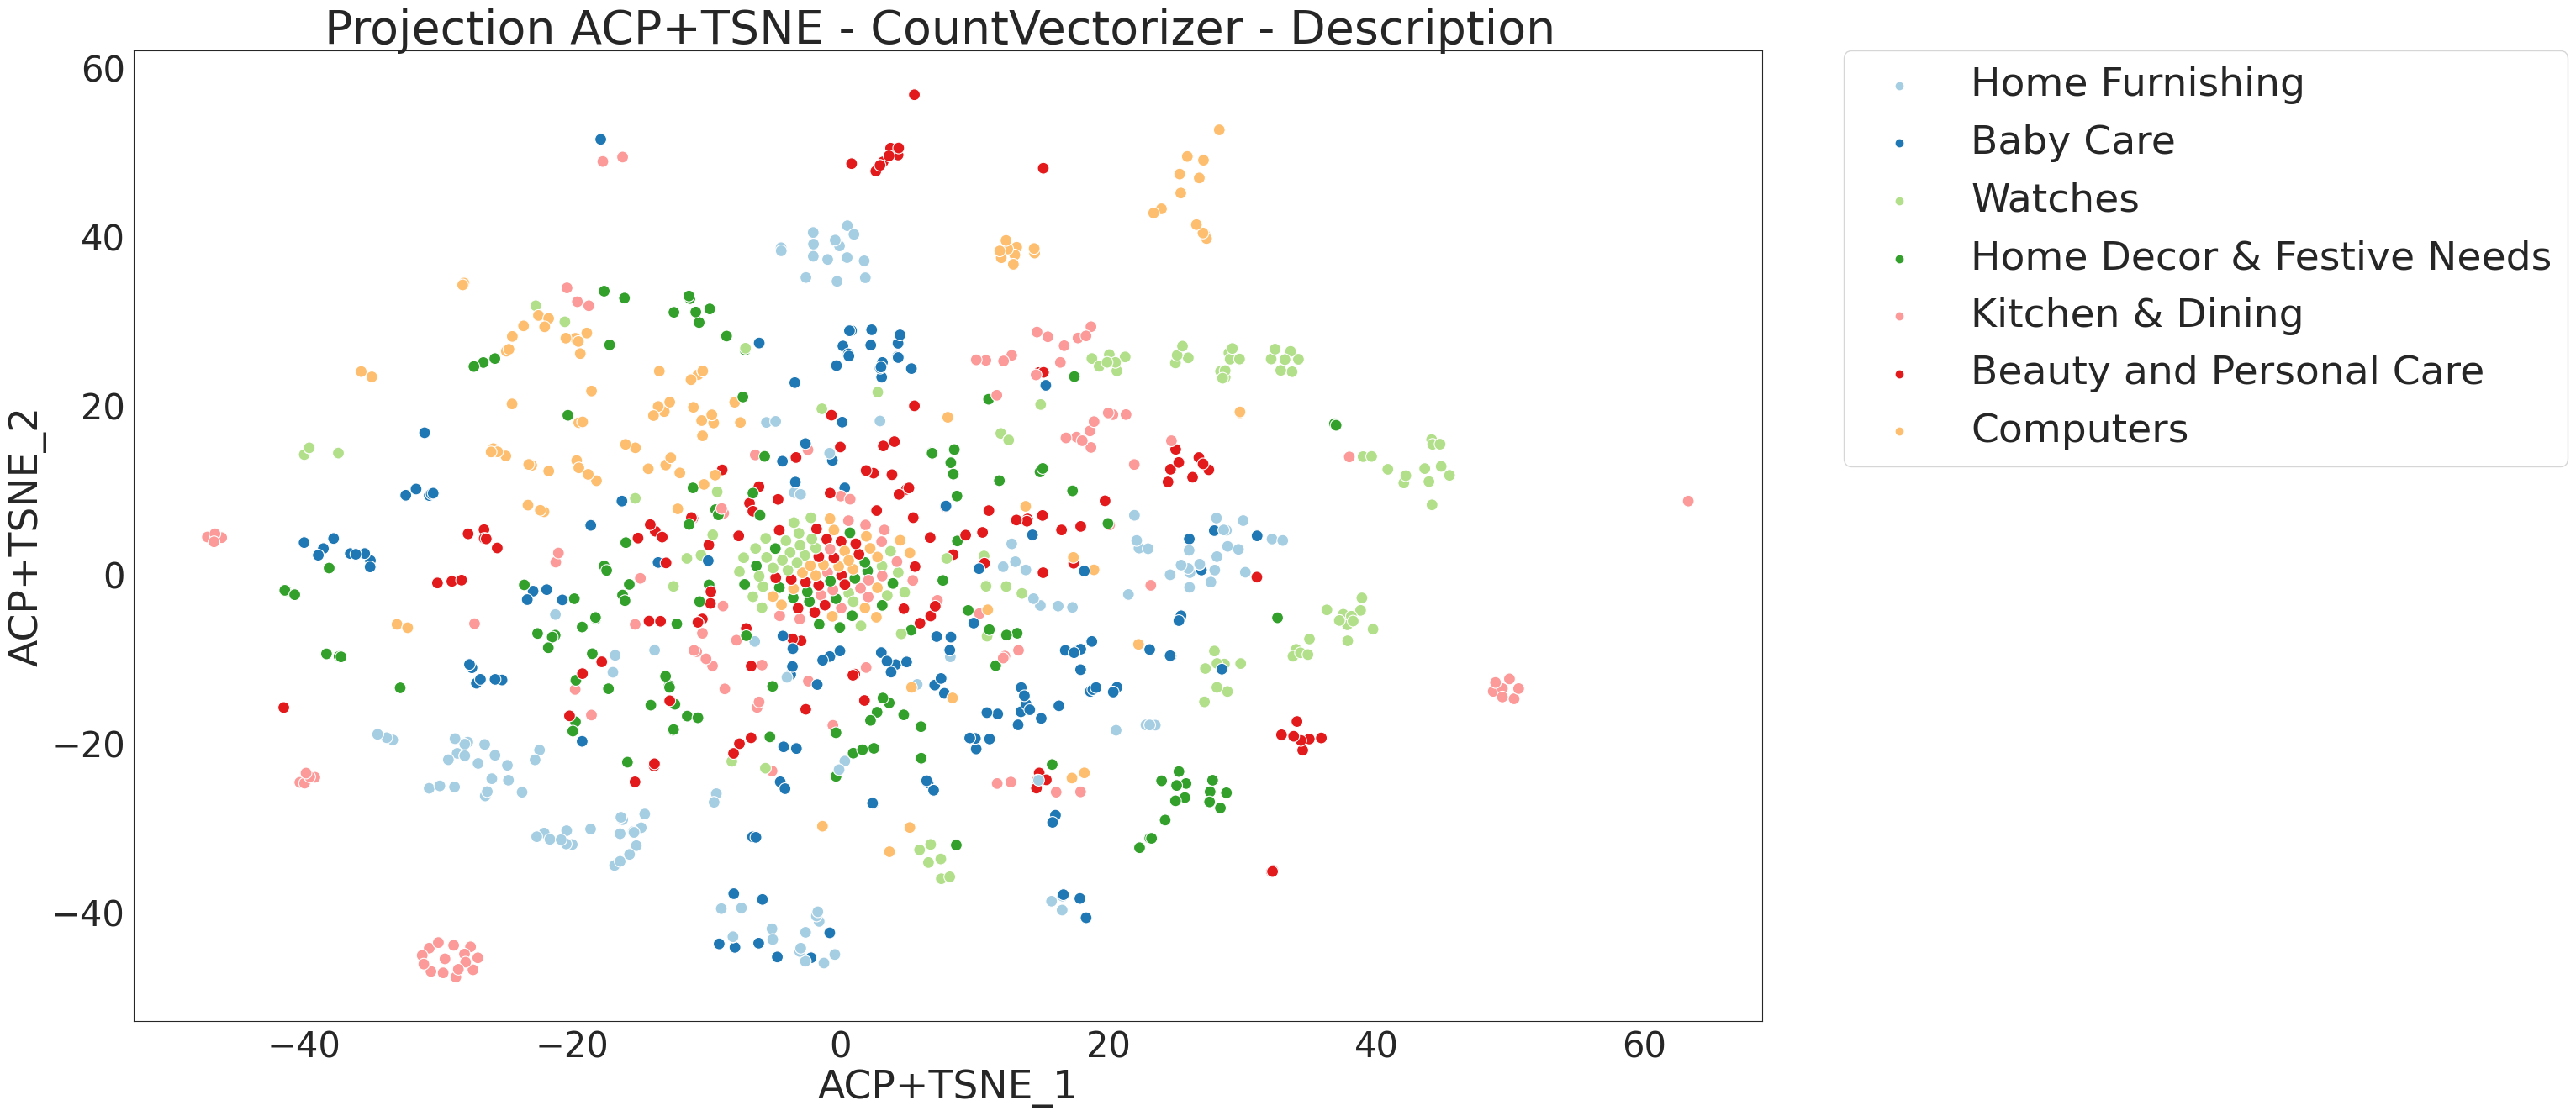

In [105]:
# Visulisation de la projection des 2 premiers variables TSNE
titre_acp = 'Projection ACP+TSNE - CountVectorizer'
titre_acp_1 = titre_acp + ' - Description '
affiche_projections_reducdim(data_work, X_proj_acptsne_cv_desc,
                                        'ACP+TSNE_1', 'ACP+TSNE_2', titre_acp_1)

#### <span style=''>6.3.2 BOW = TfidfVectorizer </span>

In [106]:
# t-SNE tuning du paramètre perplexity avec initialisation PCA
top_depart = time.time()
liste_param = [5, 10, 20, 30, 40, 50]
results_tfidf_desc = list()
acptsne_results_tfidf_desc = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=seed,init='random')
    acptsne_results_tfidf_desc = tsne.fit_transform(vector_tfidfvectorizer_desc)
    results_tfidf_desc.append(acptsne_results_tfidf_desc)
print('t-SNE terminée! en : {} seconds'.format(time.time()-top_depart))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.683685
[t-SNE] KL divergence after 500 iterations: 0.840400
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.765846
[t-SNE] KL divergence after 500 iterations: 0.881013
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.0

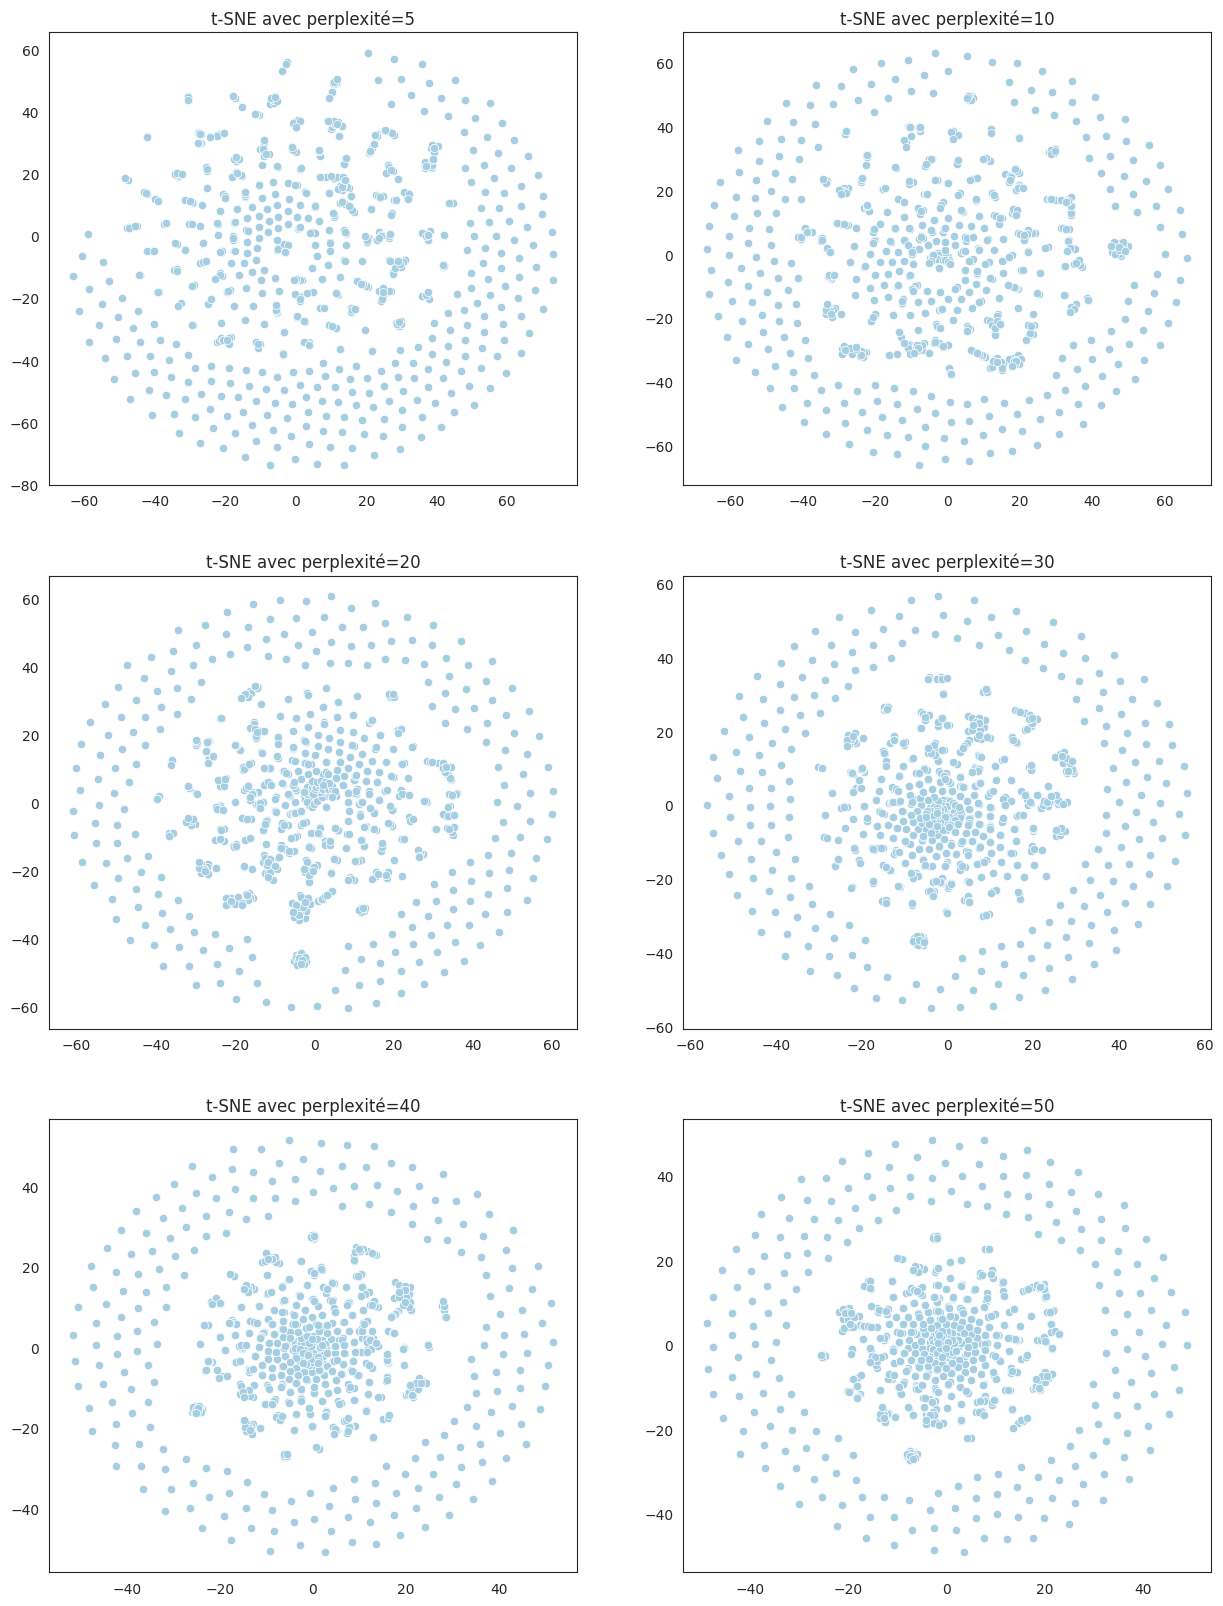

In [107]:
# Visualisation en 2D des différents résultats selon la perplexité
affiche_tsne(results_tfidf_desc, liste_param, 1)

In [108]:
# Réduction de dimension tsne
acptsne_tfidf_desc = TSNE(verbose=1, perplexity=5, init='random')
X_proj_acptsne_tfidf_desc = \
    acptsne_tfidf_desc.fit_transform(X_proj_acp_tfidf_desc)
# Dataframe pour clustering
df_acptsne_tfidf_desc = pd.DataFrame({'VAR1' : X_proj_acptsne_tfidf_desc[:, 0],
                                     'VAR2' : X_proj_acptsne_tfidf_desc[:, 1],
                                     'CATEGORIE' : data_work['Categorie_1']})

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.741501
[t-SNE] KL divergence after 1000 iterations: 0.761621


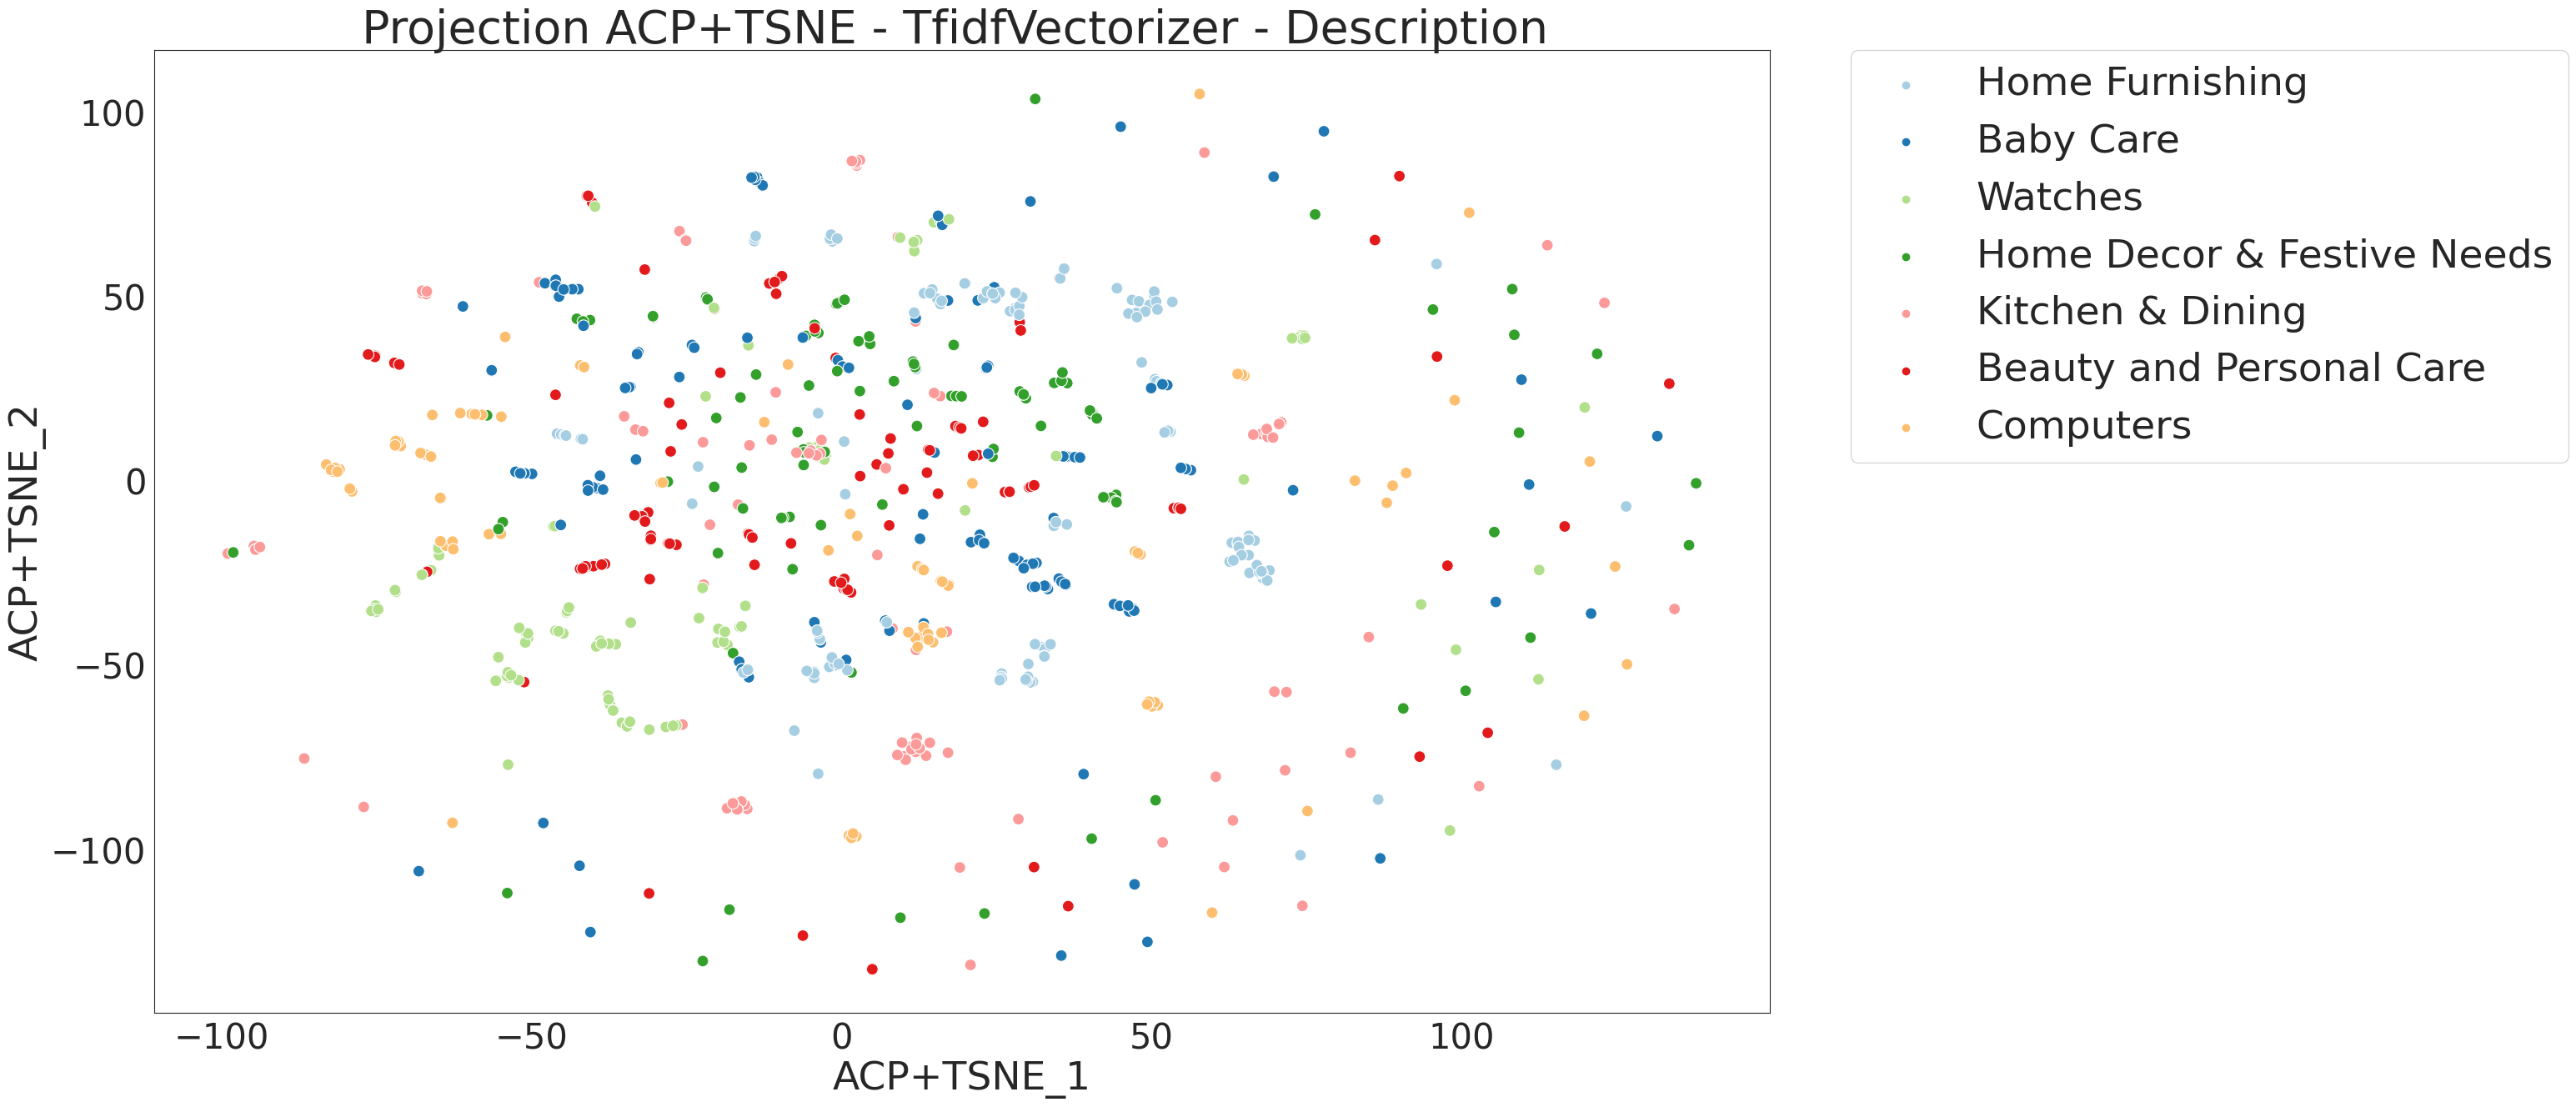

In [109]:
# Visulisation de la projection des 2 premiers variables TSNE
titre_acp = 'Projection ACP+TSNE - TfidfVectorizer'
titre_acp_5 = titre_acp + ' - Description '
affiche_projections_reducdim(data_work, X_proj_acptsne_tfidf_desc,
                                        'ACP+TSNE_1', 'ACP+TSNE_2', titre_acp_5)

## <span style=''>7 Clustering </span>

**Clustering KMeans avec 7 clusters(=nombre de catégories)**

In [181]:
cols = ['VAR1','VAR2']

### <span style=''>7.1 ACP  BOW - CountVectorizer </span>

In [182]:
type_donnee = 'ACP_CV_DESC'

In [183]:
# Initialisation du dataframe de sauvegarde des métriques kmeans
df_metrics_kmeans = pd.DataFrame({})

In [184]:
# Initialisation du dataframe de sauvegarde du score
df_scores = pd.DataFrame({})

In [185]:
# Clustering Metrics
from sklearn.metrics import davies_bouldin_score, silhouette_score, \
    adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

In [186]:

def calcul_metrics_kmeans(data, dataframe_metrique, type_donnees,
                          random_seed, ninit, maxiter):
    '''
    Calcul des métriques de KMeans en fonction de différents paramètres.
    Parameters
    ----------
    data : données, obligatoire.
    dataframe_metrique : dataframe de sauvegarde des résultats, obligatoire.
    type_donnees : string intitulé des données, obligatoire.
    random_seed : nombre aléatoire pour la reproductibilité, obligatoire.
    ninit : nombre de clusters à initialiser, obligatoire.
    maxiter : type d'initialisation : 'k-means++' ou 'random'.
    Returns
    -------
    dataframe_metrique : résultat des métriques
    '''
    # Cette fonction permet de calculer le nombre de clusters le plus
    # optimal pour notre analyse : le coefficient de silhouette,
    # dispersion, indice de davies_bouldin
    silhouette = []
    dispersion = []
    davies_bouldin = []
    donnees = []
    temps = []

    result_ninit = []
    result_maxiter = []

    # Hyperparametre tuning

    ninit = ninit
    maxiter = maxiter

    # Recherche des hyperparamètres
    for var_ninit in ninit:

        for var_maxiter in maxiter:

            # Top début d'exécution
            time_start = time.time()

            # Initialisation de l'algorithme
            cls = KMeans(n_clusters=7,
                         n_init=var_ninit,
                         init='k-means++',
                         max_iter=var_maxiter,
                         random_state=random_seed)

            # Entraînement de l'algorithme
            cls.fit(data)

            # Prédictions
            preds = cls.predict(data)

            # Top fin d'exécution
            time_end = time.time()

            # Calcul du score de coefficient de silhouette
            silh = silhouette_score(data, preds)
            # Calcul la dispersion
            disp = cls.inertia_
            # Calcul de l'indice davies-bouldin
            db = davies_bouldin_score(data, preds)
            # Durée d'exécution
            time_execution = time_end - time_start

            silhouette.append(silh)
            dispersion.append(disp)
            davies_bouldin.append(db)
            donnees.append(type_donnees)
            temps.append(time_execution)

            result_ninit.append(var_ninit)
            result_maxiter.append(var_maxiter)

    dataframe_metrique = dataframe_metrique._append(pd.DataFrame({
        'Type_données': donnees,
        'n_init': result_ninit,
        'max_iter': result_maxiter,
        'coef_silh': silhouette,
        'dispersion': dispersion,
        'davies_bouldin': davies_bouldin,
        'Durée (s)': temps
    }), ignore_index=True)

    return dataframe_metrique

In [187]:
# Tunig hyperparametres n_init, max_iter
# parametres a tester

n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]

# Metriques avec les differentes combinaisons des parametres

df_metrics_kmeans = calcul_metrics_kmeans(df_acp_cv_desc[cols],
                                         df_metrics_kmeans,
                                         type_donnee,
                                         seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0

df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
.sort_values(by =['coef_silh','davies_bouldin','Durée (s)'], ascending = [False, True, True]).style.hide()

In [188]:
# sauvegarde des dataframes de trace 
df_metrics_kmeans.to_csv('/kaggle/working/data_df_metrics_kmeans.csv')

**Clustering**

In [189]:
### instanciation du modele KMeans avec les meilleurs parametres 
kmeans_acp_cv_desc = KMeans(n_clusters = 7, init = 'k-means++',
                           n_init = 50 , max_iter = 300, random_state = seed).fit(df_acp_cv_desc[cols])

# Ajout de l'assignation du cluster au dataframe
df_acp_cv_desc['Clusters'] = kmeans_acp_cv_desc.labels_
kmeans_acp_cv_desc_labels = kmeans_acp_cv_desc.labels_

In [119]:
def calcul_metriques_clusters(dataframe, dataframe_sauv_res, type_donnee):
    '''
    Calcul de la métrique ARI, .
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    dataframe_sauv_res : dataframe de sauvegarde du résultat, obligatoire.
    type_donnee : titre pour dataframe de sauvegarde, obligatoire.
    Returns
    -------
    dataframe_sauv_res.
    '''
    valeur_reel = dataframe['CATEGORIE']
    valeur_pred = dataframe['Clusters']
    score_ari = adjusted_rand_score(valeur_reel, valeur_pred)
    score_homogeneite = homogeneity_score(valeur_reel, valeur_pred)
    score_completude = completeness_score(valeur_reel, valeur_pred)
    score_vmeasure = v_measure_score(valeur_reel, valeur_pred)

    dataframe_sauv_res = dataframe_sauv_res._append(pd.DataFrame({
        'Type_données': [type_donnee],
        'ARI': [score_ari],
        'Homogénéité': [score_homogeneite],
        'Complétude': [score_completude],
        'V-measure': [score_vmeasure]}), ignore_index=True)

    return dataframe_sauv_res


In [190]:
# Scores

df_scores =  calcul_metriques_clusters(df_acp_cv_desc,df_scores,type_donnee)

df_scores.style.hide()

In [191]:
# sauvegarde des dataframes de trace 
df_scores.to_csv('/kaggle/working/data_df_scores.csv')

In [122]:
def affiche_repartition_par_clusters(clusters_labels):
    '''
    Affiche la répartition par cluster
    Parameters
    ----------
    clusters_labels : la séries des labels des clusters, obligatoire.
    Returns
    -------
    None.
    '''
    ax1 = plt.gca()

    # DataFrame de travail
    series_client_cluster = pd.Series(clusters_labels).value_counts()
    nb_client = series_client_cluster.sum()
    df_visu_client_cluster = pd.DataFrame(
        {'Clusters': series_client_cluster.index,
         'Nombre': series_client_cluster.values})
    df_visu_client_cluster['%'] = round(
        (df_visu_client_cluster['Nombre']) * 100 / nb_client, 2)
    df_visu_client_cluster = df_visu_client_cluster.sort_values(by='Clusters')
    display(df_visu_client_cluster.style.hide())

    # Barplot de la distribution
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nombre',
                data=df_visu_client_cluster, color='SteelBlue', ax=ax1)
    ax1.set_ylabel('Nombre)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Répartition par clusters', fontsize=14)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()



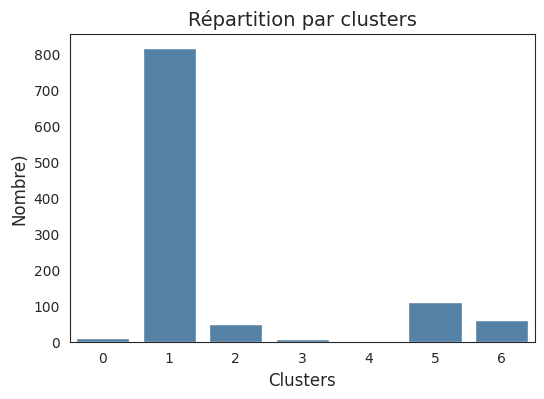

In [192]:
affiche_repartition_par_clusters(kmeans_acp_cv_desc_labels)

In [193]:
# les categories par clusters 
df_acp_cv_desc.groupby('Clusters')['CATEGORIE'].value_counts().to_frame()

count
Clusters CATEGORIE                        
0        Kitchen & Dining               11
1        Watches                       146
         Beauty and Personal Care      131
         Baby Care                     127
         Home Furnishing               119
         Computers                     115
         Home Decor & Festive Needs    102
         Kitchen & Dining               74
2        Kitchen & Dining               21
         Home Decor & Festive Needs     11
         Beauty and Personal Care        6
         Home Furnishing                 4
         Baby Care                       3
         Watches                         2
         Computers                       1
3        Baby Care                       3
         Home Furnishing                 2
         Kitchen & Dining                1
         Beauty and Personal Care        1
4        Home Decor & Festive Needs      2
5        Computers                      24
         Home Decor & Festive Needs     22
         Home Furnishing                20
         Kitchen & Dining               16
         Baby Care                      16
         Beauty and Personal Care        9
         Watches                         2
6        Kitchen & Dining               27
         Home Decor & Festive Needs     13
         Computers                      10
         Home Furnishing                 5
         Beauty and Personal Care        3
         Baby Care                       1

In [125]:
def affiche_projection_par_clusters(X_projected, clusters_labels, titre):
    '''
    Affiche la projection scatterplot par clusters.
    Parameters
    ----------
    proj_tsne : projection, obligatoire.
    clusters_labels : la variable représentant les clusters.
    Returns
    -------
    None.
    '''
    
    plt.figure(figsize=[25, 15])

    sns.scatterplot(x = X_projected[:, 0], y=  X_projected[:, 1],
                    hue=clusters_labels, s=100, alpha=1, palette='Set1')

    plt.title(titre, fontsize=40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=34)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.show()

**Visualisation des clusters**

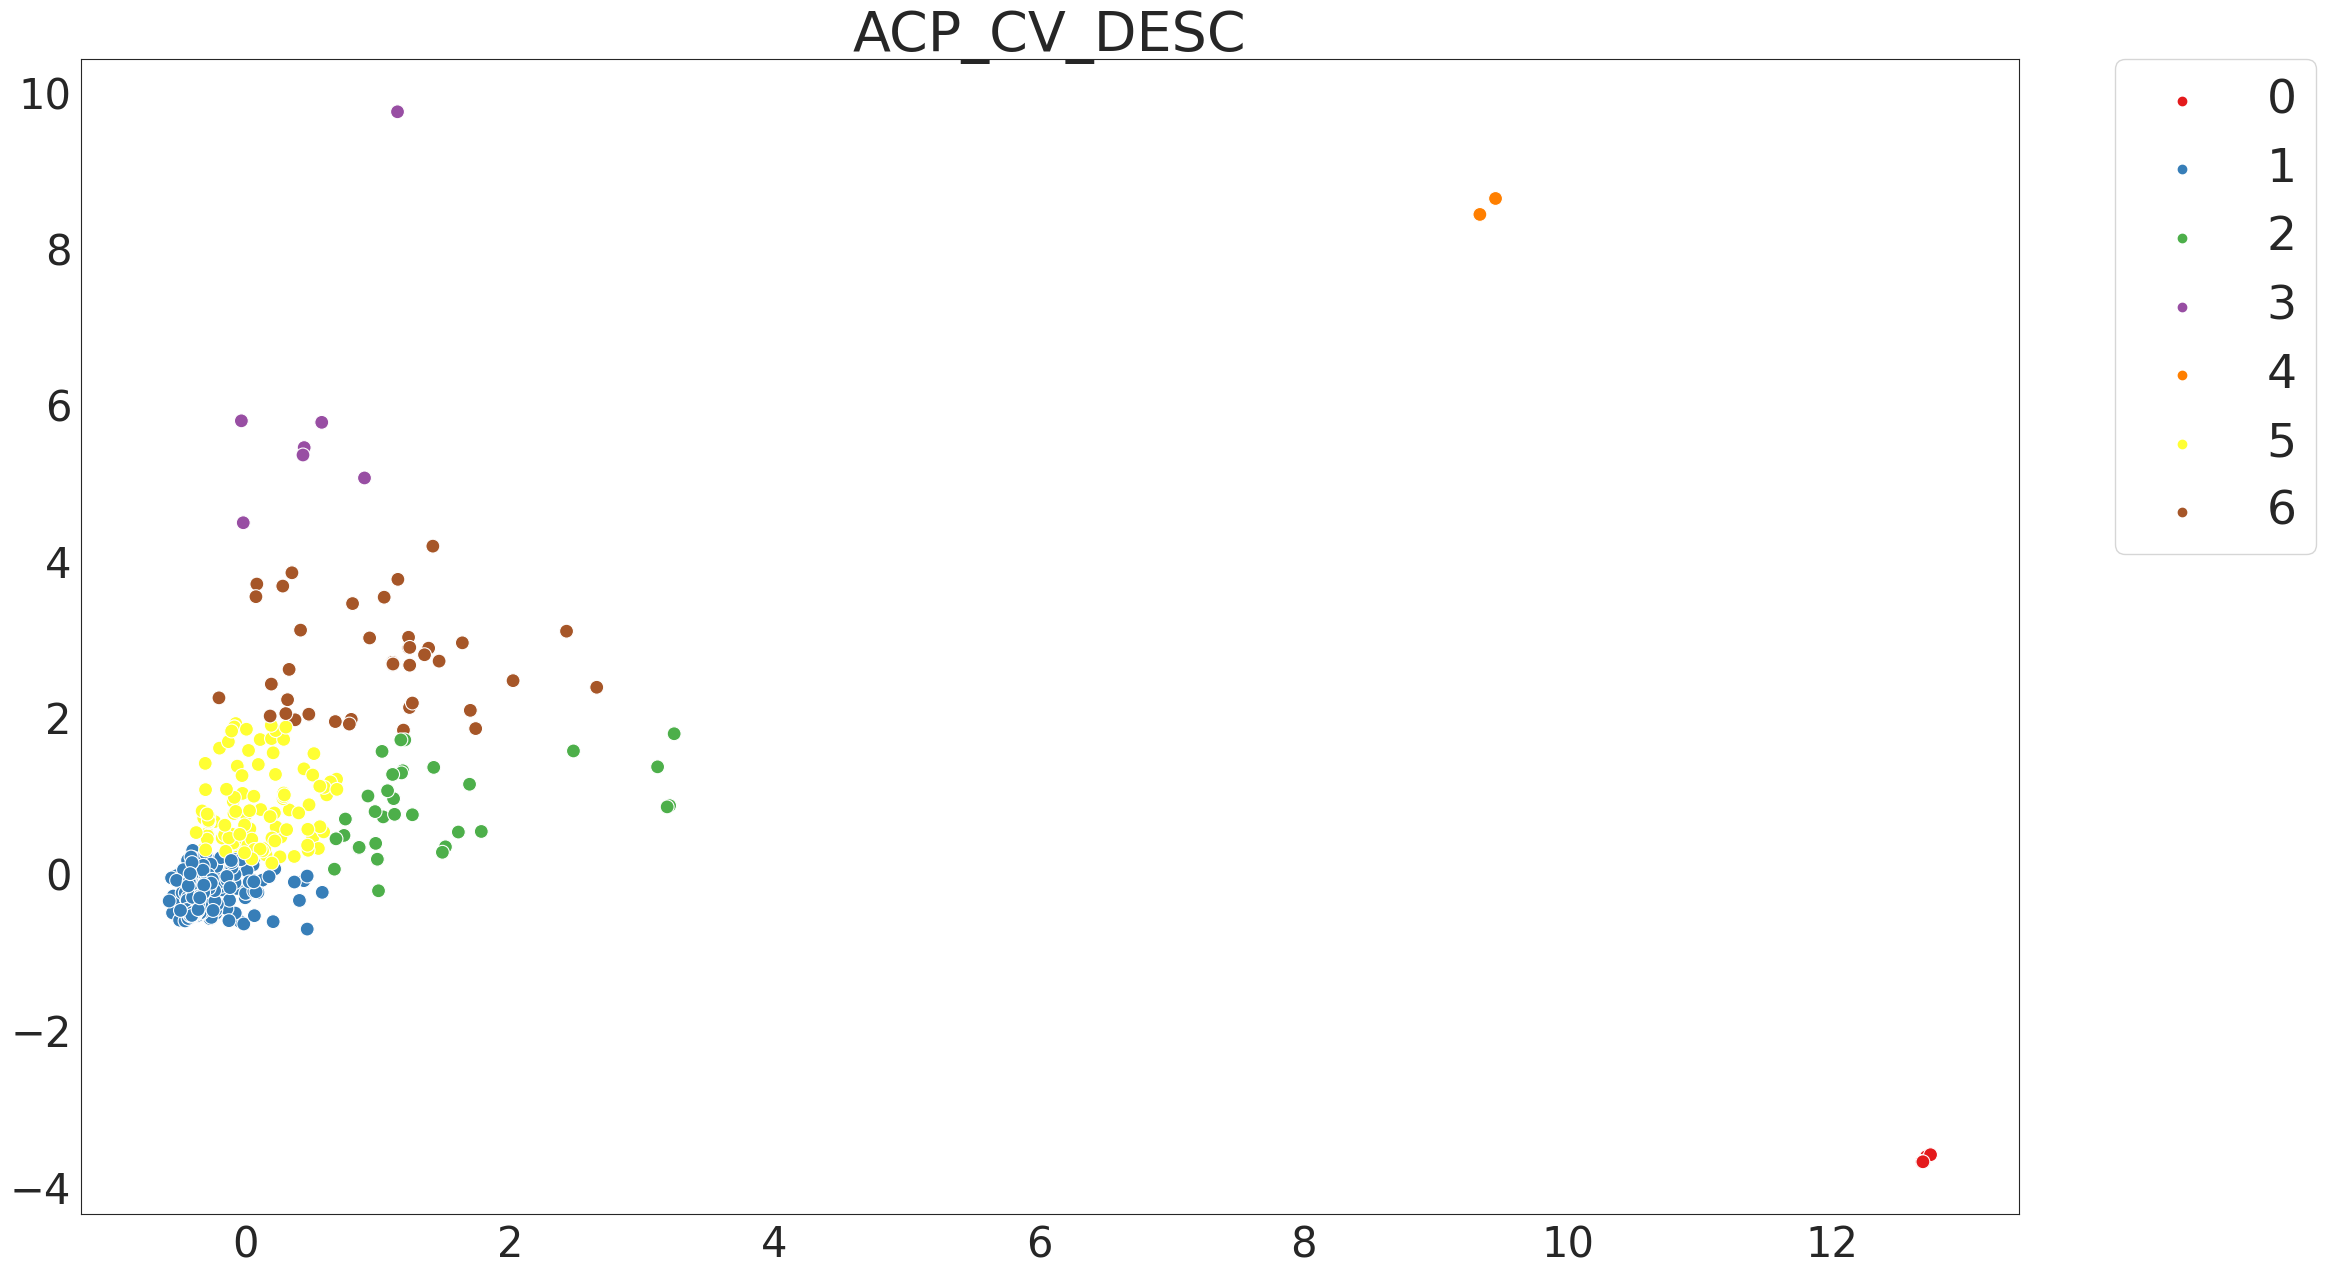

In [194]:
affiche_projection_par_clusters(X_proj_acp_cv_desc,kmeans_acp_cv_desc_labels,
                               type_donnee)

**Bilan**
- Répartition inegale , les vrais catégories sont mélangées dans les clusters, certains clusters sont vides, le score ARI est tres faible
- ACP + CountVectorizer ne parvient pas a retrouver les 7 catégories

### <span style=''>7.2 ACP  BOW - TfidfVectorizer </span>

In [195]:
type_donnee = 'ACP_TFIDF_DESC'

In [196]:
# Tunig hyperparametres n_init, max_iter
# parametres a tester

n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]

# Metriques avec les differentes combinaisons des parametres

df_metrics_kmeans = calcul_metrics_kmeans(df_acp_tfidf_desc[cols],
                                         df_metrics_kmeans,
                                         type_donnee,
                                         seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0

df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
.sort_values(by =['coef_silh','davies_bouldin','Durée (s)'], ascending = [False, True, True]).style.hide()

In [197]:
# sauvegarde des dataframes de trace 
df_metrics_kmeans.to_csv('/kaggle/working/data_df_metrics_kmeans.csv')

In [198]:
### instanciation du modele KMeans avec les meilleurs parametres 
kmeans_acp_tfidf_desc = KMeans(n_clusters = 7, init = 'k-means++',
                           n_init = 10 , max_iter = 100, random_state = seed).fit(df_acp_tfidf_desc[cols])

# Ajout de l'assignation du cluster au dataframe
df_acp_tfidf_desc['Clusters'] = kmeans_acp_tfidf_desc.labels_
kmeans_acp_tfidf_desc_labels = kmeans_acp_tfidf_desc.labels_

In [199]:
# Scores

df_scores =  calcul_metriques_clusters(df_acp_tfidf_desc,df_scores,type_donnee)

df_scores.style.hide()

In [200]:
# sauvegarde des dataframes de trace 
df_scores.to_csv('/kaggle/working/data_df_scores.csv')

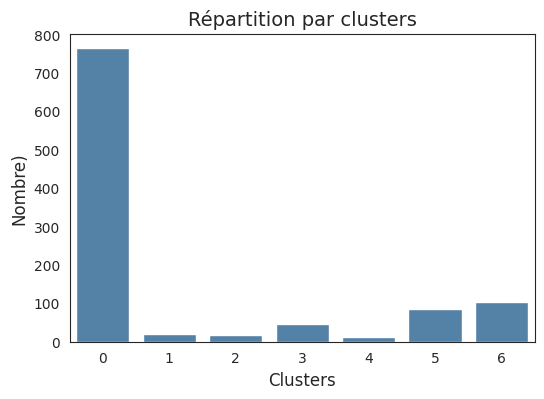

In [201]:
affiche_repartition_par_clusters(kmeans_acp_tfidf_desc_labels)

In [202]:
# les categories par clusters 
df_acp_tfidf_desc.groupby('Clusters')['CATEGORIE'].value_counts().to_frame()

count
Clusters CATEGORIE                        
0        Computers                     144
         Beauty and Personal Care      137
         Baby Care                     133
         Home Decor & Festive Needs    125
         Watches                        87
         Kitchen & Dining               79
         Home Furnishing                59
1        Kitchen & Dining               21
2        Home Furnishing                13
         Baby Care                       5
3        Watches                        46
4        Baby Care                       7
         Home Furnishing                 6
5        Kitchen & Dining               43
         Home Decor & Festive Needs     16
         Home Furnishing                15
         Beauty and Personal Care        6
         Computers                       3
         Baby Care                       1
6        Home Furnishing                57
         Watches                        17
         Home Decor & Festive Needs      9
         Beauty and Personal Care        7
         Kitchen & Dining                7
         Baby Care                       4
         Computers                       3

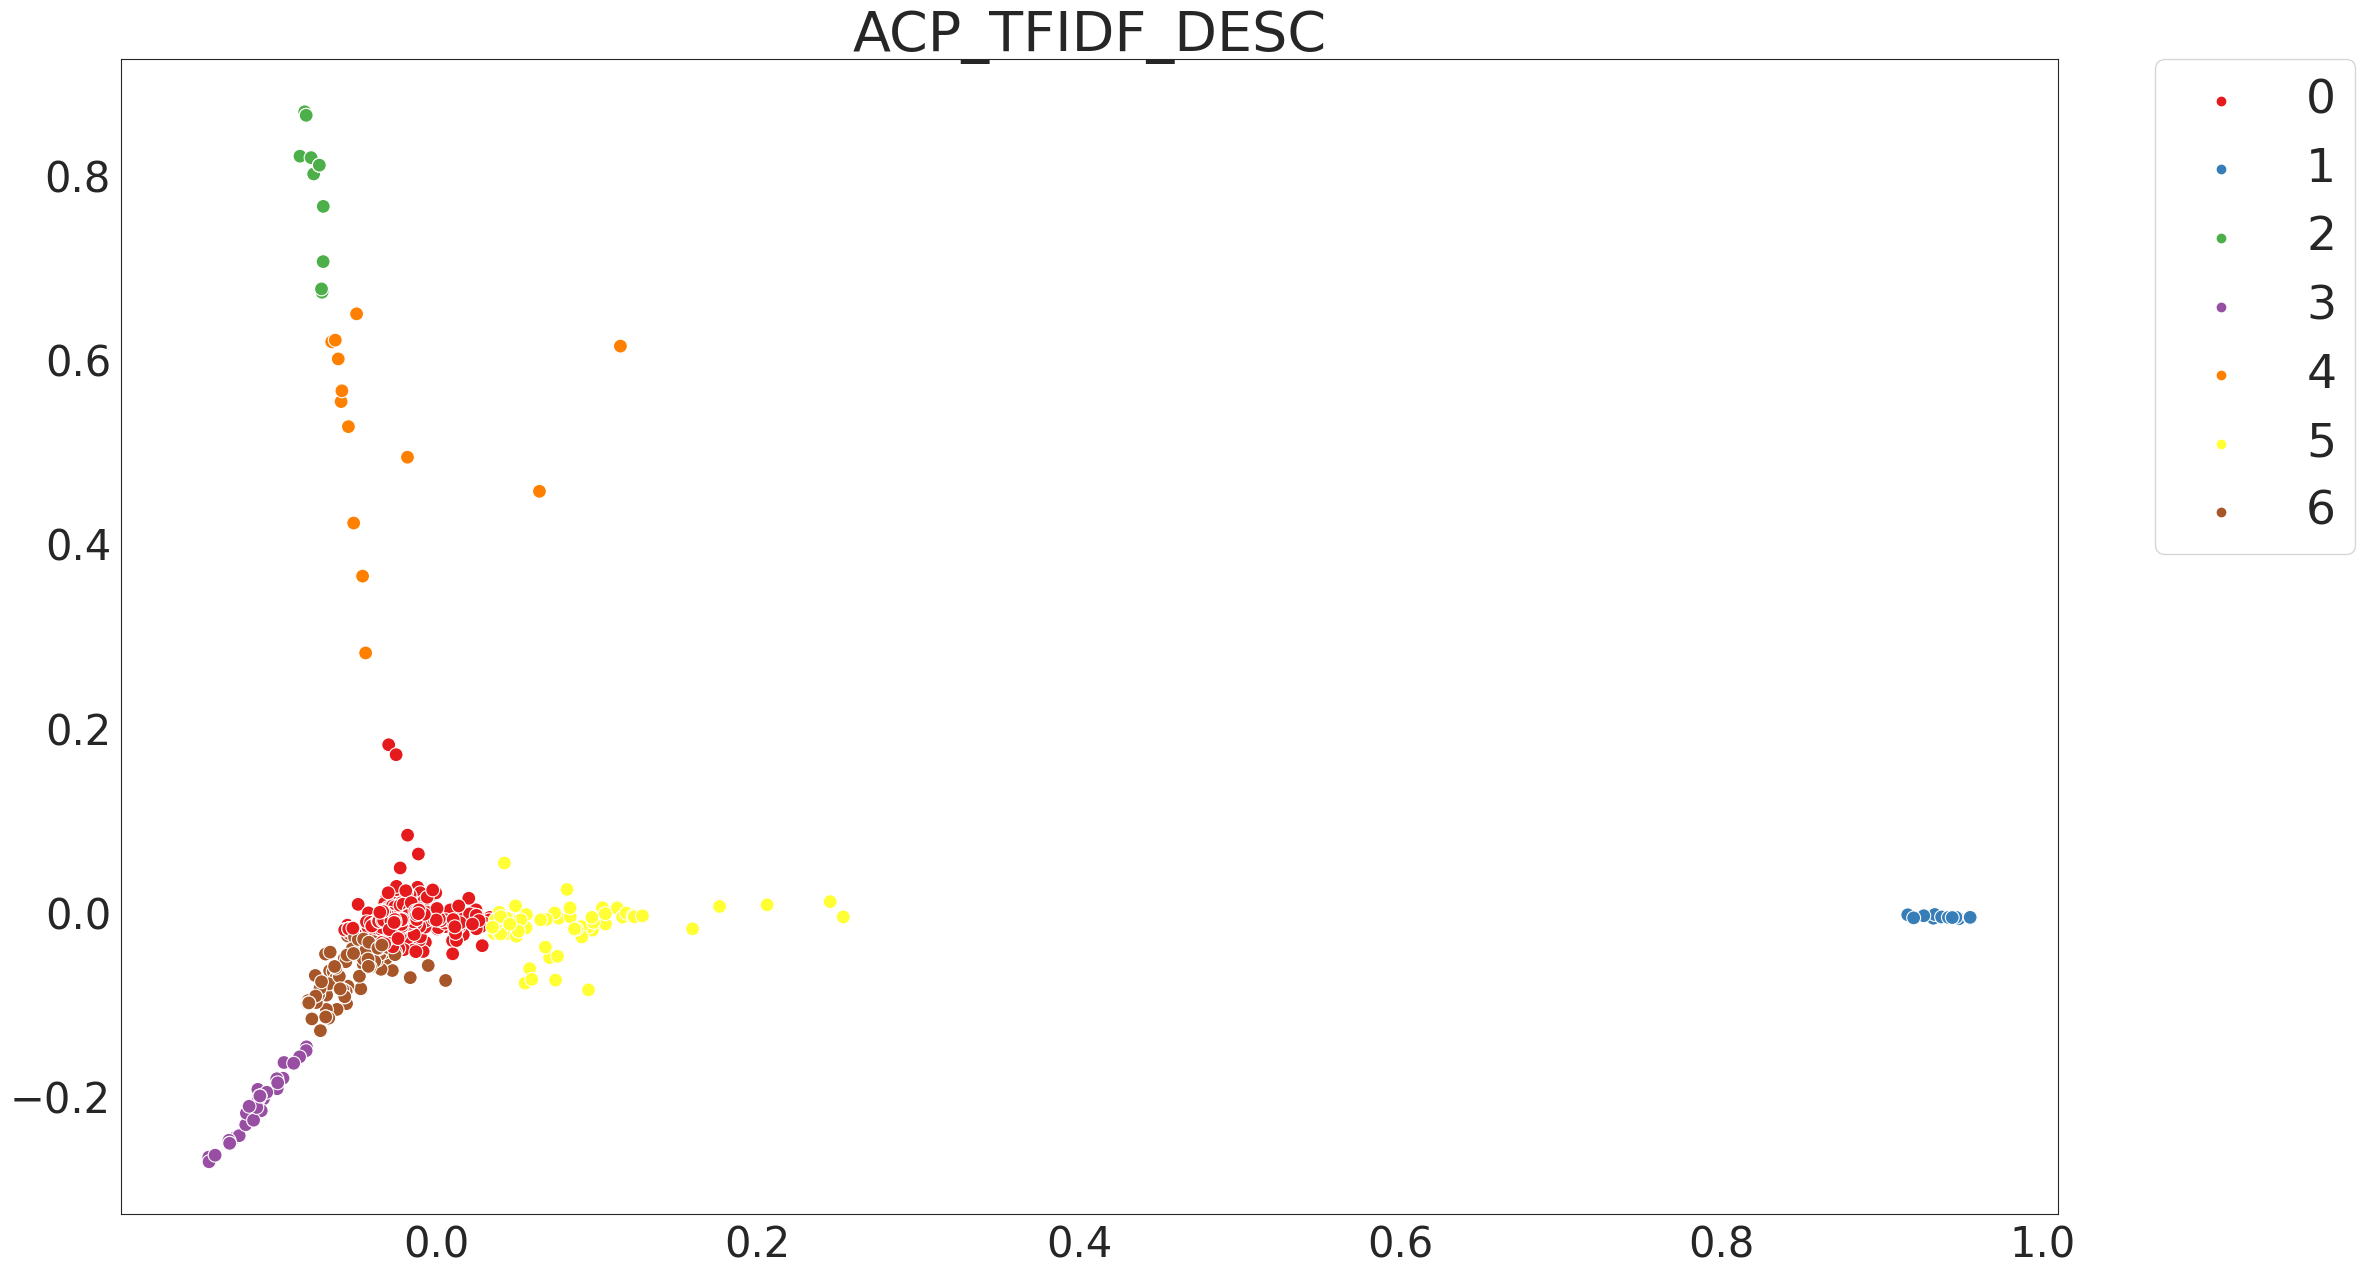

In [203]:
affiche_projection_par_clusters(X_proj_acp_tfidf_desc,kmeans_acp_tfidf_desc_labels,
                               type_donnee)

**Bilan** : ACP+TFIDF ne parvient pas a retrouver les 7 catégories

### <span style=''>7.3 TSNE  BOW - CountVectorizer </span>

In [204]:
type_donnee = 'TSNE_CV_DESC'

In [205]:
# Tunig hyperparametres n_init, max_iter
# parametres a tester

n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]

# Metriques avec les differentes combinaisons des parametres

df_metrics_kmeans = calcul_metrics_kmeans(df_tsne_cv_desc[cols],
                                         df_metrics_kmeans,
                                         type_donnee,
                                         seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0

df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
.sort_values(by =['coef_silh','davies_bouldin','Durée (s)'], ascending = [False, True, True]).style.hide()

In [206]:
# sauvegarde des dataframes de trace 
df_metrics_kmeans.to_csv('/kaggle/working/data_df_metrics_kmeans.csv')

In [207]:
### instanciation du modele KMeans avec les meilleurs parametres 
kmeans_tsne_cv_desc = KMeans(n_clusters = 7, init = 'k-means++',
                           n_init = 20 , max_iter = 500, random_state = seed).fit(df_tsne_cv_desc[cols])

# Ajout de l'assignation du cluster au dataframe
df_tsne_cv_desc['Clusters'] = kmeans_tsne_cv_desc.labels_
kmeans_tsne_cv_desc_labels = kmeans_tsne_cv_desc.labels_

In [208]:
# Scores

df_scores =  calcul_metriques_clusters(df_tsne_cv_desc,df_scores,type_donnee)

df_scores.style.hide()

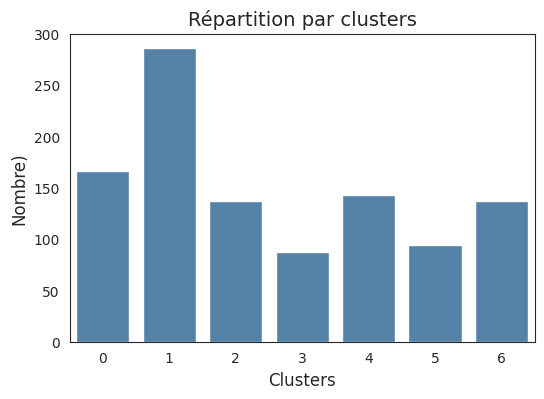

In [209]:
affiche_repartition_par_clusters(kmeans_tsne_cv_desc_labels)

In [210]:
# les categories par clusters 
df_tsne_cv_desc.groupby('Clusters')['CATEGORIE'].value_counts().to_frame()

count
Clusters CATEGORIE                        
0        Watches                        55
         Home Decor & Festive Needs     51
         Kitchen & Dining               36
         Beauty and Personal Care       11
         Baby Care                      10
         Computers                       3
1        Beauty and Personal Care       78
         Baby Care                      45
         Home Decor & Festive Needs     44
         Computers                      39
         Watches                        37
         Kitchen & Dining               26
         Home Furnishing                17
2        Computers                      38
         Watches                        31
         Home Decor & Festive Needs     23
         Kitchen & Dining               15
         Home Furnishing                15
         Baby Care                       9
         Beauty and Personal Care        6
3        Computers                      55
         Home Furnishing                20
         Beauty and Personal Care        5
         Baby Care                       2
         Home Decor & Festive Needs      2
         Kitchen & Dining                2
         Watches                         1
4        Beauty and Personal Care       32
         Kitchen & Dining               25
         Home Furnishing                25
         Baby Care                      23
         Home Decor & Festive Needs     18
         Watches                        15
         Computers                       5
5        Baby Care                      50
         Kitchen & Dining               20
         Beauty and Personal Care        7
         Home Furnishing                 5
         Home Decor & Festive Needs      5
         Watches                         4
         Computers                       3
6        Home Furnishing                68
         Kitchen & Dining               26
         Baby Care                      11
         Beauty and Personal Care       11
         Watches                         7
         Home Decor & Festive Needs      7
         Computers                       7

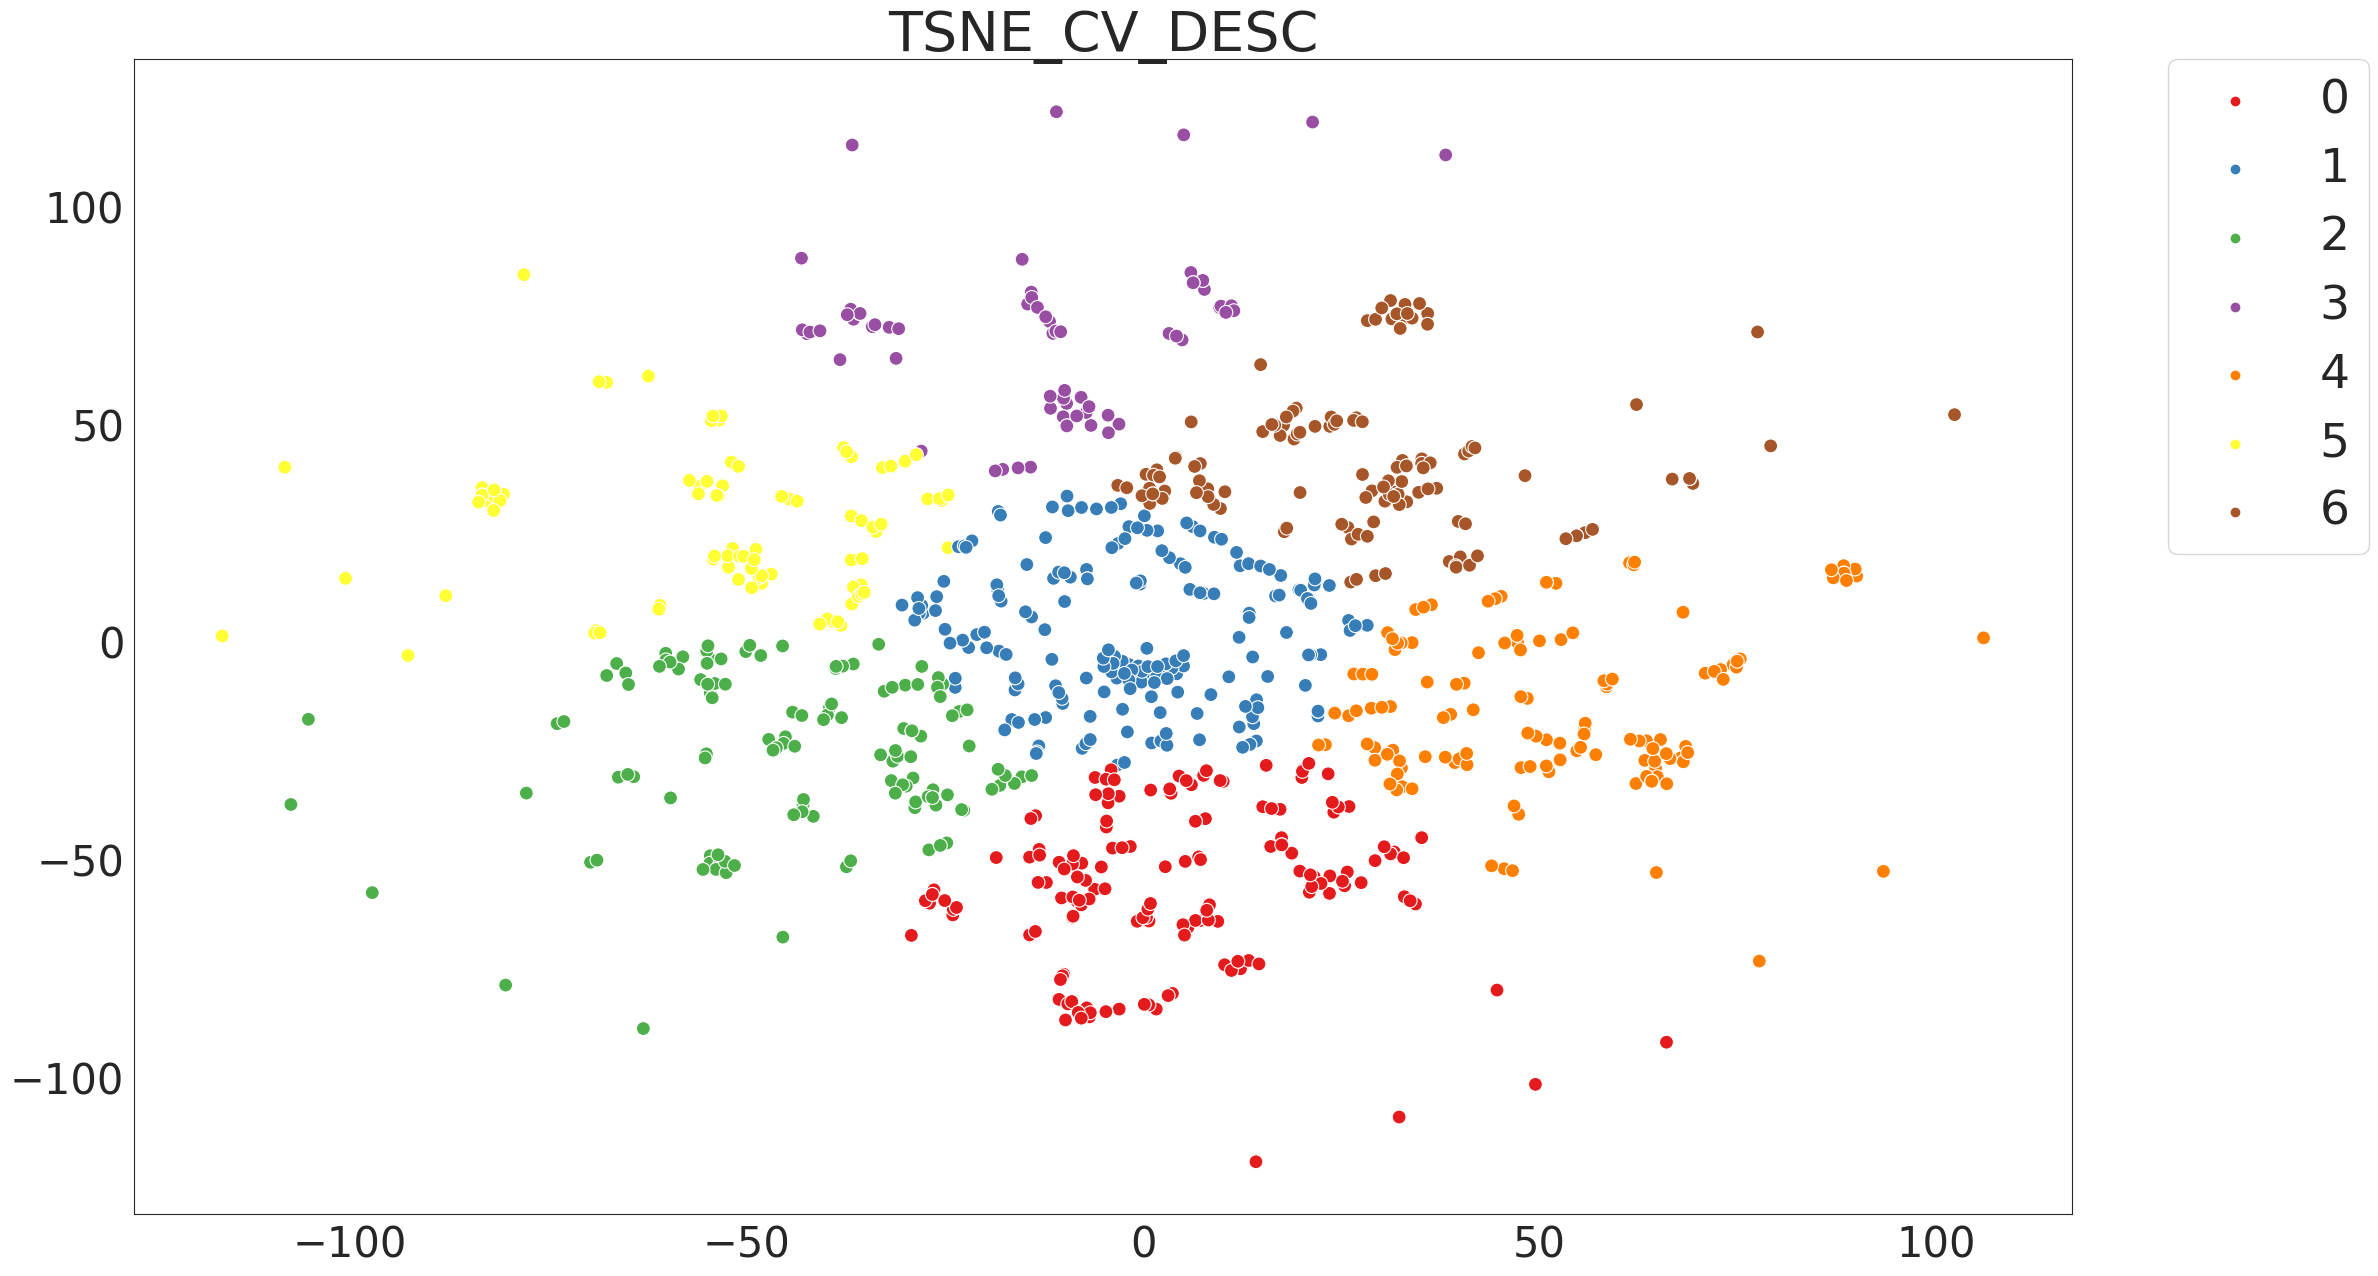

In [211]:
affiche_projection_par_clusters(X_proj_tsne_cv_desc,kmeans_tsne_cv_desc_labels,
                               type_donnee)

In [144]:
# Qualité Clusters
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
from IPython.display import display, Markdown

In [145]:
def traduire_valeurs_variable(dataframe, colonne_a_traduire, dictionnaire):
    """
    Traduire les valeurs de la colonne du dataframe transmis par la valeur du dictionnaire
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                colonne_a_traduire : colonne dont on veut traduire les valeurs obligatoire
                dictionnaire :dictionnaire clé=à remplacer,
                              valeur = le texte de remplacement oblgatoire
    @param OUT :None
    """
    for cle, valeur in dictionnaire.items():
        dataframe[colonne_a_traduire] = dataframe[colonne_a_traduire].replace(
            cle, valeur)


In [309]:
def affiche_qualite_categorisation(dataframe, dico_traduction, titre):
    '''
    Afiche heatmap de la qualité de la catégorisation et donne l'accuracy.
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    dico_traduction : traduction des catégories de nombre à texte, obligatoire.
    titre : type de données traitées.
    Returns
    -------
    None.
    '''
    dataframe['Cluster_labels'] = dataframe['Clusters'].copy().astype('str')
    traduire_valeurs_variable(dataframe, 'Cluster_labels',
                                          dico_traduction)

    cat_pred = dataframe['CATEGORIE']
    cat_reel = dataframe['Cluster_labels']
    
    conf_mat = confusion_matrix(cat_reel,cat_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters calcul: ", corresp)

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(cat_reel,cat_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='Blues',
                yticklabels=sorted(cat_pred.unique()))
    plt.title(titre)
    plt.show()

    display(
        'Précision: {}%'.format(
            round(
                accuracy_score(
                    cat_pred,
                    cat_reel) *
                100,
                2)))
    display(Markdown(classification_report(cat_reel,cat_pred)))


Correspondance des clusters calcul:  [0 1 2 3 4 3 3]


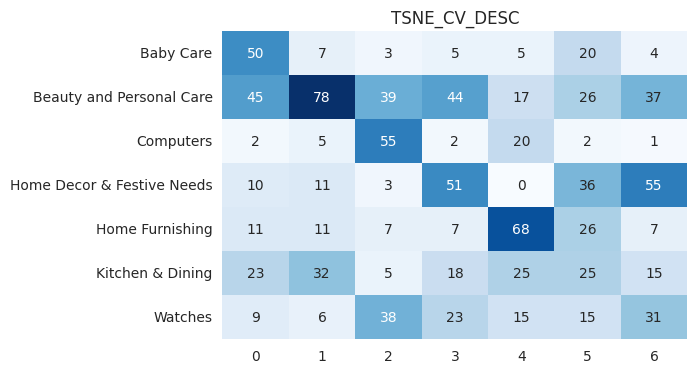

'Précision: 34.1%'

                            precision    recall  f1-score   support

                 Baby Care       0.33      0.53      0.41        94
  Beauty and Personal Care       0.52      0.27      0.36       286
                 Computers       0.37      0.63      0.46        87
Home Decor & Festive Needs       0.34      0.31      0.32       166
           Home Furnishing       0.45      0.50      0.47       137
          Kitchen & Dining       0.17      0.17      0.17       143
                   Watches       0.21      0.23      0.22       137

                  accuracy                           0.34      1050
                 macro avg       0.34      0.38      0.35      1050
              weighted avg       0.36      0.34      0.34      1050


In [229]:
dico_categories = {'0': 'Home Decor & Festive Needs',
                   '1': 'Beauty and Personal Care',
                   '2': 'Watches',
                   '3': 'Computers',
                   '4': 'Kitchen & Dining',
                   '5': 'Baby Care',
                   '6': 'Home Furnishing'}
affiche_qualite_categorisation(df_tsne_cv_desc,
                                          dico_categories, type_donnee)

### <span style=''>7.4 TSNE  BOW - TfidfVectorizer </span>

In [230]:
type_donnee = 'TSNE_TFIDF_DESC'

In [231]:
# Tunig hyperparametres n_init, max_iter
# parametres a tester

n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]

# Metriques avec les differentes combinaisons des parametres

df_metrics_kmeans = calcul_metrics_kmeans(df_tsne_tfidf_desc[cols],
                                         df_metrics_kmeans,
                                         type_donnee,
                                         seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0

df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
.sort_values(by =['coef_silh','davies_bouldin','Durée (s)'], ascending = [False, True, True]).style.hide()

In [232]:
# Sauvegarde des dataframes de trace
df_metrics_kmeans.to_csv('data_df_metrics_kmeans.csv')

In [233]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
kmeans_tsne_tfidf_desc = KMeans(n_clusters=7, init='k-means++',
                                    n_init=50, max_iter=500,
                                    random_state=seed) \
    .fit(df_tsne_tfidf_desc[cols])
# Ajout de l'assignation du cluster au dataframe
df_tsne_tfidf_desc['Clusters'] = kmeans_tsne_tfidf_desc.labels_
kmeans_tsne_tfidf_desc_labels = kmeans_tsne_tfidf_desc.labels_

In [234]:
# Scores ?
df_scores = calcul_metriques_clusters(df_tsne_tfidf_desc,
                                                 df_scores,
                                                 type_donnee)
df_scores.style.hide()

In [235]:
# Sauvegarde des dataframes de trace
df_scores.to_csv('data_df_scores.csv')

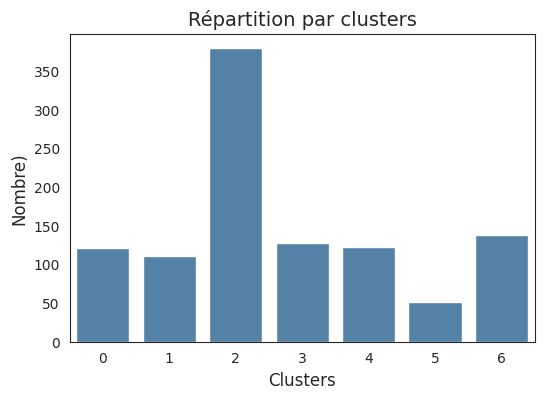

In [236]:
affiche_repartition_par_clusters(kmeans_tsne_tfidf_desc_labels)

In [237]:
# Les catégories par clusters
df_tsne_tfidf_desc.groupby('Clusters')['CATEGORIE'].value_counts() \
    .to_frame()

count
Clusters CATEGORIE                        
0        Kitchen & Dining               27
         Home Furnishing                27
         Computers                      23
         Home Decor & Festive Needs     19
         Beauty and Personal Care       15
         Baby Care                       8
         Watches                         2
1        Baby Care                      23
         Home Furnishing                22
         Watches                        16
         Kitchen & Dining               16
         Home Decor & Festive Needs     13
         Beauty and Personal Care       11
         Computers                      10
2        Home Decor & Festive Needs     84
         Beauty and Personal Care       81
         Baby Care                      57
         Computers                      56
         Watches                        39
         Kitchen & Dining               36
         Home Furnishing                26
3        Home Furnishing                65
         Watches                        16
         Baby Care                      14
         Beauty and Personal Care       13
         Kitchen & Dining                9
         Home Decor & Festive Needs      8
         Computers                       3
4        Kitchen & Dining               42
         Baby Care                      32
         Computers                      15
         Home Decor & Festive Needs     12
         Home Furnishing                 8
         Beauty and Personal Care        7
         Watches                         6
5        Baby Care                      12
         Home Decor & Festive Needs     12
         Beauty and Personal Care        8
         Computers                       7
         Kitchen & Dining                6
         Watches                         6
6        Watches                        65
         Computers                      36
         Beauty and Personal Care       15
         Kitchen & Dining               14
         Baby Care                       4
         Home Decor & Festive Needs      2
         Home Furnishing                 2

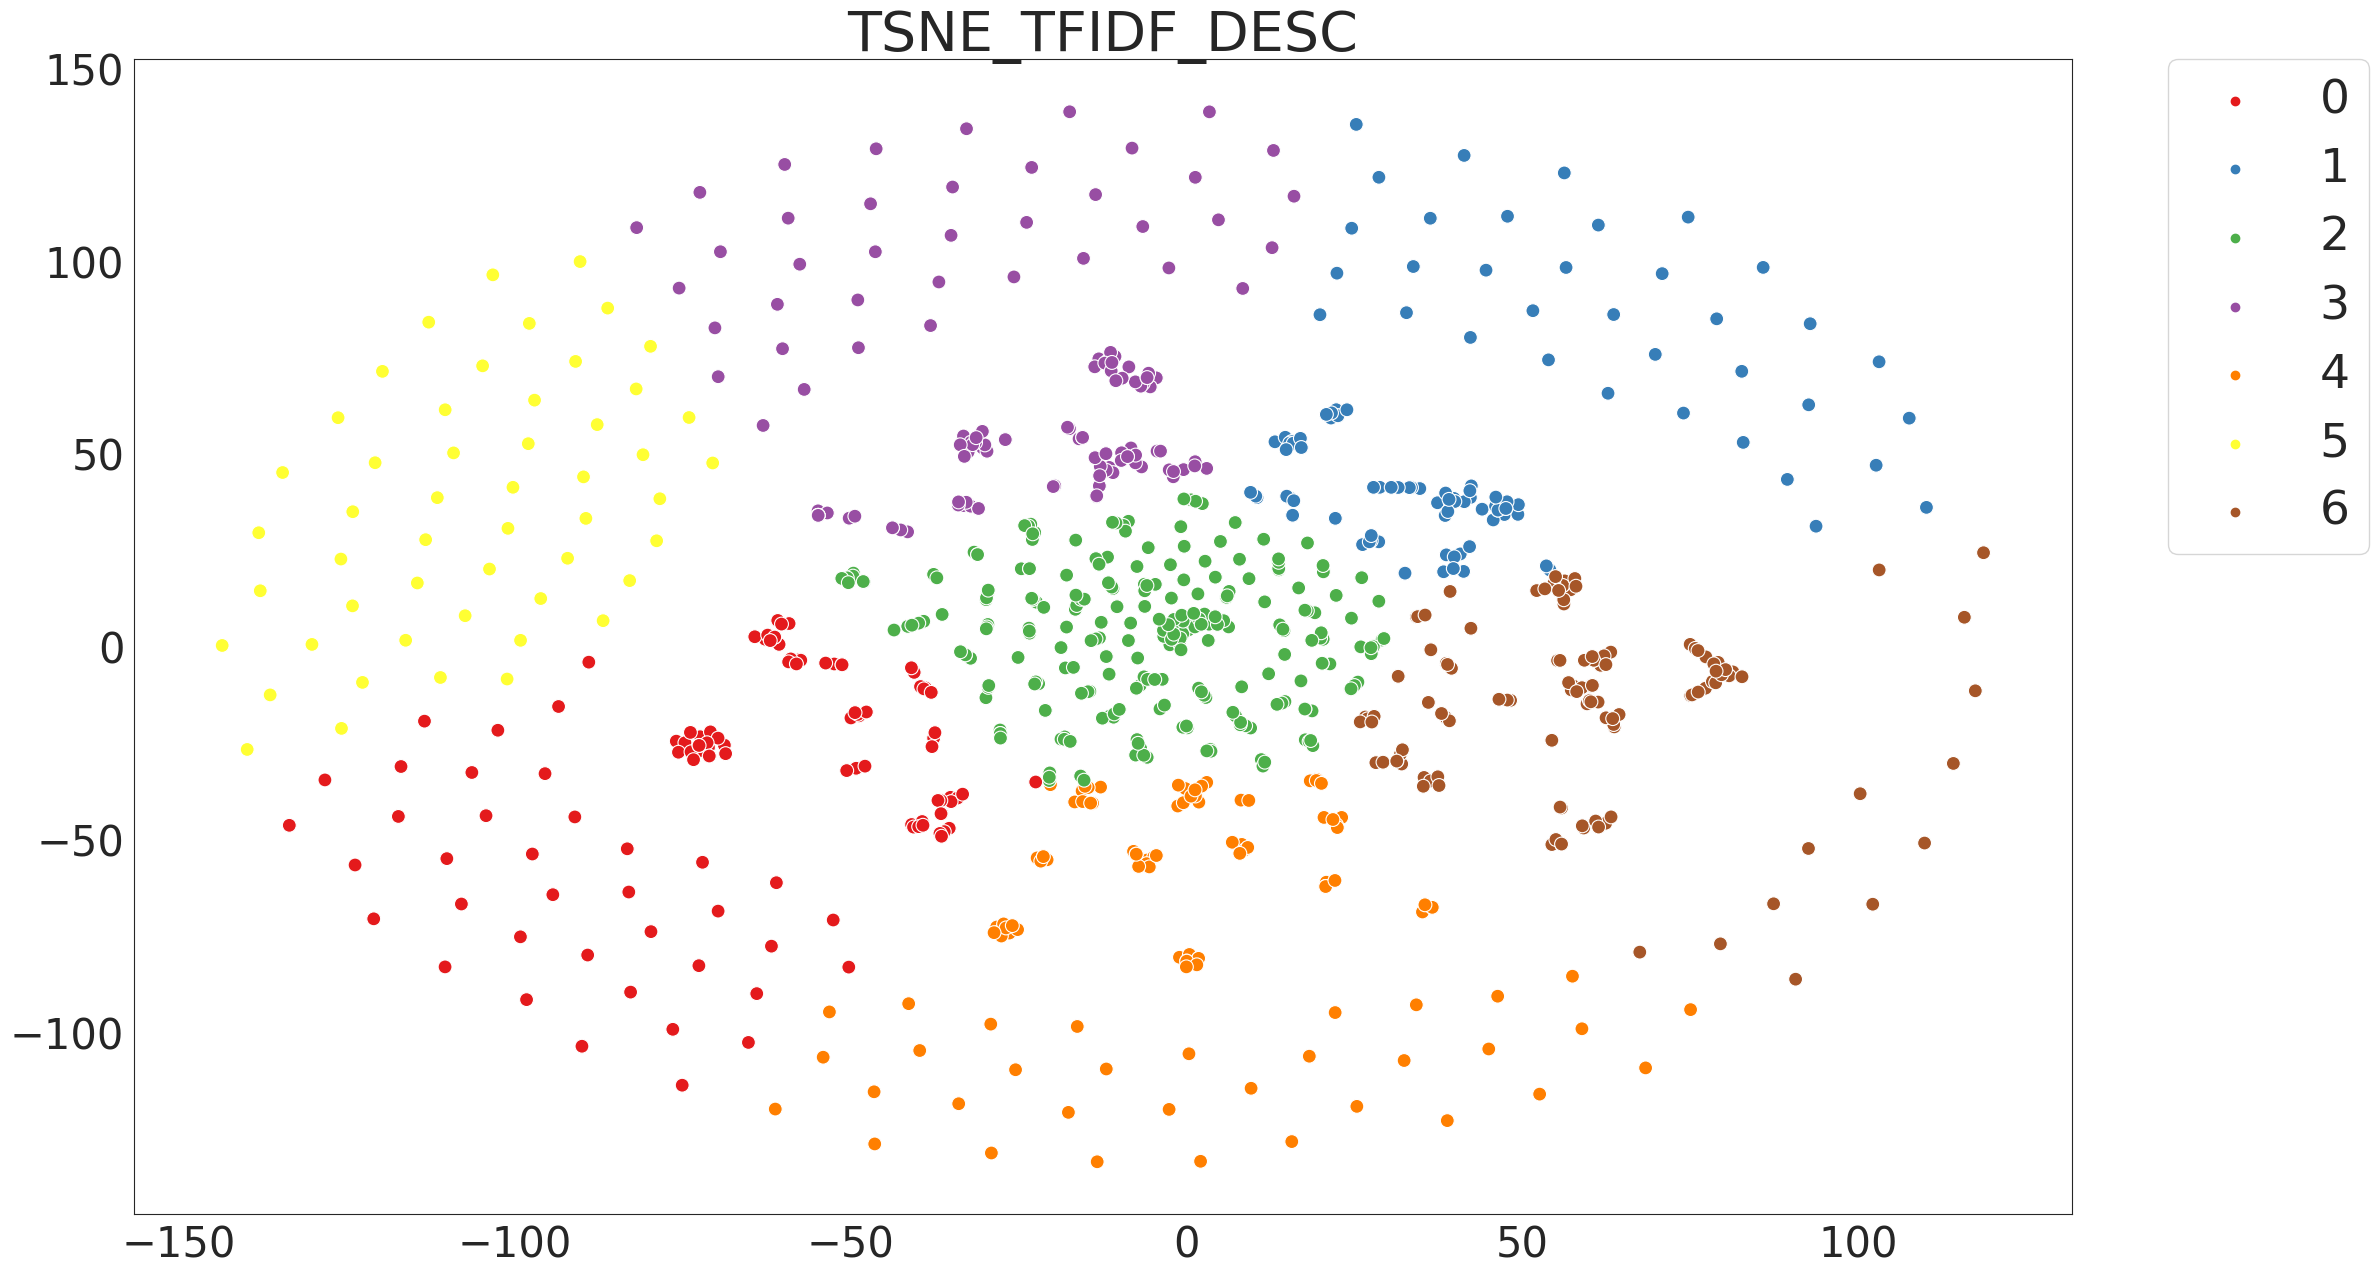

In [238]:
# Visualisation des clusters
affiche_projection_par_clusters(X_proj_tsne_tfidf_desc,
                                           kmeans_tsne_tfidf_desc_labels,
                                           type_donnee)

Correspondance des clusters calcul:  [3 3 3 3 4 1 2]


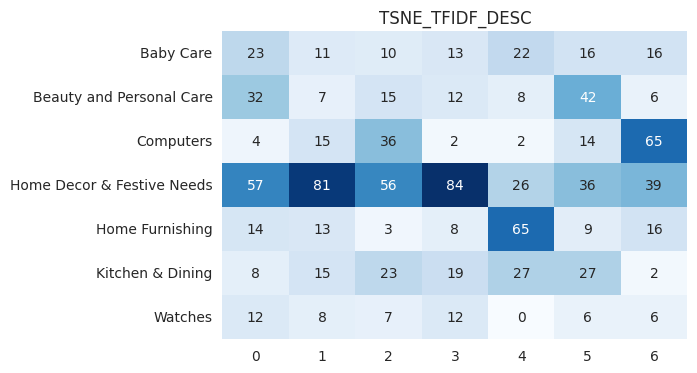

'Précision: 23.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.15      0.21      0.18       111
  Beauty and Personal Care       0.05      0.06      0.05       122
                 Computers       0.24      0.26      0.25       138
Home Decor & Festive Needs       0.56      0.22      0.32       379
           Home Furnishing       0.43      0.51      0.47       128
          Kitchen & Dining       0.18      0.22      0.20       121
                   Watches       0.04      0.12      0.06        51

                  accuracy                           0.24      1050
                 macro avg       0.24      0.23      0.22      1050
              weighted avg       0.33      0.24      0.25      1050


In [250]:
dico_categories = {'0': 'Kitchen & Dining',
                   '1': 'Baby Care',
                   '2': 'Home Decor & Festive Needs',
                   '3': 'Home Furnishing',
                   '4': 'Beauty and Personal Care',
                   '5': 'Watches',
                   '6': 'Computers'}
affiche_qualite_categorisation(df_tsne_tfidf_desc,
                                          dico_categories, type_donnee)

### <span style=''>7.5 ACP + TSNE  BOW - CountVectorizer  </span>

In [251]:
type_donnee = 'ACP+TSNE_CV_DESC'

In [252]:
# Tuning hyperparametres n_init, max_iter
# Paramètres à tester
n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]
# Métriques avec les différentes combinaisons des paramètres
df_metrics_kmeans = calcul_metrics_kmeans(df_acptsne_cv_desc[cols],
                                     df_metrics_kmeans,
                                     type_donnee,
                                     seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0
df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
    .sort_values(by=['coef_silh', 'davies_bouldin', 'Durée (s)'],
                 ascending=[False, True, True]).style.hide()

In [253]:
# Sauvegarde des dataframes de trace
df_metrics_kmeans.to_csv('data_df_metrics_kmeans.csv')

In [254]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
kmeans_tsne_acp_cv_desc = KMeans(n_clusters=7, init='k-means++',
                                     n_init=10, max_iter=100,
                                     random_state=seed) \
    .fit(df_acptsne_cv_desc[cols])
# Ajout de l'assignation du cluster au dataframe
df_acptsne_cv_desc['Clusters'] = kmeans_tsne_acp_cv_desc.labels_
kmeans_tsne_acp_cv_desc_labels = kmeans_tsne_acp_cv_desc.labels_

In [255]:
# Scores ?
df_scores = calcul_metriques_clusters(df_acptsne_cv_desc,
                                                 df_scores,
                                                 type_donnee)
df_scores.style.hide()

In [256]:
# Sauvegarde des dataframes de trace
df_scores.to_csv('data_df_scores.csv')

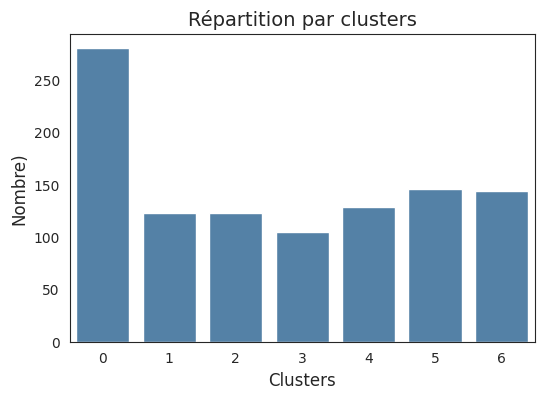

In [257]:
affiche_repartition_par_clusters(kmeans_tsne_acp_cv_desc_labels)

In [258]:
# Les catégories par clusters
df_acptsne_cv_desc.groupby('Clusters')['CATEGORIE'].value_counts() \
    .to_frame()

count
Clusters CATEGORIE                        
0        Beauty and Personal Care       79
         Home Decor & Festive Needs     49
         Watches                        44
         Kitchen & Dining               39
         Computers                      28
         Baby Care                      27
         Home Furnishing                14
1        Baby Care                      30
         Home Decor & Festive Needs     27
         Computers                      25
         Beauty and Personal Care       17
         Kitchen & Dining               13
         Watches                         8
         Home Furnishing                 3
2        Baby Care                      40
         Home Decor & Festive Needs     34
         Watches                        12
         Beauty and Personal Care       12
         Home Furnishing                11
         Kitchen & Dining                8
         Computers                       6
3        Computers                      38
         Watches                        34
         Kitchen & Dining               24
         Beauty and Personal Care        5
         Home Decor & Festive Needs      3
         Baby Care                       1
4        Watches                        45
         Home Furnishing                30
         Kitchen & Dining               18
         Beauty and Personal Care       17
         Baby Care                      11
         Home Decor & Festive Needs      5
         Computers                       3
5        Home Furnishing                69
         Kitchen & Dining               29
         Baby Care                      19
         Home Decor & Festive Needs     15
         Beauty and Personal Care        9
         Computers                       3
         Watches                         2
6        Computers                      47
         Home Furnishing                23
         Baby Care                      22
         Kitchen & Dining               19
         Home Decor & Festive Needs     17
         Beauty and Personal Care       11
         Watches                         5

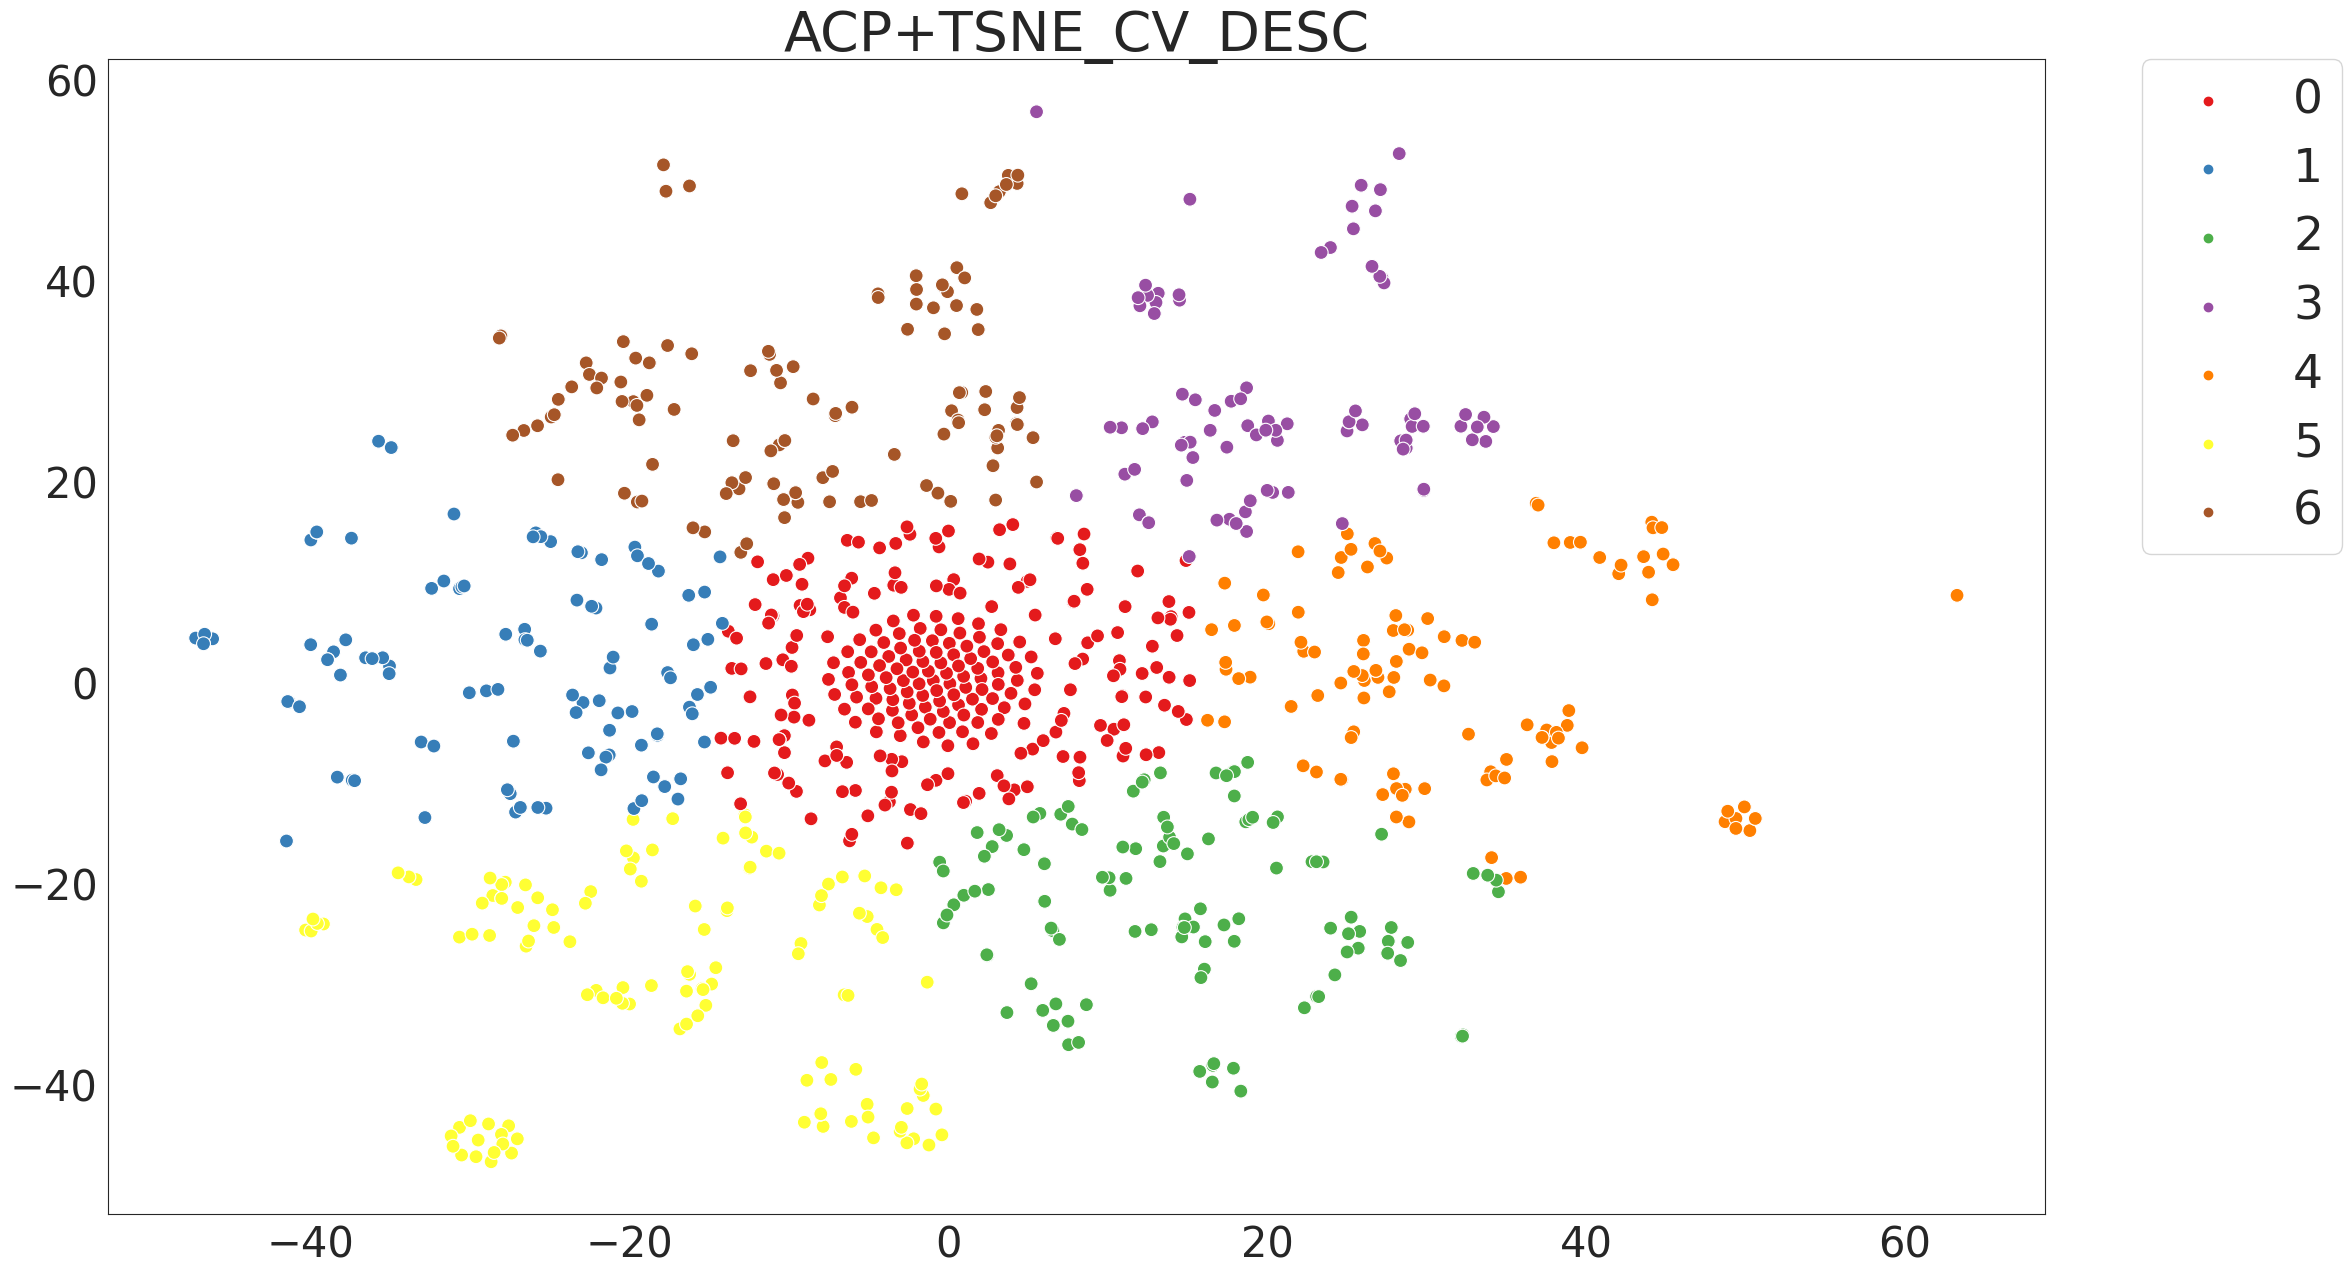

In [259]:
# Visualisation des clusters
affiche_projection_par_clusters(X_proj_acptsne_cv_desc,
                                           kmeans_tsne_acp_cv_desc_labels,
                                           type_donnee)

**Bilan** :
***

- Les 7 catégories sont bien trouvées avec cependant quelques mélanges :
 
- Cette combinaison ACP+TSNE CountVectorizer + description  parvient à retrouver les 7 catégories comme le souhaite notre client. Il reste à mesurer la qualité de cette catégorisation.

Correspondance des clusters calcul:  [3 1 5 1 4 1 6]


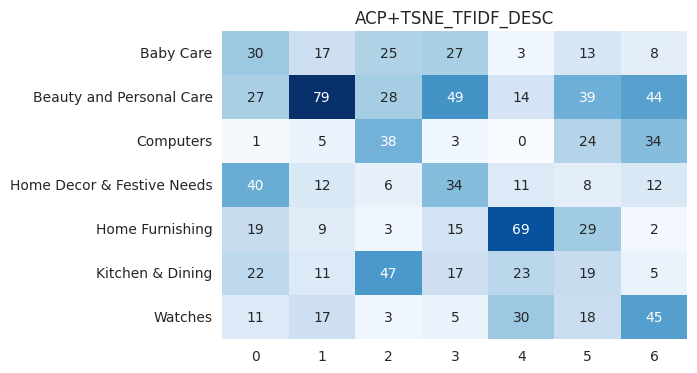

'Précision: 29.9%'

                            precision    recall  f1-score   support

                 Baby Care       0.20      0.24      0.22       123
  Beauty and Personal Care       0.53      0.28      0.37       280
                 Computers       0.25      0.36      0.30       105
Home Decor & Festive Needs       0.23      0.28      0.25       123
           Home Furnishing       0.46      0.47      0.47       146
          Kitchen & Dining       0.13      0.13      0.13       144
                   Watches       0.30      0.35      0.32       129

                  accuracy                           0.30      1050
                 macro avg       0.30      0.30      0.29      1050
              weighted avg       0.33      0.30      0.30      1050


In [308]:
dico_categories = {'0': 'Beauty and Personal Care',
                   '1': 'Baby Care',
                   '2': 'Home Decor & Festive Needs',
                   '3': 'Computers',
                   '4': 'Watches',
                   '5': 'Home Furnishing',
                   '6': 'Kitchen & Dining'}
affiche_qualite_categorisation(df_acptsne_cv_desc,
                                          dico_categories, type_donnee)

### <span style=''>7.6 ACP + TSNE  BOW - TfidfVectorizer  </span>

In [283]:
type_donnee = 'ACP+TSNE_TFIDF_DESC'

In [284]:
# Tuning hyperparametres n_init, max_iter
# Paramètres à tester
n_init = [10, 20, 30, 50, 70, 80, 100]
max_iter = [100, 200, 300, 400, 500]
# Métriques avec les différentes combinaisons des paramètres
df_metrics_kmeans = calcul_metrics_kmeans(df_acptsne_tfidf_desc[cols],
                                     df_metrics_kmeans,
                                     type_donnee,
                                     seed, n_init, max_iter)
# Tri par indice de dispersion : proche de 0
df_metrics_kmeans[df_metrics_kmeans['Type_données'] == type_donnee] \
    .sort_values(by=['coef_silh', 'davies_bouldin', 'Durée (s)'],
                 ascending=[False, True, True]).style.hide()

In [285]:
# Sauvegarde des dataframes de trace
df_metrics_kmeans.to_csv('data_df_metrics_kmeans.csv')

In [288]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
kmeans_acptsne_tfidf_desc = KMeans(n_clusters=7, init='k-means++',
                                       n_init=10, max_iter=100,
                                       random_state=seed) \
    .fit(df_acptsne_tfidf_desc[cols])
# Ajout de l'assignation du cluster au dataframe
df_acptsne_tfidf_desc['Clusters'] = kmeans_acptsne_tfidf_desc.labels_
kmeans_acptsne_tfidf_desc_labels = kmeans_acptsne_tfidf_desc.labels_

In [289]:
# Scores ?
df_scores = calcul_metriques_clusters(df_acptsne_tfidf_desc,
                                                 df_scores,
                                                 type_donnee)
df_scores.style.hide()

In [290]:
# Sauvegarde des dataframes de trace
df_scores.to_csv('data_df_scores.csv')

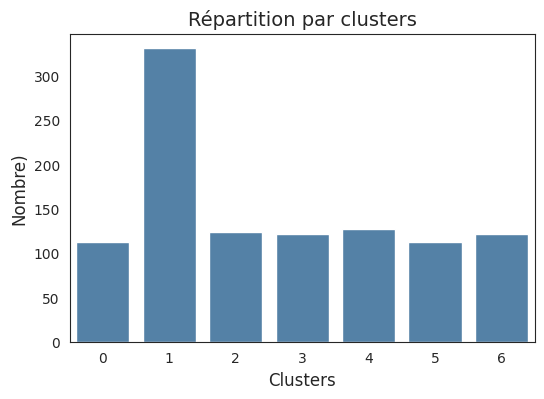

In [291]:
 affiche_repartition_par_clusters(kmeans_acptsne_tfidf_desc_labels)

In [292]:
# Les catégories par clusters
df_acptsne_tfidf_desc.groupby('Clusters')['CATEGORIE'].value_counts() \
    .to_frame()

count
Clusters CATEGORIE                        
0        Home Furnishing                27
         Computers                      25
         Home Decor & Festive Needs     16
         Kitchen & Dining               15
         Watches                        11
         Baby Care                       9
         Beauty and Personal Care        9
1        Beauty and Personal Care       78
         Home Decor & Festive Needs     68
         Computers                      49
         Kitchen & Dining               41
         Watches                        40
         Baby Care                      39
         Home Furnishing                16
2        Kitchen & Dining               41
         Computers                      26
         Baby Care                      24
         Home Furnishing                22
         Home Decor & Festive Needs      5
         Beauty and Personal Care        5
         Watches                         1
3        Computers                      39
         Beauty and Personal Care       26
         Baby Care                      18
         Watches                        16
         Kitchen & Dining               12
         Home Furnishing                 6
         Home Decor & Festive Needs      5
4        Watches                        65
         Home Furnishing                19
         Kitchen & Dining               19
         Baby Care                      13
         Home Decor & Festive Needs      5
         Beauty and Personal Care        5
         Computers                       1
5        Baby Care                      30
         Home Decor & Festive Needs     22
         Beauty and Personal Care       21
         Kitchen & Dining               17
         Home Furnishing                 9
         Computers                       8
         Watches                         6
6        Home Furnishing                51
         Home Decor & Festive Needs     29
         Baby Care                      17
         Watches                        11
         Beauty and Personal Care        6
         Kitchen & Dining                5
         Computers                       2

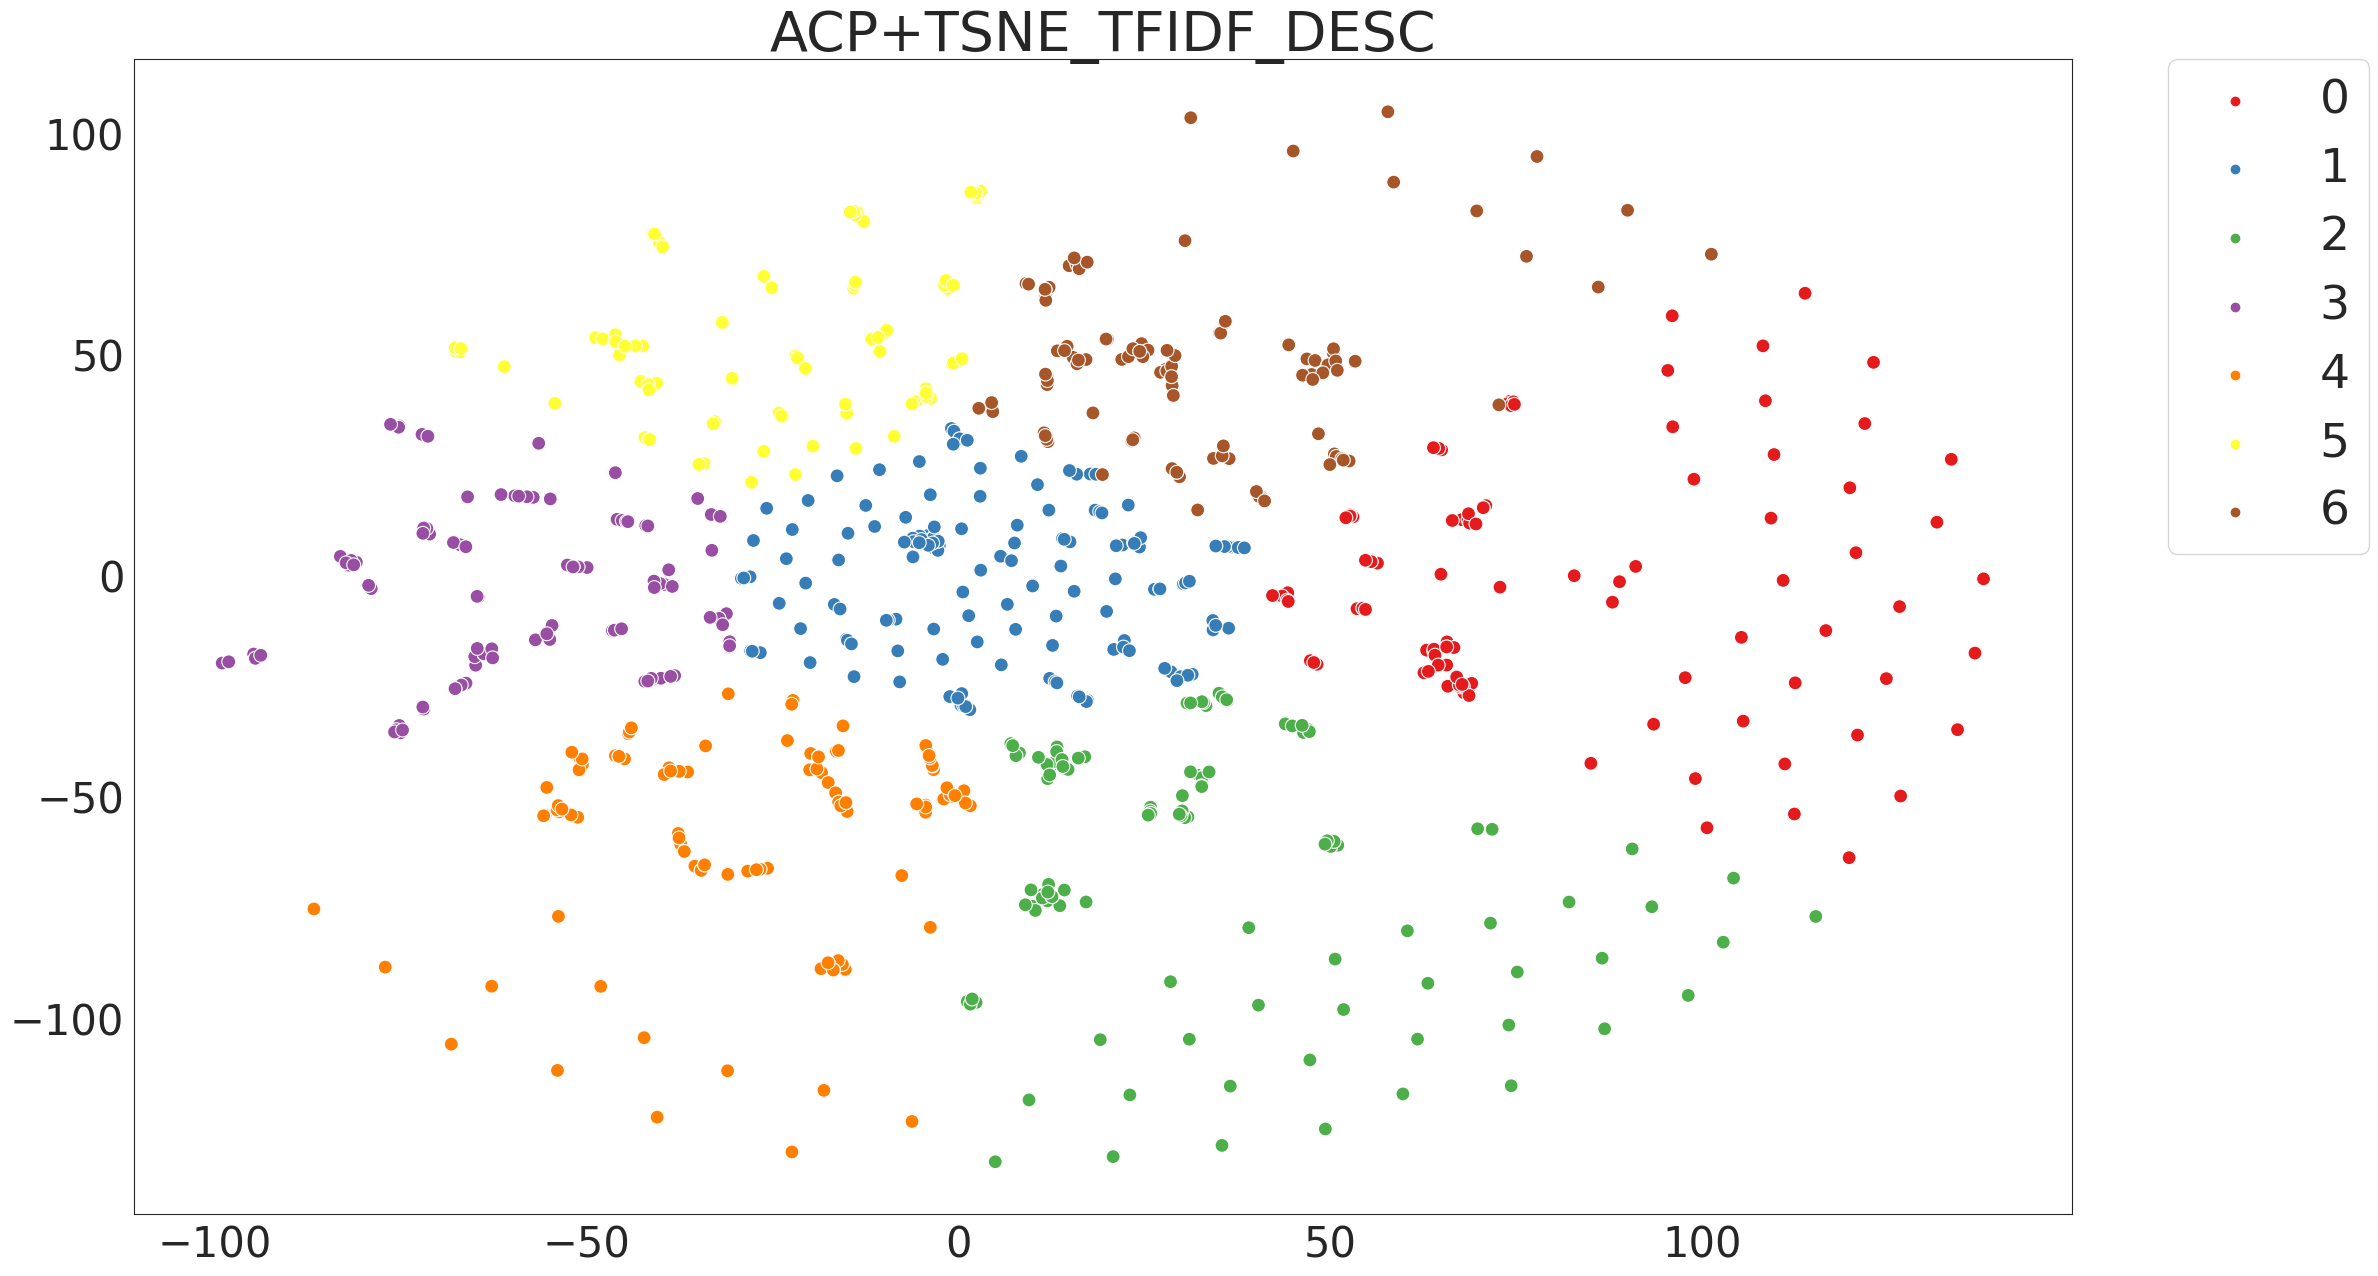

In [293]:
# Visualisation des clusters
affiche_projection_par_clusters(X_proj_acptsne_tfidf_desc,
                                     kmeans_acptsne_tfidf_desc_labels,
                                     type_donnee)

Correspondance des clusters calcul:  [1 1 1 1 4 1 6]


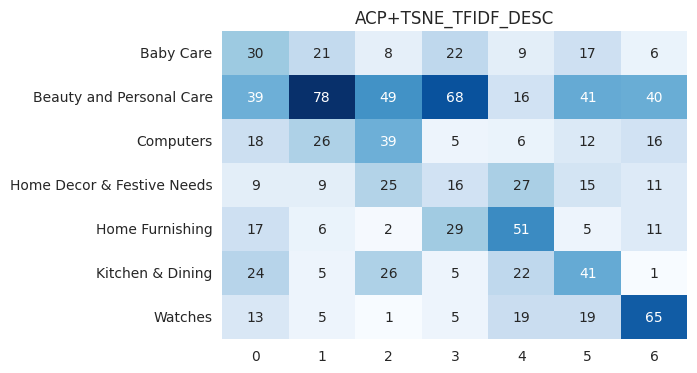

'Précision: 30.48%'

                            precision    recall  f1-score   support

                 Baby Care       0.20      0.27      0.23       113
  Beauty and Personal Care       0.52      0.24      0.32       331
                 Computers       0.26      0.32      0.29       122
Home Decor & Festive Needs       0.11      0.14      0.12       112
           Home Furnishing       0.34      0.42      0.38       121
          Kitchen & Dining       0.27      0.33      0.30       124
                   Watches       0.43      0.51      0.47       127

                  accuracy                           0.30      1050
                 macro avg       0.30      0.32      0.30      1050
              weighted avg       0.35      0.30      0.31      1050


In [310]:
dico_categories = {'0': 'Home Decor & Festive Needs',
                   '1': 'Beauty and Personal Care',
                   '2': 'Kitchen & Dining',
                   '3': 'Computers',
                   '4': 'Watches',
                   '5': 'Baby Care',
                   '6': 'Home Furnishing'}
affiche_qualite_categorisation(df_acptsne_tfidf_desc,
                                          dico_categories, type_donnee)

**Comparaison des modeles**

In [311]:
# Dataframe de comparaison des scores ARI et de la précision
df_comparaison = df_scores.copy()

df_comparaison['ARI'] = df_comparaison['ARI'].astype(float)
df_comparaison['Homogénéité'] = df_comparaison['Homogénéité'].astype(float)
df_comparaison['Complétude'] = df_comparaison['Complétude'].astype(float)
df_comparaison['V-measure'] = df_comparaison['V-measure'].astype(float)


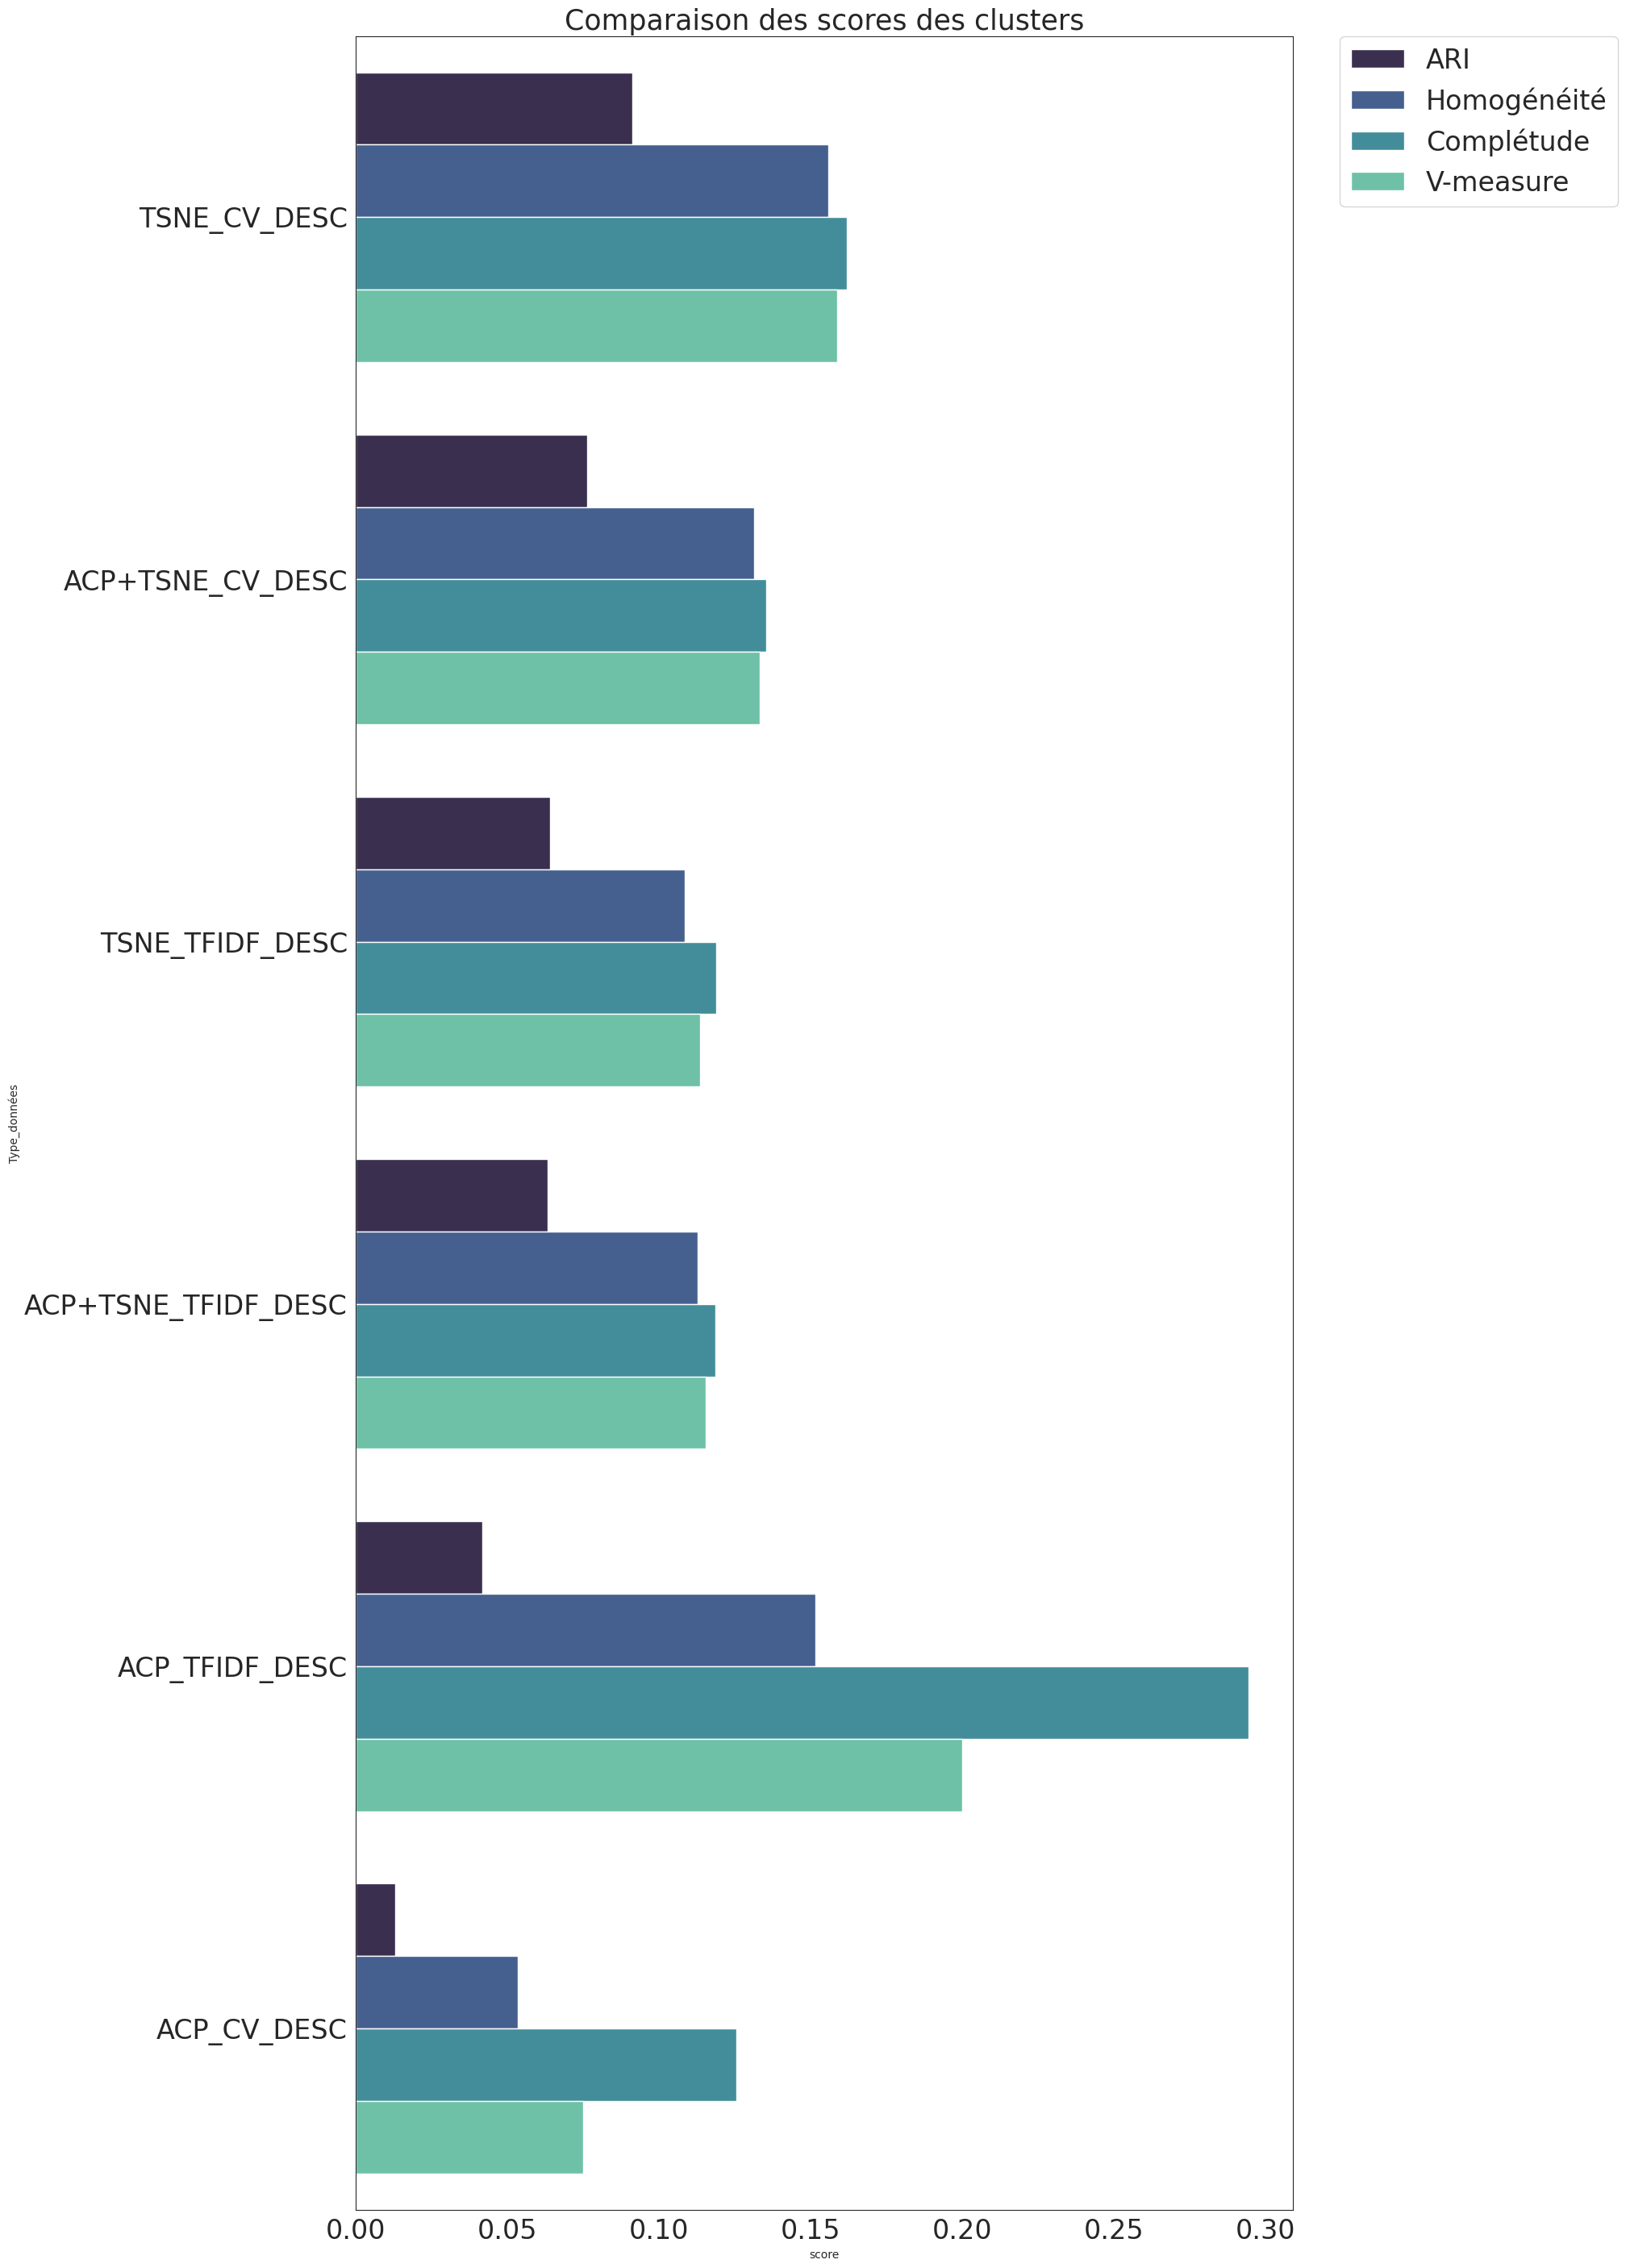

In [312]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_sort = df_comparaison.sort_values(by='ARI', ascending=False)
comparaison_score_melt = pd.melt(df_comp_sort, id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['ARI', 'Homogénéité',
                                             'Complétude', 'V-measure'])
# Visualisation
plt.figure(figsize=(15, 35))
sns.barplot(y=comparaison_score_melt['Type_données'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'], palette='mako')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('Comparaison des scores des clusters', fontsize=25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.savefig('P.jpg')
plt.show()

In [180]:
data_work.to_csv('data_clean.csv')